# <span style='color:SteelBlue'>P7 - Implémentez un modèle de scoring - DASHBOAD

Ce notebook traite de la préparation des différents champs et des graphiques du jeu de test pour affichage dans le dashboard.

En particulier :
- **jeu de test** : récupération des champs à afficher dans le dashboard sous une forme compréhensible (ex : âge en années plutôt qu'en nombre de jour, sexe en Féminin/Masculin plutôt que 0/1).
- **interprétabilité/transparence** :
    - récupération des 10 variables les plus importantes pour créer des graphiques pour chacune des ces variables en comparant les résultats des défaillants/non défaillant, de la moyenne global sur tous les clients pour situer la position du client à qui on accordera ou non le prêt.
    - récupération des 10 voisins les plus proches sur ces 10 variables pour le situer parmi ces 10 voisins ceux qui ont été défaillants ou non.
    - situer le patient parmi les défaillants ou non défaillants sur les variables âge, sexe, catégorie socio-professionnelle, revenus, montant du crédit, durée du crédit...

## 1. Introduction</span>

*****
**Mission**
*****
**Développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

*****
**Objectifs**
*****
- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/c/home-credit-default-risk/data)

In [1]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings

import numpy as np
import pandas as pd
import pickle
from joblib import dump, load
from collections import Counter

# Librairies personnelles
import outils_data
import outils_model
import outils_preprocessing

# Visualisation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import plotly.graph_objects as go

# Modèle
import sklearn
from sklearn.neighbors import KNeighborsClassifier

# Standardisation
from sklearn.preprocessing import StandardScaler

# Interprétation
import shap

# Warnings
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)



# Versions
print('Version des librairies utilisées :')
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Matplotlib            : ' + matplotlib.__version__)
print('Seaborn               : ' + sns.__version__)
print('Scikit-learn          : ' + sklearn.__version__)
print('Outils dataframe      : ' + outils_data.__version__)
print('Outils modélisation   : ' + outils_model.__version__)
print('Outils préprocessing  : ' + outils_preprocessing.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
Python                : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.21.5
Pandas                : 1.4.2
Matplotlib            : 3.5.1
Seaborn               : 0.11.2
Scikit-learn          : 1.1.1
Outils dataframe      : 0.0.4
Outils modélisation   : 0.0.1
Outils préprocessing  : 0.0.0
Lancé le           : 2022-07-14T11:00:52.819754


In [2]:
dico_pd_option = {
    'display.max_rows': 500,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## 2. Initialisation (test/meilleur modèle)</span>

**Chargement du jeu de données du train set sans pré-processing**</span>

In [3]:
application_train = pd.read_csv('Data/application_train.csv')
application_train.shape

(307511, 122)

In [4]:
# Correction valeurs aberrantes
application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED']
                                   == 365243] = 0

In [5]:
# Correction : difficile d'imputer le sexe par le mode de cette catégorie
# Comme il n'y a que 4 clients avec un sexe non renseigné, on supprime ces
# valeurs
application_train = \
    application_train[application_train['CODE_GENDER'] != 'XNA']
application_train.shape

(307507, 122)

**Chargement du jeu de données du test set sans pré-processing**</span>

In [6]:
application_test = pd.read_csv('Data/application_test.csv')
application_test.shape

(48744, 121)

In [7]:
# Correction valeurs aberrantes
application_test['DAYS_EMPLOYED'][application_test['DAYS_EMPLOYED']
                                  == 365243] = 0

**Chargement du jeu de données du train set issu du pré-processing et de la feature sélection**</span>

- **train_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [8]:
fic_sav_train_set_sans = \
    'sauvegarde/features-selection/train_set_sans_var_magique.pickle'
# Chargement de train_set
with open(fic_sav_train_set_sans, 'rb') as df_appli_train_set_sans:
    train_set = pickle.load(df_appli_train_set_sans)
train_set.shape

(307507, 112)

**Chargement du jeu de données du test set issu du pré-processing et de la feature sélection**</span>

- **test_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [9]:
fic_sav_test_set_sans = \
    'sauvegarde/features-selection/test_set_sans_var_magique.pickle'
# Chargement de test_set
with open(fic_sav_test_set_sans, 'rb') as df_appli_test_set_sans:
    test_set = pickle.load(df_appli_test_set_sans)
test_set.shape

(48744, 111)

In [10]:
filename = 'sauvegarde/pickle/test_set.pickle'
outfile = open(filename,'wb')
pickle.dump(test_set, outfile)
outfile.close()

**Chargement du meilleur modèle LightGBM**</span>

In [11]:
# Chargement du meilleur modèle
fic_best_model = 'sauvegarde/modelisation/best_model.pickle'
with open(fic_best_model, 'rb') as df_best_model:
    best_model = pickle.load(df_best_model)
best_model

LGBMClassifier(class_weight='balanced', colsample_bytree=0.65731418761953,
               force_col_wise=True, max_depth=9, min_child_samples=96,
               min_child_weight=0.5685528790757488, num_leaves=13,
               objective='binary', reg_alpha=1.7033609851586964e-06,
               reg_lambda=0.012745771755334187, silent=True,
               subsample=0.8190208924749053, subsample_freq=1, verbosity=-1)

In [12]:
filename =  'sauvegarde/pickle/best_model.pickle'
outfile = open(filename,'wb')
pickle.dump(best_model, outfile)
outfile.close()

In [13]:
dump(best_model, 'sauvegarde/joblib/best_model.joblib', compress=1)

['sauvegarde/joblib/best_model.joblib']

## 3. Scoring (prédictions/Probabilités)</span>

Le meilleur modèle entraîné sur le jeu d'entraînement est maintenant opérationnel pour effectuer des prédictions et calculer les probabiltés du score de chacun des clients du jeu de test fourni pour Home Crédit.

In [24]:
test_set

SK_ID_CURR  CREDIT_ANNUITY_RATIO  PREV_APP_NAME_CONTRACT_STATUS_MEAN  FLAG_DOCUMENT_3  OCCUPATION_TYPE_CORE_STAFF  INST_PAY_DAYS_PAYMENT_DIFF_MIN  DAYS_LAST_PHONE_CHANGE  POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN  PREV_APP_AMT_ANNUITY_MIN  CCB_BALANCE_LIMIT_RATIO_MEAN  \
0          100001               27.6719                              0.0000                1                         0.0                           -10.0                 -1740.0                                     0.7778                 3951.0000                        0.1145   
1          100005               12.8281                              1.0000                1                         0.0                            -1.0                     0.0                                     0.8184                 4813.2002                        0.1145   
2          100013                9.5078                              0.5000                0                         0.0                           -21.0                  -856.0                                     0.8887                 4742.4150                        0.1153   
3          100028               32.1250                              0.6001                1                         0.0                            -7.0                 -1805.0                                     0.9355                 6028.0200                        0.0359   
4          100038               19.5000                              1.0000                1                         0.0                             9.0                  -821.0                                     0.9229                11100.5996                        0.1145   
...           ...                   ...                                 ...              ...                         ...                             ...                     ...                                        ...                       ...                           ...   
48739      456221               23.6094                              0.0000                0                         0.0                             6.0                  -684.0                                     0.7500                14222.4297                        0.1145   
48740      456222               19.5000                              0.0000                1                         0.0                           -18.0                     0.0                                     0.9458                 3653.9551                        0.1145   
48741      456223                9.4844                              0.0000                1                         0.0                            12.0                  -838.0                                     0.9355                12640.9502                        0.1145   
48742      456224               17.9062                              1.5996                1                         0.0                            -2.0                 -2308.0                                     0.9355                 5519.9248                        0.1145   
48743      456250               12.6562                              1.1250                1                         1.0                           -10.0                  -327.0                                     0.9331                 7847.6851                        0.9700   

       INST_PAY_AMT_INSTALMENT_MIN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN  ENQ_CREDIT_RATIO  PREV_APP_DAYS_FIRST_DUE_SUM  BUREAU_AMT_CREDIT_SUM_DEBT_SUM  NAME_INCOME_TYPE_WORKING  PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN  INST_PAY_NUM_INSTALMENT_VERSION_SUM  PREV_APP_SELLERPLACE_AREA_MEAN  \
0                        3951.0000                                0.9578        0.0000e+00                      -1709.0                      5.9669e+05                       1.0                                          14.2733                                  8.0                            23.0   
1                        4813.2002                          

In [25]:
# Copie du jeu de test
test = test_set.copy(deep=True)
# Sauvegarde des identifiants des clients inutiles aux prédictions
id_client = test['SK_ID_CURR']
# Préparation de la matrice à soumettre aux prédictions 
X_test = test.drop('SK_ID_CURR', axis=1)

In [26]:
fic_sav_test_set = \
    'sauvegarde/features-selection/test_set.pickle'
# Chargement de test_set
with open(fic_sav_test_set, 'rb') as df_appli_test_set:
    test_set2 = pickle.load(df_appli_test_set)
test_set2.shape

(48744, 614)

In [27]:
features_selctions=['CREDIT_ANNUITY_RATIO',
 'PREV_APP_AMT_ANNUITY_MEAN',
 'PREV_APP_DAYS_FIRST_DUE_SUM',
 'PREV_APP_AMT_ANNUITY_MIN',
 'PREV_APP_INTEREST_SHARE_MEAN',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN',
 'BUREAU_AMT_CREDIT_SUM_SUM',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_DOCUMENT_3',
 'EXT_SOURCE_SUM',
 'INST_PAY_DAYS_PAYMENT_DIFF_MIN',
 'PREV_APP_NAME_CONTRACT_STATUS_MEAN',
 'BUREAU_DAYS_CREDIT_MEAN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN',
 'INST_PAY_AMT_PAYMENT_RATIO_MEAN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN',
 'FLAGS_DOCUMENTS_SUM',
 'INST_PAY_AMT_INSTALMENT_MIN',
 'ENQ_CREDIT_RATIO',
 'NAME_INCOME_TYPE_WORKING',
 'BUREAU_CREDIT_TYPE_MORTGAGE_MEAN',
 'INST_PAY_DAYS_INSTALMENT_MAX',
 'PREV_APP_AMT_DOWN_PAYMENT_MEAN',
 'POS_CASH_SK_DPD_DEF_MEAN',
 'NAME_FAMILY_STATUS_MARRIED',
 'FLAG_OWN_CAR',
 'PREV_APP_CNT_PAYMENT_MEAN',
 'OWN_CAR_AGE',
 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
 'INST_PAY_AMT_PAYMENT_DIFF_MEAN',
 'REGION_RATING_CLIENT',
 'NAME_INCOME_TYPE_STATE_SERVANT',
 'YEARS_BEGINEXPLUATATION_AVG',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'CCB_BALANCE_LIMIT_RATIO_MEAN',
 'PREV_APP_SELLERPLACE_AREA_MEAN',
 'PREV_APP_ANNUITY_GOODS_MEAN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
 'OCCUPATION_TYPE_CORE_STAFF',
 'EXT_SOURCE_VAR',
 'INST_PAY_NUM_INSTALMENT_VERSION_SUM',
 'INST_PAY_DAYS_PAYMENT_RATIO_MEAN',
 'AMT_CREDIT',
 'BUREAU_AMT_CREDIT_SUM_DEBT_SUM',
 'ANNUITY_INCOME_RATIO',
 'CAR_EMPLOYED_RATIO',
 'BUREAU_AMT_CREDIT_SUM_MEAN',
 'INST_PAY_AMT_INSTALMENT_SUM',
 'EXT_SOURCE_3',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
 'DAYS_ID_PUBLISH',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
 'EXT_SOURCE_2',
 'CREDIT_GOODS_RATIO',
 'EXT_SOURCE_1',
 'PREV_APP_INTEREST_SHARE_MAX',
 'AMT_ANNUITY',
 'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
 'DAYS_BIRTH',
 'PREV_APP_DAYS_LAST_DUE_MAX',
 'DAYS_EMPLOYED',
 'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
 'CODE_GENDER',
 'PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX',
 'INST_PAY_DAYS_PAYMENT_RATIO_MIN',
 'CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'REGION_POPULATION_RELATIVE',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
 'BUREAU_DAYS_CREDIT_MAX',
 'DAYS_LAST_PHONE_CHANGE',
 'PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN',
 'EXT_SOURCE_MAX',
 'INST_PAY_AMT_INSTALMENT_MAX',
 'DAYS_REGISTRATION',
 'POS_CASH_CNT_INSTALMENT_MEAN',
 'INST_PAY_DAYS_INSTALMENT_MIN',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'FLAG_WORK_PHONE',
 'PREV_APP_INTEREST_SHARE_MIN',
 'PREV_APP_AMT_DECLINED_SUM',
 'CCB_CNT_DRAWINGS_CURRENT_SUM',
 'PREV_APP_CODE_REJECT_REASON_XAP_MEAN',
 'BUREAU_CREDIT_TYPE_MICROLOAN_MEAN',
 'PREV_APP_NAME_TYPE_SUITE_UNACCOMPANIED_MEAN',
 'FLOORSMAX_AVG',
 'BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT',
 'INST_PAY_AMT_INSTALMENT_MEAN',
 'APARTMENTS_AVG',
 'PREV_APP_HOUR_APPR_PROCESS_START_MEAN',
 'INCOME_GOODS_DIFF',
 'PREV_APP_INTEREST_RATE_MAX',
 'CREDIT_INCOME_RATIO',
 'PREV_APP_DAYS_DECISION_MAX',
 'PREV_APP_DAYS_DECISION_MEAN',
 'PREV_APP_AMT_INTEREST_MEAN',
 'PREV_APP_LOAN_RATE_MEAN',
 'PREV_APP_AMT_ANNUITY_SUM',
 'INST_PAY_NUM_INSTALMENT_NUMBER_MAX',
 'INCOME_EXT_RATIO',
 'INST_PAY_DAYS_PAYMENT_DIFF_MEAN',
 'BUREAU_DAYS_CREDIT_LAST',
 'INST_PAY_NUM_INSTALMENT_VERSION_MEAN',
 'PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN',
 'INST_PAY_DAYS_PAYMENT_DIFF_MAX']

In [28]:
V_manquantes=['PREV_APP_AMT_DECLINED_SUM', 'INST_PAY_DAYS_PAYMENT_DIFF_MEAN', 'BUREAU_DAYS_CREDIT_LAST',]
V_value=test_set2[V_manquantes]

In [29]:
X_test = X_test.merge(V_value, how='left', left_index=True, right_index=True)
X_test.reset_index()
X_test=X_test[features_selctions]

In [30]:
X_test

CREDIT_ANNUITY_RATIO  PREV_APP_AMT_ANNUITY_MEAN  PREV_APP_DAYS_FIRST_DUE_SUM  PREV_APP_AMT_ANNUITY_MIN  PREV_APP_INTEREST_SHARE_MEAN  POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN  BUREAU_AMT_CREDIT_SUM_SUM  REG_CITY_NOT_LIVE_CITY  FLAG_DOCUMENT_3  EXT_SOURCE_SUM  \
0                   27.6719                  3951.0000                      -1709.0                 3951.0000                        0.3289                                     0.7778                 1.4534e+06                       0                1          1.7012   
1                   12.8281                  4813.2002                       -706.0                 4813.2002                        0.4385                                     0.8184                 6.5713e+05                       0                1          1.2891   
2                    9.5078                 11478.1953                      -3016.0                 4742.4150                        0.3884                                     0.8887                 2.0723e+06                       0                0          1.8184   
3                   32.1250                  8091.5850                      -3812.0                 6028.0200                       -0.2394                                     0.9355                 1.5209e+06                       0                1          1.6484   
4                   19.5000                 17782.1562                       -787.0                11100.5996                        0.5850                                     0.9229                 1.0906e+06                       0                1          1.1465   
...                     ...                        ...                          ...                       ...                           ...                                        ...                        ...                     ...              ...             ...   
48739               23.6094                 14222.4297                       -653.0                14222.4297                        0.3401                                     0.7500                 1.1188e+06                       0                0          1.7988   
48740               19.5000                  6968.8911                      -6080.0                 3653.9551                        0.3596                                     0.9458                 1.0906e+06                       0                1          1.7109   
48741                9.4844                 14201.0781                       -847.0                12640.9502                        0.1830                                     0.9355                 2.1563e+06                       0                1          1.6504   
48742               17.9062                 11486.2158                      -2818.0                 5519.9248                        0.3540                                     0.9355                 3.8487e+06                       0                1          1.4141   
48743               12.6562                 17711.5684                      -2348.0                 7847.6851                        0.1068                                     0.9331                 3.0865e+06                       0                1          1.2354   

       INST_PAY_DAYS_PAYMENT_DIFF_MIN  PREV_APP_NAME_CONTRACT_STATUS_MEAN  BUREAU_DAYS_CREDIT_MEAN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN  INST_PAY_AMT_PAYMENT_RATIO_MEAN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN  FLAGS_DOCUMENTS_SUM  INST_PAY_AMT_INSTALMENT_MIN  ENQ_CREDIT_RATIO  \
0                               -10.0                              0.0000                 -735.000                               0.9578                           1.0000                                0.9578                    1                    3951.0000        0.0000e+00   
1                                -1.0                              1.0000                 -190.625                               0.8999                           1.0000                                0.8999    

In [31]:
# Score des prédictions de probabiltés
y_proba = best_model.predict_proba(X_test)[:, 1]

In [32]:
# Prédictions pour le client :
# classe 0 : non défaillant, classe 1 : défaillant
y_pred = best_model.predict(X_test)

In [33]:
# Constitution du dataframe pour merge
df_score = pd.DataFrame({'SK_ID_CURR' : id_client,
                         'PRED_CLASSE_CLIENT' : y_pred,
                         'SCORE_CLIENT' : y_proba,
                         'SCORE_CLIENT_%' : np.round(y_proba * 100, 1)})
df_score.head(3)

SK_ID_CURR  PRED_CLASSE_CLIENT  SCORE_CLIENT  SCORE_CLIENT_%
0      100001                   0        0.3229            32.3
1      100005                   1        0.7506            75.1
2      100013                   0        0.2673            26.7

In [34]:
# Ajout des prédictions au dataframe du jeu de test
df_dashboard = df_score.merge(test_set, on='SK_ID_CURR', how='left')
df_dashboard.head(3)

SK_ID_CURR  PRED_CLASSE_CLIENT  SCORE_CLIENT  SCORE_CLIENT_%  CREDIT_ANNUITY_RATIO  PREV_APP_NAME_CONTRACT_STATUS_MEAN  FLAG_DOCUMENT_3  OCCUPATION_TYPE_CORE_STAFF  INST_PAY_DAYS_PAYMENT_DIFF_MIN  DAYS_LAST_PHONE_CHANGE  POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN  PREV_APP_AMT_ANNUITY_MIN  \
0      100001                   0        0.3229            32.3               27.6719                                 0.0                1                         0.0                           -10.0                 -1740.0                                     0.7778                 3951.0000   
1      100005                   1        0.7506            75.1               12.8281                                 1.0                1                         0.0                            -1.0                     0.0                                     0.8184                 4813.2002   
2      100013                   0        0.2673            26.7                9.5078                                 0.5                0                         0.0                           -21.0                  -856.0                                     0.8887                 4742.4150   

   CCB_BALANCE_LIMIT_RATIO_MEAN  INST_PAY_AMT_INSTALMENT_MIN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN  ENQ_CREDIT_RATIO  PREV_APP_DAYS_FIRST_DUE_SUM  BUREAU_AMT_CREDIT_SUM_DEBT_SUM  NAME_INCOME_TYPE_WORKING  PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN  INST_PAY_NUM_INSTALMENT_VERSION_SUM  \
0                        0.1145                    3951.0000                                0.9578        0.0000e+00                      -1709.0                        596686.5                       1.0                                          14.2733                                  8.0   
1                        0.1145                    4813.2002                                0.8999        1.3471e-05                       -706.0                        568408.5                       1.0                                          29.4699                                 10.0   
2                        0.1153                      67.5000                                1.0524        7.5102e-06                      -3016.0                             0.0                       1.0                                         158.3704                                 43.0   

   PREV_APP_SELLERPLACE_AREA_MEAN  NAME_EDUCATION_TYPE_HIGHER_EDUCATION  PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX  EXT_SOURCE_SUM  DEF_30_CNT_SOCIAL_CIRCLE  BUREAU_CREDIT_TYPE_MORTGAGE_MEAN  INST_PAY_AMT_PAYMENT_DIFF_MEAN  REGION_RATING_CLIENT  FLAG_OWN_CAR  \
0                            23.0                                   1.0                               0.9578                               0.9578          1.7012                       0.0                               0.0                          0.0000                     2             1   
1                            18.0                                   0.0                               0.8999                               0.8999          1.2891                       0.0                               0.0                          0.0000                     2             1   
2                            82.0                                   1.0                               0.9393                               1.1386          1.8184                       0.0                               0.0                       1157.6627                     2             0   

   FLAGS_DOCUMENTS_SUM  PREV_APP_CNT_PAYMENT_MEAN  PREV_APP_ANNUITY_GOODS_MEAN  PREV_APP_AMT_DOWN_PAYMENT_MEAN  NAME_FAMILY_STATUS_MARRIED  POS_CASH_SK_DPD_DEF_MEAN  REG_CITY_NOT_LIVE_CITY  PREV_APP_INTEREST_SHARE_MEAN  BUREAU_AMT_CREDIT_SUM_DEBT_MEAN  INST_PAY_DAYS_INSTALMENT_MAX  \
0                    1                     8.0000                    3104.4375                          2520.0                         1.0                    0.7778                       0   

In [35]:
# Sauvegarde de df_dashboard
fic_sav_df_dashboard ='sauvegarde/dashboard/df_dashboard_1.pickle'
with open(fic_sav_df_dashboard, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [36]:
# Chargement du dataframe df_dashboard_1
fic_sav_df_dashboard_1 ='sauvegarde/dashboard/df_dashboard_1.pickle'
with open(fic_sav_df_dashboard_1, 'rb') as df_dashboard_1:
    df_dashboard = pickle.load(df_dashboard_1)
df_dashboard.shape

(48744, 114)

## 4. Préparation des données informatives</span>

### 4.1. Informations sur le client</span>

Les données informatives sur le client à rendre disponible et lisible pour le chargé de clientèle :

| Variable | Description | Dans test_set et non transformé? |
| --- | --- | --- |
| <p style='text-align: justify; color:red'>**AMT_INCOME_TOTAL**</p> | <p style='text-align: justify;'>Total des revenus</p> | Non => à  ajouter |
| <p style='text-align: justify; color:green'>**AMT_CREDIT**</p> | <p style='text-align: justify;'>Montant du crédit</p> | Oui |
| <p style='text-align: justify; color:red'>**NAME_FAMILY_STATUS**</p> | <p style='text-align: justify;'>Statut familial</p> | Non => à  ajouter |
| <p style='text-align: justify; color:orange'>**DAYS_BIRTH**</p> | <p style='text-align: justify;'>Âge</p> | Oui mais passer de jours en années |
| <p style='text-align: justify; color:orange'>**DAYS_EMPLOYED**</p> | <p style='text-align: justify;'>Ancienneté dans l'emploi</p> | Oui mais passer de jours en années |
| <p style='text-align: justify; color:green'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuités</p> | Oui |
| <p style='text-align: justify; color:red'>**AMT_GOODS_PRICE**</p> | <p style='text-align: justify;'>Montant du bien pour le crédit</p> | Non => à  ajouter |
| <p style='text-align: justify; color:red'>**CNT_CHILDREN**</p> | <p style='text-align: justify;'>Nombre d'enfants</p> | Non => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_CONTRACT_TYPE**</p> | <p style='text-align: justify;'>Type de prêt</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_EDUCATION_TYPE**</p> | <p style='text-align: justify;'>Niveau d'éducation</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_HOUSING_TYPE**</p> | <p style='text-align: justify;'>Type de logement</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_INCOME_TYPE**</p> | <p style='text-align: justify;'>Type de revenu</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:orange'>**CODE_GENDER**</p> | <p style='text-align: justify;'>Sexe</p> | Oui mais transformer '0' en 'Féminin' et '1' en 'Masculin' |

**Récupération des variables manquantes**

In [37]:
df_infos =application_test[['SK_ID_CURR',
                            'AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS',
                            'AMT_GOODS_PRICE', 'CNT_CHILDREN',
                            'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
                            'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE']]
df_infos.head(3)

SK_ID_CURR  AMT_INCOME_TOTAL NAME_FAMILY_STATUS  AMT_GOODS_PRICE  CNT_CHILDREN NAME_CONTRACT_TYPE            NAME_EDUCATION_TYPE  NAME_HOUSING_TYPE NAME_INCOME_TYPE
0      100001          135000.0            Married         450000.0             0         Cash loans               Higher education  House / apartment          Working
1      100005           99000.0            Married         180000.0             0         Cash loans  Secondary / secondary special  House / apartment          Working
2      100013          202500.0            Married         630000.0             0         Cash loans               Higher education  House / apartment          Working

In [38]:
# Ajout des varaibles manquantes au dataframe du dashboard
df_dashboard = df_dashboard.merge(df_infos, on='SK_ID_CURR', how='right')
df_dashboard.head(3)

SK_ID_CURR  PRED_CLASSE_CLIENT  SCORE_CLIENT  SCORE_CLIENT_%  CREDIT_ANNUITY_RATIO  PREV_APP_NAME_CONTRACT_STATUS_MEAN  FLAG_DOCUMENT_3  OCCUPATION_TYPE_CORE_STAFF  INST_PAY_DAYS_PAYMENT_DIFF_MIN  DAYS_LAST_PHONE_CHANGE  POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN  PREV_APP_AMT_ANNUITY_MIN  \
0      100001                   0        0.3229            32.3               27.6719                                 0.0                1                         0.0                           -10.0                 -1740.0                                     0.7778                 3951.0000   
1      100005                   1        0.7506            75.1               12.8281                                 1.0                1                         0.0                            -1.0                     0.0                                     0.8184                 4813.2002   
2      100013                   0        0.2673            26.7                9.5078                                 0.5                0                         0.0                           -21.0                  -856.0                                     0.8887                 4742.4150   

   CCB_BALANCE_LIMIT_RATIO_MEAN  INST_PAY_AMT_INSTALMENT_MIN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN  ENQ_CREDIT_RATIO  PREV_APP_DAYS_FIRST_DUE_SUM  BUREAU_AMT_CREDIT_SUM_DEBT_SUM  NAME_INCOME_TYPE_WORKING  PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN  INST_PAY_NUM_INSTALMENT_VERSION_SUM  \
0                        0.1145                    3951.0000                                0.9578        0.0000e+00                      -1709.0                        596686.5                       1.0                                          14.2733                                  8.0   
1                        0.1145                    4813.2002                                0.8999        1.3471e-05                       -706.0                        568408.5                       1.0                                          29.4699                                 10.0   
2                        0.1153                      67.5000                                1.0524        7.5102e-06                      -3016.0                             0.0                       1.0                                         158.3704                                 43.0   

   PREV_APP_SELLERPLACE_AREA_MEAN  NAME_EDUCATION_TYPE_HIGHER_EDUCATION  PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX  EXT_SOURCE_SUM  DEF_30_CNT_SOCIAL_CIRCLE  BUREAU_CREDIT_TYPE_MORTGAGE_MEAN  INST_PAY_AMT_PAYMENT_DIFF_MEAN  REGION_RATING_CLIENT  FLAG_OWN_CAR  \
0                            23.0                                   1.0                               0.9578                               0.9578          1.7012                       0.0                               0.0                          0.0000                     2             1   
1                            18.0                                   0.0                               0.8999                               0.8999          1.2891                       0.0                               0.0                          0.0000                     2             1   
2                            82.0                                   1.0                               0.9393                               1.1386          1.8184                       0.0                               0.0                       1157.6627                     2             0   

   FLAGS_DOCUMENTS_SUM  PREV_APP_CNT_PAYMENT_MEAN  PREV_APP_ANNUITY_GOODS_MEAN  PREV_APP_AMT_DOWN_PAYMENT_MEAN  NAME_FAMILY_STATUS_MARRIED  POS_CASH_SK_DPD_DEF_MEAN  REG_CITY_NOT_LIVE_CITY  PREV_APP_INTEREST_SHARE_MEAN  BUREAU_AMT_CREDIT_SUM_DEBT_MEAN  INST_PAY_DAYS_INSTALMENT_MAX  \
0                    1                     8.0000                    3104.4375                          2520.0                         1.0                    0.7778                       0   

**Modification des dates en années au lieu de jours (positif)**

In [39]:
# Transformer DAYS_BIRTH en années positives
df_dashboard['YEAR_BIRTH'] = \
    np.trunc(np.abs(df_dashboard['DAYS_BIRTH'] / 365)).astype('int8')

In [40]:
# Transformer DAYS_EMPLOYED en années positives
df_dashboard['YEAR_EMPLOYED'] = \
    np.trunc(np.abs(df_dashboard['DAYS_EMPLOYED'] / 365)).astype('int8')

In [41]:
# Transformer sexe : 0 = Féminin et 1 = Masculin
df_dashboard['SEXE'] = ['Féminin' if row == 0 else 'Masculin'
                        for row in df_dashboard['CODE_GENDER']] 

In [42]:
df_dashboard.head(3)

SK_ID_CURR  PRED_CLASSE_CLIENT  SCORE_CLIENT  SCORE_CLIENT_%  CREDIT_ANNUITY_RATIO  PREV_APP_NAME_CONTRACT_STATUS_MEAN  FLAG_DOCUMENT_3  OCCUPATION_TYPE_CORE_STAFF  INST_PAY_DAYS_PAYMENT_DIFF_MIN  DAYS_LAST_PHONE_CHANGE  POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN  PREV_APP_AMT_ANNUITY_MIN  \
0      100001                   0        0.3229            32.3               27.6719                                 0.0                1                         0.0                           -10.0                 -1740.0                                     0.7778                 3951.0000   
1      100005                   1        0.7506            75.1               12.8281                                 1.0                1                         0.0                            -1.0                     0.0                                     0.8184                 4813.2002   
2      100013                   0        0.2673            26.7                9.5078                                 0.5                0                         0.0                           -21.0                  -856.0                                     0.8887                 4742.4150   

   CCB_BALANCE_LIMIT_RATIO_MEAN  INST_PAY_AMT_INSTALMENT_MIN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN  ENQ_CREDIT_RATIO  PREV_APP_DAYS_FIRST_DUE_SUM  BUREAU_AMT_CREDIT_SUM_DEBT_SUM  NAME_INCOME_TYPE_WORKING  PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN  INST_PAY_NUM_INSTALMENT_VERSION_SUM  \
0                        0.1145                    3951.0000                                0.9578        0.0000e+00                      -1709.0                        596686.5                       1.0                                          14.2733                                  8.0   
1                        0.1145                    4813.2002                                0.8999        1.3471e-05                       -706.0                        568408.5                       1.0                                          29.4699                                 10.0   
2                        0.1153                      67.5000                                1.0524        7.5102e-06                      -3016.0                             0.0                       1.0                                         158.3704                                 43.0   

   PREV_APP_SELLERPLACE_AREA_MEAN  NAME_EDUCATION_TYPE_HIGHER_EDUCATION  PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX  EXT_SOURCE_SUM  DEF_30_CNT_SOCIAL_CIRCLE  BUREAU_CREDIT_TYPE_MORTGAGE_MEAN  INST_PAY_AMT_PAYMENT_DIFF_MEAN  REGION_RATING_CLIENT  FLAG_OWN_CAR  \
0                            23.0                                   1.0                               0.9578                               0.9578          1.7012                       0.0                               0.0                          0.0000                     2             1   
1                            18.0                                   0.0                               0.8999                               0.8999          1.2891                       0.0                               0.0                          0.0000                     2             1   
2                            82.0                                   1.0                               0.9393                               1.1386          1.8184                       0.0                               0.0                       1157.6627                     2             0   

   FLAGS_DOCUMENTS_SUM  PREV_APP_CNT_PAYMENT_MEAN  PREV_APP_ANNUITY_GOODS_MEAN  PREV_APP_AMT_DOWN_PAYMENT_MEAN  NAME_FAMILY_STATUS_MARRIED  POS_CASH_SK_DPD_DEF_MEAN  REG_CITY_NOT_LIVE_CITY  PREV_APP_INTEREST_SHARE_MEAN  BUREAU_AMT_CREDIT_SUM_DEBT_MEAN  INST_PAY_DAYS_INSTALMENT_MAX  \
0                    1                     8.0000                    3104.4375                          2520.0                         1.0                    0.7778                       0   

In [43]:
# Sauvegarde de df_dashboard_2
fic_sav_df_dashboard ='sauvegarde/dashboard/df_dashboard_2.pickle'
with open(fic_sav_df_dashboard, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [44]:
# Chargement du dataframe df_dashboard_2
fic_sav_df_dashboard_2 ='sauvegarde/dashboard/df_dashboard_2.pickle'
with open(fic_sav_df_dashboard_2, 'rb') as df_dashboard_2:
    df_dashboard = pickle.load(df_dashboard_2)
df_dashboard.shape

(48744, 125)

### 4.2. Variables ayant le plus d'importance sur le modèle</span>

- Les variables ayant le plus d'importance sur le modèle constituent les variables à comparer pour situer notre client par rapport à la moyenne des valeurs de ces variables pour tous les clients et comparer ces valeurs avec celles des 10 plus proches voisins qui ont des valeurs similaires à notre client.
- Le but est de tracer un lineplot pour chacune de ces variables déterminantes pour comparer les valeurs du client, les valeurs moyennes sur l'ensemble des clients et les valeurs des 10 plus proches voisins séparés en 2 groupes : défaillant et non-défaillant.

**Variables à comparer ?**</span>

**Features importances**</span>

D'après le notebook sur la modélisation, les 10 variables issus de l'analyse des features importances ayant le plus d'impact sur le meilleur modèle sont :

- [X] CREDIT_ANNUITY RATIO
- [x] EXT_SOURCE_SUM
- [X] INST_PAY_DAYS_PAYMENT_RATIO_MAX
- [X] PREV_APP_INTEREST_SHARE_MAX
- [X] EXT_SOURCE_1
- [X] CREDIT_GOODS_RATIO
- [X] CODE GENDER
- [X] INST_PAY_AMT_INSTALMENT_SUM
- [X] EXT_SOURCE_2
- [X] DAYS_BIRTH
- [X] AMT_ANNUITY
- [X] BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN

**Shapley values globales**</span>

D'après le notebook sur la modélisation, les variables issus de l'analyse des shapley values ayant le plus d'impact (>0.05) sur la prédiction du meilleur modèle sont :
- [X] EXT_SOURCE_SUM
- [X] INST_PAY_DAYS_PAYMENT_RATIO_MAX
- [X] CODE_GENDER
- [X] CREDIT_GOODS_RATIO
- [X] PREV_APP_INTEREST_SHARE_MAX
- [X] EXT_SOURCE_MAX
- [X] CREDIT_ANNUITY_RATIO
- [X] EXT_SOURCE_2
- [X] CAR_EMPLOYED_RATIO
- [X] NAME_EDUCATION_TYPE_HIGHER_EDUCATION
- [X] AMT_ANNUITY
- [X] EXT_SOURCE_3
- [X] BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN
- [X] BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN
- [X] BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN
- [X] POSH_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM
- [X] INST_PAY_AMT_INSTALLMENT_SUM
- [X] FLAG_OWN_CAR
- [X] DAYS_ID_PUBLISH
- [X] NAME_FAMILY_STATUS_MARRIED

**Combinaison des 2 = variables à zone de risque**</span>

En combinant les variables issus des features importances et celles des shapley values, les variables à fort impact sur le modèle qui permet de comparer notre client et les autres clients sont :

| Variable | Description |
| --- | --- |
| <p style='text-align: justify;'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuité de prêt</p> |
| <p style='text-align: justify;'>**BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN**</p> | <p style='text-align: justify;'>Valeur minimale de la différence entre la limite de crédit actuelle de la carte de crédit et la dette actuelle sur le crédit</p> |
| <p style='text-align: justify;'>**BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN**</p> | <p style='text-align: justify;'>Valeur moyenne de la différence entre la limite de crédit actuelle de la carte de crédit et la dette actuelle sur le crédit</p> |
| <p style='text-align: justify;'>**BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN**</p> | <p style='text-align: justify;'>Moyenne du ratio des prêts précédents sur d'autres institution de : la dette actuelle sur le crédit et la limite de crédit actuelle de la carte de crédit</p> |
| <p style='text-align: justify;'>**CAR_EMPLOYED_RATIO**</p> | <p style='text-align: justify;'>Ratio : Âge de la voiture du demandeur / Ancienneté dans l'emploi à la date de la demande</p> |
| <p style='text-align: justify;'>**CODE_GENDER**</p> | <p style='text-align: justify;'>Sexe</p> |
| <p style='text-align: justify;'>**CREDIT_ANNUITY_RATIO**</p> | <p style='text-align: justify;'>Ratio : montant du crédit du prêt / Annuité de prêt</p> |
| <p style='text-align: justify;'>**CREDIT_GOODS_RATIO**</p> | <p style='text-align: justify;'>Ratio : Montant du crédit du prêt / prix des biens pour lesquels le prêt est accordé / Crédit est supérieur au prix des biens ?</p> |
| <p style='text-align: justify;'>**DAYS_BIRTH**</p> | <p style='text-align: justify;'>Âge</p> |
| <p style='text-align: justify;'>**DAYS_ID_PUBLISH**</p> | <p style='text-align: justify;'>Combien de jours avant la demande le client a-t-il changé la pièce d'identité avec laquelle il a demandé le prêt ?</p> |
| <p style='text-align: justify;'>**EXT_SOURCE_1**</p> | <p style='text-align: justify;'>Source externe normalisée </p> |
| <p style='text-align: justify;'>**EXT_SOURCE_2**</p> | <p style='text-align: justify;'>Source externe normalisée </p> |
| <p style='text-align: justify;'>**EXT_SOURCE_3**</p> | <p style='text-align: justify;'>Source externe normalisée </p> |
| <p style='text-align: justify;'>**EXT_SOURCE_MAX**</p> | <p style='text-align: justify;'>Valeur maximale des 3 sources externes normalisées (EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3)</p> |
| <p style='text-align: justify;'>**EXT_SOURCE_SUM**</p> | <p style='text-align: justify;'>Somme des 3 sources externes normalisées (EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3) </p> |
| <p style='text-align: justify;'>**FLAG_OWN_CAR**</p> | <p style='text-align: justify;'>Indicateur si le client possède une voiture</p> |
| <p style='text-align: justify;'>**INST_PAY_AMT_INSTALMENT_SUM**</p> | <p style='text-align: justify;'>Somme du montant de l'acompte prescrit des crédits précédents sur cet acompte</p> |
| <p style='text-align: justify;'>**INST_PAY_DAYS_PAYMENT_RATIO_MAX**</p> | <p style='text-align: justify;'>Valeur maximal dans l'historique des précédents crédits remboursés dans Home Crédit du ratio : La date à laquelle le versement du crédit précédent était censé être payé (par rapport à la date de demande du prêt actuel) \ Quand les échéances du crédit précédent ont-elles été effectivement payées (par rapport à la date de demande du prêt</p> |
| <p style='text-align: justify;'>**NAME_EDUCATION_TYPE**</p> | <p style='text-align: justify;'>Niveau d'éducation le plus élévé</p> |
| <p style='text-align: justify;'>**NAME_FAMILY_STATUS**</p> | <p style='text-align: justify;'>Situation de famille</p> |
| <p style='text-align: justify;'>**POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM**</p> | <p style='text-align: justify;'>Somme des contrats actifs au cours du mois</p> |
| <p style='text-align: justify;'>**PREV_APP_INTEREST_SHARE_MAX**</p> | <p style='text-align: justify;'>La valeur maximale de tous les précédents crédit dans d'autres institution : de la durée du crédit multiplié par l'annuité du prêt moins le montant final du crédit</p> |

**10 plus proches voisins pour ces variables ?**</span>

On applique l'exemple de constitution de la variable magique du kernel kaggle pour récupérer les 10 plus proches voisins pour les variables les plus déterminantes sur la décision client défaillant/non-défaillant.

[Source Kaggle](https://www.kaggle.com/c/home-credit-default-risk/discussion/64821) 

[Source KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors)

#### 4.2.1. Préparation des données</span>

**Préparation des données**

In [45]:
# Liste des variables les plus déterminantes
feat_imp = ['AMT_ANNUITY',
            'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
            'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
            'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
            'CAR_EMPLOYED_RATIO',
            'CODE_GENDER',
            'CREDIT_ANNUITY_RATIO',
            'CREDIT_GOODS_RATIO',
            'DAYS_BIRTH',
            'DAYS_ID_PUBLISH',
            'EXT_SOURCE_1',
            'EXT_SOURCE_2',
            'EXT_SOURCE_3',
            'EXT_SOURCE_MAX',
            'EXT_SOURCE_SUM',
            'FLAG_OWN_CAR',
            'INST_PAY_AMT_INSTALMENT_SUM',
            'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
            'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
            'NAME_FAMILY_STATUS_MARRIED',
            'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
            'PREV_APP_INTEREST_SHARE_MAX']

In [46]:
# Matrice X - variables les plus déterminantes
X = train_set[feat_imp]

In [47]:
# Standardisation KNN utilise les distances - train set
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X)
X_std = pd.DataFrame(X_std, index=X.index, columns=X.columns.to_list())
X_std.shape

(307507, 22)

In [48]:
# Vecteur y
# y = df_dashboard['SCORE_CLIENT'].astype('int64')
y = train_set['TARGET']
y.shape

(307507,)

In [49]:
# Matrice X_test - variables les plus déterminantes
X_test = test_set[feat_imp]

In [50]:
# Standardisation KNN utilise les distances - test set
scaler_std = StandardScaler()
X_test_std = scaler_std.fit_transform(X_test)
X_test_std = pd.DataFrame(X_test_std, index=X_test.index,
                          columns=X_test.columns.to_list())
X_test_std.shape

(48744, 22)

In [51]:
# Vecteur y
y_test = df_dashboard['SCORE_CLIENT'].astype('int64')
y_test.shape

(48744,)

#### 4.2.2. 10 voisins les plus proches du train set</span>

**10 voisins les plus proches du train set**</span>

In [52]:
# Instanciation du modèle
knn = KNeighborsClassifier(10, n_jobs = -1)

In [53]:
# Entraînement du modèle
knn.fit(X_std, y)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

In [54]:
# Sauvegarde du modèle entraîné
fic_knn ='sauvegarde/dashboard/knn_10_voisins_train.pickle'
with open(fic_knn, 'wb') as f:
    pickle.dump(knn, f, pickle.HIGHEST_PROTOCOL)

In [55]:
# Récupération des index des 10 voisins similaires
liste_index_10_voisins = knn.kneighbors(X_test_std)[1]

In [56]:
# Index des 10 clients voisins dans le train set
df_dashboard['INDEX_10_VOISINS_TRAIN'] = \
    [index for index in liste_index_10_voisins]

In [57]:
# Nombre de clients défaillants parmi les 10 voisins
df_dashboard['NB_10_VOISINS_DEFAILLANT_TRAIN'] = \
    [Counter(train_set['TARGET'].iloc[index])[1]
     for index in liste_index_10_voisins]

In [58]:
# Pourcentage de clients défaillants parmi les 10 voisins
df_dashboard['%_NB_10_VOISINS_DEFAILLANT_TRAIN'] = \
    [(row / 10) * 100
     for row in df_dashboard['NB_10_VOISINS_DEFAILLANT_TRAIN']]

In [59]:
df_dashboard[['SCORE_CLIENT', 'PRED_CLASSE_CLIENT', 
              '%_NB_10_VOISINS_DEFAILLANT_TRAIN']].head(10)

SCORE_CLIENT  PRED_CLASSE_CLIENT  %_NB_10_VOISINS_DEFAILLANT_TRAIN
0        0.3229                   0                              20.0
1        0.7506                   1                              20.0
2        0.2673                   0                              20.0
3        0.1873                   0                               0.0
4        0.6179                   1                              20.0
5        0.3146                   0                               0.0
6        0.0982                   0                               0.0
7        0.2937                   0                              10.0
8        0.1236                   0                               0.0
9        0.5236                   1                               0.0

In [60]:
# Sauvegarde de df_dashboard_3
fic_sav_df_dashboard_3 ='sauvegarde/dashboard/df_dashboard_3.pickle'
with open(fic_sav_df_dashboard_3, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [61]:
# Chargement du dataframe df_dashboard_3
fic_sav_df_dashboard_3 ='sauvegarde/dashboard/df_dashboard_3.pickle'
with open(fic_sav_df_dashboard_3, 'rb') as df_dashboard_3:
    df_dashboard = pickle.load(df_dashboard_3)
df_dashboard.shape

(48744, 128)

**Constitution du dataframe des voisins pour le dashboard**

In [62]:
df_index_voisins = \
    pd.DataFrame({'ID_CLIENT' : test_set['SK_ID_CURR'],
                  'INDEX_10_VOISINS' : liste_index_10_voisins.tolist()})
df_index_voisins.shape

(48744, 2)

In [63]:
# Sauvegarde de df_index_voisins
fic_sav_df_index_voisins ='sauvegarde/dashboard/df_index_voisins.pickle'
with open(fic_sav_df_index_voisins, 'wb') as f:
    pickle.dump(df_index_voisins, f, pickle.HIGHEST_PROTOCOL)

In [64]:
# Chargement du dataframe df_index_voisins
fic_sav_df_index_voisins ='sauvegarde/dashboard/df_index_voisins.pickle'
with open(fic_sav_df_index_voisins, 'rb') as df_index_voisins:
    df_index_voisins = pickle.load(df_index_voisins)
df_index_voisins.shape

(48744, 2)

In [65]:
df_voisin_train = pd.DataFrame({})

In [66]:
# Chargement du dataframe df_voisin_train
fic_sav_df_voisin_train ='sauvegarde/dashboard/df_voisin_train.pickle'
with open(fic_sav_df_voisin_train, 'rb') as df_voisin_train:
    df_voisin_train = pickle.load(df_voisin_train)
df_voisin_train.shape

(280690, 38)

In [67]:
# ID_CLIENT entre 100001 et 150000 : 6804 clients
mask = df_index_voisins['ID_CLIENT'] >= 100001 
mask2 = df_index_voisins['ID_CLIENT'] < 150000 
df1 = df_index_voisins[mask & mask2]
df1.shape

(6804, 2)

In [68]:
for id_cli, row in zip(df1['ID_CLIENT'],
                       df1['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

ID_CLIENT  INDEX_VOISIN  AMT_ANNUITY  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN  CAR_EMPLOYED_RATIO  CODE_GENDER  CREDIT_ANNUITY_RATIO  CREDIT_GOODS_RATIO  DAYS_BIRTH  DAYS_ID_PUBLISH  EXT_SOURCE_1  EXT_SOURCE_2  \
0     250020        141616      45184.5                             135000.0                           185853.9375                                    0.4427             -0.0035          0.0               34.0938              1.1455    -10488.0          -1658.0        0.6973        0.7651   
1     250020         32047      29781.0                              33304.5                            33304.5000                                    0.7944             -0.0033          0.0               36.2188              1.1982    -10592.0          -1492.0        0.7671        0.6792   
2     250020        300229      37800.0                              35005.5                           109812.5234                                    0.1073             -0.0204          0.0               34.0938              1.1455    -14048.0          -2236.0        0.7876        0.6772   
3     250020         35788      28570.5                             152653.5                           467913.3750                                    0.0380             -0.0039          0.0               37.7500              1.1982    -15320.0           -388.0        0.7725        0.6870   
4     250020         19469      25506.0                                  0.0                           112168.8516                                    0.1301             -0.0005          0.0               34.0312              1.1982    -15144.0           -904.0        0.6113        0.7314   

   EXT_SOURCE_3  EXT_SOURCE_MAX  EXT_SOURCE_SUM  FLAG_OWN_CAR  INST_PAY_AMT_INSTALMENT_SUM  INST_PAY_DAYS_PAYMENT_RATIO_MAX  NAME_EDUCATION_TYPE_HIGHER_EDUCATION  NAME_FAMILY_STATUS_MARRIED   POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM  PREV_APP_INTEREST_SHARE_MAX  AMT_INCOME_TOTAL  AMT_CREDIT  \
0        0.5103          0.7651          1.9727           0.0                  184917.8750                           1.0029                                   1.0                          1.0                                      12.0                       0.2401          225000.0   1540867.5   
1        0.5708          0.7671          2.0176           0.0                  328360.0938                           1.0020                                   1.0                          1.0                                      20.0                       0.3921          157500.0   1078200.0   
2        0.5298          0.7876          1.9941           0.0                  230380.5312                           0.9839                                   1.0                          1.0                                      12.0                       0.1201           67500.0   1288350.0   
3        0.5264          0.7725          1.9854           0.0                   83272.8125                           0.9946                                   1.0                          1.0                                      10.0                       0.1110          112500.0   1078200.0   
4        0.5063          0.7314          1.8496           0.0                  452059.7500                           1.2383                                   1.0                          1.0                                      12.0                       0.2131          108000.0    867951.0   

  NAME_FAMILY_STATUS  DAYS_EMPLOYED  AMT_GOODS_PRICE  CNT_CHILDREN NAME_CONTRACT_TYPE NAME_EDUCATION_TYPE    NAME_HOUSING_TYPE      NAME_INCOME_TYPE  YEAR_BIRTH  YEAR_EMPLOYED     SEXE  TARGET  
0            Married           -285        1345500.0             0         Cash loans    Higher education    House / apartment               Working        28.0            0.0  Féminin     0.0  
1            Married          -1830         900000.0             0         Cash loans    

In [69]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [70]:
# ID_CLIENT entre 150000 et 200000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 150000
mask2 = df_index_voisins['ID_CLIENT'] < 200000 
df2 = df_index_voisins[mask & mask2]
df2.shape

(7023, 2)

In [71]:
for id_cli, row in zip(df2['ID_CLIENT'],
                       df2['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

ID_CLIENT  INDEX_VOISIN  AMT_ANNUITY  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN  CAR_EMPLOYED_RATIO  CODE_GENDER  CREDIT_ANNUITY_RATIO  CREDIT_GOODS_RATIO  DAYS_BIRTH  DAYS_ID_PUBLISH  EXT_SOURCE_1  EXT_SOURCE_2  \
0     250020        141616      45184.5                             135000.0                           185853.9375                                    0.4427             -0.0035          0.0               34.0938              1.1455    -10488.0          -1658.0        0.6973        0.7651   
1     250020         32047      29781.0                              33304.5                            33304.5000                                    0.7944             -0.0033          0.0               36.2188              1.1982    -10592.0          -1492.0        0.7671        0.6792   
2     250020        300229      37800.0                              35005.5                           109812.5234                                    0.1073             -0.0204          0.0               34.0938              1.1455    -14048.0          -2236.0        0.7876        0.6772   
3     250020         35788      28570.5                             152653.5                           467913.3750                                    0.0380             -0.0039          0.0               37.7500              1.1982    -15320.0           -388.0        0.7725        0.6870   
4     250020         19469      25506.0                                  0.0                           112168.8516                                    0.1301             -0.0005          0.0               34.0312              1.1982    -15144.0           -904.0        0.6113        0.7314   

   EXT_SOURCE_3  EXT_SOURCE_MAX  EXT_SOURCE_SUM  FLAG_OWN_CAR  INST_PAY_AMT_INSTALMENT_SUM  INST_PAY_DAYS_PAYMENT_RATIO_MAX  NAME_EDUCATION_TYPE_HIGHER_EDUCATION  NAME_FAMILY_STATUS_MARRIED   POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM  PREV_APP_INTEREST_SHARE_MAX  AMT_INCOME_TOTAL  AMT_CREDIT  \
0        0.5103          0.7651          1.9727           0.0                  184917.8750                           1.0029                                   1.0                          1.0                                      12.0                       0.2401          225000.0   1540867.5   
1        0.5708          0.7671          2.0176           0.0                  328360.0938                           1.0020                                   1.0                          1.0                                      20.0                       0.3921          157500.0   1078200.0   
2        0.5298          0.7876          1.9941           0.0                  230380.5312                           0.9839                                   1.0                          1.0                                      12.0                       0.1201           67500.0   1288350.0   
3        0.5264          0.7725          1.9854           0.0                   83272.8125                           0.9946                                   1.0                          1.0                                      10.0                       0.1110          112500.0   1078200.0   
4        0.5063          0.7314          1.8496           0.0                  452059.7500                           1.2383                                   1.0                          1.0                                      12.0                       0.2131          108000.0    867951.0   

  NAME_FAMILY_STATUS  DAYS_EMPLOYED  AMT_GOODS_PRICE  CNT_CHILDREN NAME_CONTRACT_TYPE NAME_EDUCATION_TYPE    NAME_HOUSING_TYPE      NAME_INCOME_TYPE  YEAR_BIRTH  YEAR_EMPLOYED     SEXE  TARGET  
0            Married           -285        1345500.0             0         Cash loans    Higher education    House / apartment               Working        28.0            0.0  Féminin     0.0  
1            Married          -1830         900000.0             0         Cash loans    

In [72]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

**Note** :
***
C'est l'idée mais comme on va utiliser le déploiement gratuit via Streamlite, on doit utiliser un répertoire github qui limite les fichiers à 25Mo, on ne procédera donc qu'avec un jeu limité de données pour ne pas dépasser cette limite.

In [73]:
# ID_CLIENT entre 250000 et 300000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 250000
mask2 = df_index_voisins['ID_CLIENT'] < 300000 
df4 = df_index_voisins[mask & mask2]
df4.shape

(6733, 2)

In [74]:
for id_cli, row in zip(df4['ID_CLIENT'],
                       df4['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

ID_CLIENT  INDEX_VOISIN  AMT_ANNUITY  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN  CAR_EMPLOYED_RATIO  CODE_GENDER  CREDIT_ANNUITY_RATIO  CREDIT_GOODS_RATIO  DAYS_BIRTH  DAYS_ID_PUBLISH  EXT_SOURCE_1  EXT_SOURCE_2  \
0     250020        141616      45184.5                             135000.0                           185853.9375                                    0.4427             -0.0035          0.0               34.0938              1.1455    -10488.0          -1658.0        0.6973        0.7651   
1     250020         32047      29781.0                              33304.5                            33304.5000                                    0.7944             -0.0033          0.0               36.2188              1.1982    -10592.0          -1492.0        0.7671        0.6792   
2     250020        300229      37800.0                              35005.5                           109812.5234                                    0.1073             -0.0204          0.0               34.0938              1.1455    -14048.0          -2236.0        0.7876        0.6772   
3     250020         35788      28570.5                             152653.5                           467913.3750                                    0.0380             -0.0039          0.0               37.7500              1.1982    -15320.0           -388.0        0.7725        0.6870   
4     250020         19469      25506.0                                  0.0                           112168.8516                                    0.1301             -0.0005          0.0               34.0312              1.1982    -15144.0           -904.0        0.6113        0.7314   

   EXT_SOURCE_3  EXT_SOURCE_MAX  EXT_SOURCE_SUM  FLAG_OWN_CAR  INST_PAY_AMT_INSTALMENT_SUM  INST_PAY_DAYS_PAYMENT_RATIO_MAX  NAME_EDUCATION_TYPE_HIGHER_EDUCATION  NAME_FAMILY_STATUS_MARRIED   POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM  PREV_APP_INTEREST_SHARE_MAX  AMT_INCOME_TOTAL  AMT_CREDIT  \
0        0.5103          0.7651          1.9727           0.0                  184917.8750                           1.0029                                   1.0                          1.0                                      12.0                       0.2401          225000.0   1540867.5   
1        0.5708          0.7671          2.0176           0.0                  328360.0938                           1.0020                                   1.0                          1.0                                      20.0                       0.3921          157500.0   1078200.0   
2        0.5298          0.7876          1.9941           0.0                  230380.5312                           0.9839                                   1.0                          1.0                                      12.0                       0.1201           67500.0   1288350.0   
3        0.5264          0.7725          1.9854           0.0                   83272.8125                           0.9946                                   1.0                          1.0                                      10.0                       0.1110          112500.0   1078200.0   
4        0.5063          0.7314          1.8496           0.0                  452059.7500                           1.2383                                   1.0                          1.0                                      12.0                       0.2131          108000.0    867951.0   

  NAME_FAMILY_STATUS  DAYS_EMPLOYED  AMT_GOODS_PRICE  CNT_CHILDREN NAME_CONTRACT_TYPE NAME_EDUCATION_TYPE    NAME_HOUSING_TYPE      NAME_INCOME_TYPE  YEAR_BIRTH  YEAR_EMPLOYED     SEXE  TARGET  
0            Married           -285        1345500.0             0         Cash loans    Higher education    House / apartment               Working        28.0            0.0  Féminin     0.0  
1            Married          -1830         900000.0             0         Cash loans    

In [75]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [76]:
# ID_CLIENT entre 300000 et 350000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 300000
mask2 = df_index_voisins['ID_CLIENT'] < 350000 
df5 = df_index_voisins[mask & mask2]
df5.shape

(6832, 2)

In [77]:
for id_cli, row in zip(df5['ID_CLIENT'],
                       df5['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

ID_CLIENT  INDEX_VOISIN  AMT_ANNUITY  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN  CAR_EMPLOYED_RATIO  CODE_GENDER  CREDIT_ANNUITY_RATIO  CREDIT_GOODS_RATIO  DAYS_BIRTH  DAYS_ID_PUBLISH  EXT_SOURCE_1  EXT_SOURCE_2  \
0     250020        141616      45184.5                             135000.0                           185853.9375                                    0.4427             -0.0035          0.0               34.0938              1.1455    -10488.0          -1658.0        0.6973        0.7651   
1     250020         32047      29781.0                              33304.5                            33304.5000                                    0.7944             -0.0033          0.0               36.2188              1.1982    -10592.0          -1492.0        0.7671        0.6792   
2     250020        300229      37800.0                              35005.5                           109812.5234                                    0.1073             -0.0204          0.0               34.0938              1.1455    -14048.0          -2236.0        0.7876        0.6772   
3     250020         35788      28570.5                             152653.5                           467913.3750                                    0.0380             -0.0039          0.0               37.7500              1.1982    -15320.0           -388.0        0.7725        0.6870   
4     250020         19469      25506.0                                  0.0                           112168.8516                                    0.1301             -0.0005          0.0               34.0312              1.1982    -15144.0           -904.0        0.6113        0.7314   

   EXT_SOURCE_3  EXT_SOURCE_MAX  EXT_SOURCE_SUM  FLAG_OWN_CAR  INST_PAY_AMT_INSTALMENT_SUM  INST_PAY_DAYS_PAYMENT_RATIO_MAX  NAME_EDUCATION_TYPE_HIGHER_EDUCATION  NAME_FAMILY_STATUS_MARRIED   POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM  PREV_APP_INTEREST_SHARE_MAX  AMT_INCOME_TOTAL  AMT_CREDIT  \
0        0.5103          0.7651          1.9727           0.0                  184917.8750                           1.0029                                   1.0                          1.0                                      12.0                       0.2401          225000.0   1540867.5   
1        0.5708          0.7671          2.0176           0.0                  328360.0938                           1.0020                                   1.0                          1.0                                      20.0                       0.3921          157500.0   1078200.0   
2        0.5298          0.7876          1.9941           0.0                  230380.5312                           0.9839                                   1.0                          1.0                                      12.0                       0.1201           67500.0   1288350.0   
3        0.5264          0.7725          1.9854           0.0                   83272.8125                           0.9946                                   1.0                          1.0                                      10.0                       0.1110          112500.0   1078200.0   
4        0.5063          0.7314          1.8496           0.0                  452059.7500                           1.2383                                   1.0                          1.0                                      12.0                       0.2131          108000.0    867951.0   

  NAME_FAMILY_STATUS  DAYS_EMPLOYED  AMT_GOODS_PRICE  CNT_CHILDREN NAME_CONTRACT_TYPE NAME_EDUCATION_TYPE    NAME_HOUSING_TYPE      NAME_INCOME_TYPE  YEAR_BIRTH  YEAR_EMPLOYED     SEXE  TARGET  
0            Married           -285        1345500.0             0         Cash loans    Higher education    House / apartment               Working        28.0            0.0  Féminin     0.0  
1            Married          -1830         900000.0             0         Cash loans    

In [78]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [79]:
# ID_CLIENT entre 350000 et 400000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 350000
mask2 = df_index_voisins['ID_CLIENT'] < 400000 
df6 = df_index_voisins[mask & mask2]
df6.shape

(6534, 2)

In [80]:
for id_cli, row in zip(df6['ID_CLIENT'],
                       df6['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

ID_CLIENT  INDEX_VOISIN  AMT_ANNUITY  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN  CAR_EMPLOYED_RATIO  CODE_GENDER  CREDIT_ANNUITY_RATIO  CREDIT_GOODS_RATIO  DAYS_BIRTH  DAYS_ID_PUBLISH  EXT_SOURCE_1  EXT_SOURCE_2  \
0     250020        141616      45184.5                             135000.0                           185853.9375                                    0.4427             -0.0035          0.0               34.0938              1.1455    -10488.0          -1658.0        0.6973        0.7651   
1     250020         32047      29781.0                              33304.5                            33304.5000                                    0.7944             -0.0033          0.0               36.2188              1.1982    -10592.0          -1492.0        0.7671        0.6792   
2     250020        300229      37800.0                              35005.5                           109812.5234                                    0.1073             -0.0204          0.0               34.0938              1.1455    -14048.0          -2236.0        0.7876        0.6772   
3     250020         35788      28570.5                             152653.5                           467913.3750                                    0.0380             -0.0039          0.0               37.7500              1.1982    -15320.0           -388.0        0.7725        0.6870   
4     250020         19469      25506.0                                  0.0                           112168.8516                                    0.1301             -0.0005          0.0               34.0312              1.1982    -15144.0           -904.0        0.6113        0.7314   

   EXT_SOURCE_3  EXT_SOURCE_MAX  EXT_SOURCE_SUM  FLAG_OWN_CAR  INST_PAY_AMT_INSTALMENT_SUM  INST_PAY_DAYS_PAYMENT_RATIO_MAX  NAME_EDUCATION_TYPE_HIGHER_EDUCATION  NAME_FAMILY_STATUS_MARRIED   POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM  PREV_APP_INTEREST_SHARE_MAX  AMT_INCOME_TOTAL  AMT_CREDIT  \
0        0.5103          0.7651          1.9727           0.0                  184917.8750                           1.0029                                   1.0                          1.0                                      12.0                       0.2401          225000.0   1540867.5   
1        0.5708          0.7671          2.0176           0.0                  328360.0938                           1.0020                                   1.0                          1.0                                      20.0                       0.3921          157500.0   1078200.0   
2        0.5298          0.7876          1.9941           0.0                  230380.5312                           0.9839                                   1.0                          1.0                                      12.0                       0.1201           67500.0   1288350.0   
3        0.5264          0.7725          1.9854           0.0                   83272.8125                           0.9946                                   1.0                          1.0                                      10.0                       0.1110          112500.0   1078200.0   
4        0.5063          0.7314          1.8496           0.0                  452059.7500                           1.2383                                   1.0                          1.0                                      12.0                       0.2131          108000.0    867951.0   

  NAME_FAMILY_STATUS  DAYS_EMPLOYED  AMT_GOODS_PRICE  CNT_CHILDREN NAME_CONTRACT_TYPE NAME_EDUCATION_TYPE    NAME_HOUSING_TYPE      NAME_INCOME_TYPE  YEAR_BIRTH  YEAR_EMPLOYED     SEXE  TARGET  
0            Married           -285        1345500.0             0         Cash loans    Higher education    House / apartment               Working        28.0            0.0  Féminin     0.0  
1            Married          -1830         900000.0             0         Cash loans    

In [81]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [82]:
# ID_CLIENT entre 400000 et 460000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 400000
mask2 = df_index_voisins['ID_CLIENT'] < 460000 
df7 = df_index_voisins[mask & mask2]
df7.shape

(7970, 2)

In [83]:
for id_cli, row in zip(df7['ID_CLIENT'],
                       df7['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

ID_CLIENT  INDEX_VOISIN  AMT_ANNUITY  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN  CAR_EMPLOYED_RATIO  CODE_GENDER  CREDIT_ANNUITY_RATIO  CREDIT_GOODS_RATIO  DAYS_BIRTH  DAYS_ID_PUBLISH  EXT_SOURCE_1  EXT_SOURCE_2  \
0     250020        141616      45184.5                             135000.0                           185853.9375                                    0.4427             -0.0035          0.0               34.0938              1.1455    -10488.0          -1658.0        0.6973        0.7651   
1     250020         32047      29781.0                              33304.5                            33304.5000                                    0.7944             -0.0033          0.0               36.2188              1.1982    -10592.0          -1492.0        0.7671        0.6792   
2     250020        300229      37800.0                              35005.5                           109812.5234                                    0.1073             -0.0204          0.0               34.0938              1.1455    -14048.0          -2236.0        0.7876        0.6772   
3     250020         35788      28570.5                             152653.5                           467913.3750                                    0.0380             -0.0039          0.0               37.7500              1.1982    -15320.0           -388.0        0.7725        0.6870   
4     250020         19469      25506.0                                  0.0                           112168.8516                                    0.1301             -0.0005          0.0               34.0312              1.1982    -15144.0           -904.0        0.6113        0.7314   

   EXT_SOURCE_3  EXT_SOURCE_MAX  EXT_SOURCE_SUM  FLAG_OWN_CAR  INST_PAY_AMT_INSTALMENT_SUM  INST_PAY_DAYS_PAYMENT_RATIO_MAX  NAME_EDUCATION_TYPE_HIGHER_EDUCATION  NAME_FAMILY_STATUS_MARRIED   POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM  PREV_APP_INTEREST_SHARE_MAX  AMT_INCOME_TOTAL  AMT_CREDIT  \
0        0.5103          0.7651          1.9727           0.0                  184917.8750                           1.0029                                   1.0                          1.0                                      12.0                       0.2401          225000.0   1540867.5   
1        0.5708          0.7671          2.0176           0.0                  328360.0938                           1.0020                                   1.0                          1.0                                      20.0                       0.3921          157500.0   1078200.0   
2        0.5298          0.7876          1.9941           0.0                  230380.5312                           0.9839                                   1.0                          1.0                                      12.0                       0.1201           67500.0   1288350.0   
3        0.5264          0.7725          1.9854           0.0                   83272.8125                           0.9946                                   1.0                          1.0                                      10.0                       0.1110          112500.0   1078200.0   
4        0.5063          0.7314          1.8496           0.0                  452059.7500                           1.2383                                   1.0                          1.0                                      12.0                       0.2131          108000.0    867951.0   

  NAME_FAMILY_STATUS  DAYS_EMPLOYED  AMT_GOODS_PRICE  CNT_CHILDREN NAME_CONTRACT_TYPE NAME_EDUCATION_TYPE    NAME_HOUSING_TYPE      NAME_INCOME_TYPE  YEAR_BIRTH  YEAR_EMPLOYED     SEXE  TARGET  
0            Married           -285        1345500.0             0         Cash loans    Higher education    House / apartment               Working        28.0            0.0  Féminin     0.0  
1            Married          -1830         900000.0             0         Cash loans    

In [84]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [85]:
# Ajout YEAR_BIRTH : DAYS_BIRTH en années positives
df_voisin_train['YEAR_BIRTH'] = \
    np.trunc(np.abs(df_voisin_train['DAYS_BIRTH'] / 365)).astype('int8')

In [86]:
# Ajout YEAR_EMPLOYED : DAYS_EMPLOYED en années positives
df_voisin_train['YEAR_EMPLOYED'] = \
    np.trunc(np.abs(df_voisin_train['DAYS_EMPLOYED'] / 365)).astype('int8')

In [87]:
# Ajout SEXE : de CODE_GENDER : 0 = Féminin et 1 = Masculin
df_voisin_train['SEXE'] = ['Féminin' if row == 0 else 'Masculin'
                           for row in df_voisin_train['CODE_GENDER']] 

In [88]:
# Ajout de la variable cible
df_voisin_train['TARGET'] = [train_set.loc[index, 'TARGET']
                             for index in df_voisin_train['INDEX_VOISIN']]

**Réduction de la taille des variables pour optimisation mémoire**

In [89]:
df_voisin_train = outils_preprocessing.reduce_mem_usage(df_voisin_train)

-------------------------------------------------------------------------------
Memory usage du dataframe: 188.83 MB
Memory usage après optimization: 85.41 MB
Diminution de 54.8%
-------------------------------------------------------------------------------


**Sauvegarde du dataframe des voisins dans le train set**

In [90]:
# Sauvegarde du dataframe des 10 voisins du train set
fic_sav_df_voisins_train = 'sauvegarde/dashboard/df_voisin_train.pickle'
with open(fic_sav_df_voisins_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

#### 4.2.3. 10 voisins les plus proches du test set</span>

**10 voisins les plus proches du test_set**</span>

- Ajout du score prévisionnel moyen des 10 voisins les plus proches pour les variables les plus importantes à afficher dans la jauge sous le score de notre client.
- Ce score moyen permet de savoir comment se situe notre client parmi ses 10 voisins. Par exemple, si son score est de 0.54 donc défaillant (le seuil est fixé à 0.5) et que les voisins ont un score moyen de 0.42 donc non-défaillant, le dossier devra être revu par un humain pour la décision d'accourd ou non du prêt.
- On a également un pourcentage du nombre des voisins classés défaillants parmi ces 10 voisins.

In [91]:
# Instanciation du modèle
knn_test = KNeighborsClassifier(10, n_jobs = -1)

In [92]:
# Entraînement du modèle
knn_test.fit(X_test_std, y_test)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

In [93]:
# Sauvegarde du modèle entraîné
fic_knn_test ='sauvegarde/dashboard/knn_10_voisins_test.pickle'
with open(fic_knn_test, 'wb') as f:
    pickle.dump(knn_test, f, pickle.HIGHEST_PROTOCOL)

In [94]:
# Récupération des index des 10 voisins similaire
liste_index_10_voisins_test = knn_test.kneighbors(X_test_std)[1]

In [95]:
# Index des 10 clients voisins
df_dashboard['INDEX_10_VOISINS_MEAN_TEST'] = \
    [index for index in liste_index_10_voisins_test]

In [96]:
# Index des 10 clients voisins
df_dashboard['SCORE_10_VOISINS_MEAN_TEST'] = \
    [df_dashboard['SCORE_CLIENT'].iloc[index].mean()
     for index in liste_index_10_voisins_test]

In [97]:
# Nombre de clients défaillants parmi les 10 voisins
df_dashboard['NB_10_VOISINS_DEFAILLANT_TEST'] = \
    [Counter(df_dashboard['PRED_CLASSE_CLIENT'].iloc[index])[1]
     for index in liste_index_10_voisins_test]

In [98]:
# Pourcentage de clients défaillants parmi les 10 voisins
df_dashboard['%_NB_10_VOISINS_DEFAILLANT_TEST'] = \
    [(row / 10) * 100
     for row in df_dashboard['NB_10_VOISINS_DEFAILLANT_TEST']]

In [99]:
df_dashboard[['SK_ID_CURR', 'SCORE_CLIENT', 'PRED_CLASSE_CLIENT', 
              '%_NB_10_VOISINS_DEFAILLANT_TEST']].head(10)

SK_ID_CURR  SCORE_CLIENT  PRED_CLASSE_CLIENT  %_NB_10_VOISINS_DEFAILLANT_TEST
0      100001        0.3229                   0                              0.0
1      100005        0.7506                   1                             90.0
2      100013        0.2673                   0                              0.0
3      100028        0.1873                   0                              0.0
4      100038        0.6179                   1                             80.0
5      100042        0.3146                   0                              0.0
6      100057        0.0982                   0                              0.0
7      100065        0.2937                   0                             30.0
8      100066        0.1236                   0                              0.0
9      100067        0.5236                   1                             60.0

In [100]:
# Sauvegarde de df_dashboard_4
fic_sav_df_dashboard_4 ='sauvegarde/dashboard/df_dashboard_4.pickle'
with open(fic_sav_df_dashboard_4, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [101]:
# Chargement du dataframe df_dashboard_4
fic_sav_df_dashboard_4 ='sauvegarde/dashboard/df_dashboard_4.pickle'
with open(fic_sav_df_dashboard_4, 'rb') as df_dashboard_4:
    df_dashboard = pickle.load(df_dashboard_4)
df_dashboard.shape

(48744, 132)

In [102]:
dump(df_dashboard,
     'sauvegarde/joblib/df_dashboard.joblib', compress=1)

['sauvegarde/joblib/df_dashboard.joblib']

In [103]:
# Réduction de la taille des variables pour optimisation mémoire
df_dashboard = outils_preprocessing.reduce_mem_usage(df_dashboard)

-------------------------------------------------------------------------------
Memory usage du dataframe: 20.17 MB
Memory usage après optimization: 17.43 MB
Diminution de 13.6%
-------------------------------------------------------------------------------


In [104]:
# Extraction du dashboard final
fic_sav_df_dashboard ='sauvegarde/dashboard/df_dashboard.pickle'
with open(fic_sav_df_dashboard, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [105]:
filename =  'sauvegarde/pickle/df_dashboard.pickle'
outfile = open(filename,'wb')
pickle.dump(df_dashboard, outfile)
outfile.close()

In [106]:
# Score du client en pourcentage?
client_id = 100038
score_client = int(np.rint(df_dashboard[df_dashboard['SK_ID_CURR'] == 100038]['SCORE_CLIENT_%']))
score_client

62

In [107]:
# Score du client en pourcentage?
client_id = 100038
score_moy_voisins_test = int(np.rint(df_dashboard[df_dashboard['SK_ID_CURR'] == 100038]['SCORE_10_VOISINS_MEAN_TEST'] * 100))
score_moy_voisins_test

60

## 5. Préparation des graphiques</span>

### 5.1. Informations générales</span>

#### **Client courant**</span>

Les données informatives à afficher une fois le client sélectionner :

- sur les traits stricts du client :

| Variable | Description |
| --- | --- |
| <p style='text-align: justify;'>**YEAR_BIRTH**</p> | <p style='text-align: justify;'>Âge</p> |
| <p style='text-align: justify;'>**SEXE**</p> | <p style='text-align: justify;'>Sexe</p> |
| <p style='text-align: justify;'>**NAME_FAMILY_STATUS**</p> | <p style='text-align: justify;'>Statut familial</p> |
| <p style='text-align: justify;'>**CNT_CHILDREN**</p> | <p style='text-align: justify;'>Nombre d'enfants</p> |
| <p style='text-align: justify;'>**NAME_EDUCATION_TYPE**</p> | <p style='text-align: justify;'>Niveau d'éducation</p> |
| <p style='text-align: justify;'>**NAME_INCOME_TYPE**</p> | <p style='text-align: justify;'>Type de revenu</p> |
| <p style='text-align: justify;'>**YEAR_EMPLOYED**</p> | <p style='text-align: justify;'>Ancienneté dans l'emploi</p> |
| <p style='text-align: justify;'>**AMT_INCOME_TOTAL**</p> | <p style='text-align: justify;'>Total des revenus</p> |

- sur le prêt :

| Variable | Description |
| --- | --- |
| <p style='text-align: justify;'>**NAME_CONTRACT_TYPE**</p> | <p style='text-align: justify;'>Type de prêt</p> |
| <p style='text-align: justify;'>**AMT_CREDIT**</p> | <p style='text-align: justify;'>Montant du crédit</p> |
| <p style='text-align: justify;'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuités</p> |
| <p style='text-align: justify;'>**AMT_GOODS_PRICE**</p> | <p style='text-align: justify;'>Montant du bien pour le crédit</p> |
| <p style='text-align: justify;'>**NAME_HOUSING_TYPE**</p> | <p style='text-align: justify;'>Type de logement</p> |

##### **Traits stricts du client**

In [108]:
# Traits stricts du client
df_info_client = df_dashboard[['SK_ID_CURR', 'YEAR_BIRTH', 'SEXE',
                               'NAME_FAMILY_STATUS',
                               'CNT_CHILDREN', 'NAME_EDUCATION_TYPE',
                               'NAME_INCOME_TYPE', 'YEAR_EMPLOYED',
                               'AMT_INCOME_TOTAL']]

In [109]:
df_info_client = df_info_client.rename(columns = {
     'YEAR_BIRTH' : 'Âge (ans)',
     'SEXE' : 'Sexe',
     'NAME_FAMILY_STATUS' : 'Statut familial',
     'CNT_CHILDREN' : 'Nbre enfants',
     'NAME_EDUCATION_TYPE' : 'Niveau éducation',
     'NAME_INCOME_TYPE' : 'Type revenu',
     'YEAR_EMPLOYED' : 'Ancienneté emploi',
     'AMT_INCOME_TOTAL' : 'Revenus ($)'})
df_info_client.head(3)

SK_ID_CURR  Âge (ans)      Sexe Statut familial  Nbre enfants               Niveau éducation Type revenu  Ancienneté emploi  Revenus ($)
0      100001         52   Féminin         Married             0               Higher education     Working                  6     135000.0
1      100005         49  Masculin         Married             0  Secondary / secondary special     Working                 12      99000.0
2      100013         54  Masculin         Married             0               Higher education     Working                 12     202500.0

In [110]:
# Réduction de la taille des variables pour optimisation mémoire
df_info_client = outils_preprocessing.reduce_mem_usage(df_info_client)

-------------------------------------------------------------------------------
Memory usage du dataframe: 2.37 MB
Memory usage après optimization: 2.37 MB
Diminution de 0.0%
-------------------------------------------------------------------------------


In [111]:
# Sauvegarde de df_info_client
fic_sav_df_info_client ='sauvegarde/dashboard/df_info_client.pickle'
with open(fic_sav_df_info_client, 'wb') as f:
    pickle.dump(df_info_client, f, pickle.HIGHEST_PROTOCOL)

In [112]:
# Chargement du dataframe df_info_client
fic_sav_df_info_client ='sauvegarde/dashboard/df_info_client.pickle'
with open(fic_sav_df_info_client, 'rb') as df_info_client:
    df_info_client = pickle.load(df_info_client)
df_info_client.shape

(48744, 9)

In [113]:
filename = 'sauvegarde/pickle/df_info_client.pickle'
outfile = open(filename,'wb')
pickle.dump(df_info_client, outfile)
outfile.close()

In [114]:
# Infos principales client
client_id = 100001
client_info = df_info_client[df_info_client['SK_ID_CURR'
                                           ] == client_id].iloc[:, 2:]
client_info.style.hide_index()

##### **Informations sur la demande de prêt du client**

In [115]:
# Informations sur la demande prêt
df_pret_client = df_dashboard[['SK_ID_CURR', 'NAME_CONTRACT_TYPE',
                               'AMT_CREDIT',
                               'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                               'NAME_HOUSING_TYPE']]

In [116]:
df_pret_client = df_pret_client.rename(columns = {
     'NAME_CONTRACT_TYPE' : 'Type de prêt',
     'AMT_CREDIT' : 'Montant du crédit ($)',
     'AMT_ANNUITY' : 'Annuités ($)',
     'AMT_GOODS_PRICE' : 'Montant du bien ($)',
     'NAME_HOUSING_TYPE' : 'Type de logement'})
df_pret_client.head(3)

SK_ID_CURR Type de prêt  Montant du crédit ($)  Annuités ($)  Montant du bien ($)   Type de logement
0      100001   Cash loans               568800.0       20560.5             450000.0  House / apartment
1      100005   Cash loans               222768.0       17370.0             180000.0  House / apartment
2      100013   Cash loans               663264.0       69777.0             630000.0  House / apartment

In [117]:
# Réduction de la taille des variables pour optimisation mémoire
df_pret_client = outils_preprocessing.reduce_mem_usage(df_pret_client)

-------------------------------------------------------------------------------
Memory usage du dataframe: 1.86 MB
Memory usage après optimization: 1.86 MB
Diminution de 0.0%
-------------------------------------------------------------------------------


In [118]:
# Sauvegarde de df_pret_client
fic_sav_df_pret_client ='sauvegarde/dashboard/df_pret_client.pickle'
with open(fic_sav_df_pret_client, 'wb') as f:
    pickle.dump(df_pret_client, f, pickle.HIGHEST_PROTOCOL)

In [119]:
# Chargement du dataframe df_pret_client
fic_sav_df_pret_client ='sauvegarde/dashboard/df_pret_client.pickle'
with open(fic_sav_df_pret_client, 'rb') as df_pret_client:
    df_pret_client = pickle.load(df_pret_client)
df_pret_client.shape

(48744, 6)

In [120]:
filename = 'sauvegarde/pickle/df_pret_client.pickle'
outfile = open(filename,'wb')
pickle.dump(df_pret_client, outfile)
outfile.close()

#### **10 clients voisins du train set**</span>

In [121]:
# Chargement du dataframe des 10 voisins du train set
fic_sav_df_voisin_train = 'sauvegarde/dashboard/df_voisin_train.pickle'
with open(fic_sav_df_voisin_train, 'rb') as df_voisin_train:
    df_voisin_train = pickle.load(df_voisin_train)
df_voisin_train.shape

(699650, 38)

##### **Traits stricts des 10 voisins du train set du client**

In [122]:
# Traits stricts du client
df_info_voisins = df_voisin_train[['ID_CLIENT', 'INDEX_VOISIN',
                                   'YEAR_BIRTH', 'SEXE',
                                   'NAME_FAMILY_STATUS',
                                   'CNT_CHILDREN', 'NAME_EDUCATION_TYPE',
                                   'NAME_INCOME_TYPE', 'YEAR_EMPLOYED',
                                   'AMT_INCOME_TOTAL']]

In [123]:
df_info_voisins = df_info_voisins.rename(columns = {
    'YEAR_BIRTH' : 'Âge (ans)',
    'SEXE' : 'Sexe',
    'NAME_FAMILY_STATUS' : 'Statut familial',
    'CNT_CHILDREN' : 'Nbre enfants',
    'NAME_EDUCATION_TYPE' : 'Niveau éducation',
    'NAME_INCOME_TYPE' : 'Type revenu',
    'YEAR_EMPLOYED' : 'Ancienneté emploi',
    'AMT_INCOME_TOTAL' : 'Revenus ($)'})
df_info_voisins.head(3)

ID_CLIENT  INDEX_VOISIN  Âge (ans)     Sexe Statut familial  Nbre enfants  Niveau éducation Type revenu  Ancienneté emploi  Revenus ($)
0     250020        141616         28  Féminin         Married             0  Higher education     Working                  0     225000.0
1     250020         32047         29  Féminin         Married             0  Higher education     Working                  5     157500.0
2     250020        300229         38  Féminin         Married             1  Higher education     Working                  2      67500.0

In [124]:
df_info_voisins['ID_CLIENT'].unique()

array([250020, 250022, 250026, ..., 199997, 199998, 199999])

In [125]:
# Pour trouver les voisins d'un client
client = df_info_voisins['ID_CLIENT'] == 100001  # Identifiant du client
df_info_voisins[client].iloc[:, 2:]

Âge (ans)     Sexe Statut familial  Nbre enfants  Niveau éducation           Type revenu  Ancienneté emploi  Revenus ($)
280690         42  Féminin         Married             0  Higher education               Working                 13     135000.0
280691         47  Féminin         Married             0  Higher education         State servant                 13     315000.0
280692         48  Féminin         Married             0  Higher education               Working                 14     171000.0
280693         48  Féminin         Married             1  Higher education  Commercial associate                  2     202500.0
280694         51  Féminin         Married             0  Higher education               Working                  3     225000.0
280695         54  Féminin         Married             0  Higher education             Pensioner                  0      90000.0
280696         53  Féminin         Married             0  Higher education         State servant                  5     157500.0
280697         51  Féminin         Married             0  Higher education               Working                 25     292500.0
280698         44  Féminin         Married             0  Higher education               Working                  5     153000.0
280699         50  Féminin         Married             0  Higher education  Commercial associate                  1     495000.0

In [126]:
# Réduction de la taille des variables pour optimisation mémoire
df_info_voisins = outils_preprocessing.reduce_mem_usage(df_info_voisins)

-------------------------------------------------------------------------------
Memory usage du dataframe: 31.36 MB
Memory usage après optimization: 31.36 MB
Diminution de 0.0%
-------------------------------------------------------------------------------


In [127]:
# Sauvegarde de df_info_voisins
fic_sav_df_info_voisins ='sauvegarde/dashboard/df_info_voisins.pickle'
with open(fic_sav_df_info_voisins, 'wb') as f:
    pickle.dump(df_info_voisins, f, pickle.HIGHEST_PROTOCOL)

In [128]:
# Chargement du dataframe df_info_voisins
fic_sav_df_info_voisins ='sauvegarde/dashboard/df_info_voisins.pickle'
with open(fic_sav_df_info_voisins, 'rb') as df_info_voisins:
    df_info_voisins = pickle.load(df_info_voisins)
df_info_voisins.shape

(699650, 10)

In [129]:
filename = 'sauvegarde/pickle/df_info_voisins.pickle'
outfile = open(filename,'wb')
pickle.dump(df_info_voisins, outfile)
outfile.close()

##### **Informations sur la demande de prêt des 10 voisins du client**

In [130]:
# Informations sur la demande prêt
df_pret_voisins = df_voisin_train[['ID_CLIENT', 'INDEX_VOISIN',
                                   'NAME_CONTRACT_TYPE', 'AMT_CREDIT',
                                   'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                                   'NAME_HOUSING_TYPE']]
df_pret_voisins.head(3)

ID_CLIENT  INDEX_VOISIN NAME_CONTRACT_TYPE  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  NAME_HOUSING_TYPE
0     250020        141616         Cash loans   1540867.5      45184.5        1345500.0  House / apartment
1     250020         32047         Cash loans   1078200.0      29781.0         900000.0  House / apartment
2     250020        300229         Cash loans   1288350.0      37800.0        1125000.0  House / apartment

In [131]:
df_pret_voisins = df_pret_voisins.rename(columns = {   
     'NAME_CONTRACT_TYPE' : 'Type de prêt',
     'AMT_CREDIT' : 'Montant du crédit ($)',
     'AMT_ANNUITY' : 'Annuités ($)',
     'AMT_GOODS_PRICE' : 'Montant du bien ($)',
     'NAME_HOUSING_TYPE' : 'Type de logement'})
df_pret_voisins.head(3)

ID_CLIENT  INDEX_VOISIN Type de prêt  Montant du crédit ($)  Annuités ($)  Montant du bien ($)   Type de logement
0     250020        141616   Cash loans              1540867.5       45184.5            1345500.0  House / apartment
1     250020         32047   Cash loans              1078200.0       29781.0             900000.0  House / apartment
2     250020        300229   Cash loans              1288350.0       37800.0            1125000.0  House / apartment

In [132]:
# Pour trouver les voisins d'un client
client = df_pret_voisins['ID_CLIENT'] == 100001  # Identifiant du client
df_pret_voisins[client].iloc[:, 2:]

Type de prêt  Montant du crédit ($)  Annuités ($)  Montant du bien ($)   Type de logement
280690   Cash loans               665892.0       21609.0             477000.0  House / apartment
280691   Cash loans               905688.0       29214.0             756000.0  House / apartment
280692   Cash loans               526491.0       19039.5             454500.0  House / apartment
280693   Cash loans              1226511.0       35860.5            1071000.0  House / apartment
280694   Cash loans              1298655.0       35842.5            1134000.0  House / apartment
280695   Cash loans               781920.0       23706.0             675000.0  House / apartment
280696   Cash loans               545040.0       20677.5             450000.0  House / apartment
280697   Cash loans               840951.0       33480.0             679500.0  House / apartment
280698   Cash loans               545040.0       17712.0             450000.0  House / apartment
280699   Cash loans              1206954.0       34717.5             945000.0  House / apartment

In [133]:
# Réduction de la taille des variables pour optimisation mémoire
df_pret_voisins = outils_preprocessing.reduce_mem_usage(df_pret_voisins)

-------------------------------------------------------------------------------
Memory usage du dataframe: 24.02 MB
Memory usage après optimization: 24.02 MB
Diminution de 0.0%
-------------------------------------------------------------------------------


In [134]:
# Sauvegarde de df_pret_voisins
fic_sav_df_pret_voisins ='sauvegarde/dashboard/df_pret_voisins.pickle'
with open(fic_sav_df_pret_voisins, 'wb') as f:
    pickle.dump(df_pret_voisins, f, pickle.HIGHEST_PROTOCOL)

In [135]:
# Chargement du dataframe df_pret_voisins
fic_sav_df_pret_voisins ='sauvegarde/dashboard/df_pret_voisins.pickle'
with open(fic_sav_df_pret_voisins, 'rb') as df_pret_voisins:
    df_pret_voisins = pickle.load(df_pret_voisins)
df_pret_voisins.shape

(699650, 7)

In [136]:
filename = 'sauvegarde/pickle/df_pret_voisins.pickle'
outfile = open(filename,'wb')
pickle.dump(df_pret_voisins, outfile)
outfile.close()

### 5.2. Variables les plus impactantes</span>

#### 5.2.1. 10 voisins les plus proches du train set</span>

In [137]:
# Chargement du dataframe df_voisin_train
fic_sav_df_voisin_train ='sauvegarde/dashboard/df_voisin_train.pickle'
with open(fic_sav_df_voisin_train, 'rb') as df_voisin_train:
    df_voisin_train = pickle.load(df_voisin_train)
df_voisin_train.shape

(699650, 38)

In [138]:
df_voisin_train.columns.to_list()

['ID_CLIENT',
 'INDEX_VOISIN',
 'AMT_ANNUITY',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
 'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
 'CAR_EMPLOYED_RATIO',
 'CODE_GENDER',
 'CREDIT_ANNUITY_RATIO',
 'CREDIT_GOODS_RATIO',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_MAX',
 'EXT_SOURCE_SUM',
 'FLAG_OWN_CAR',
 'INST_PAY_AMT_INSTALMENT_SUM',
 'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
 'NAME_FAMILY_STATUS_MARRIED ',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
 'PREV_APP_INTEREST_SHARE_MAX',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'NAME_FAMILY_STATUS',
 'DAYS_EMPLOYED',
 'AMT_GOODS_PRICE',
 'CNT_CHILDREN',
 'NAME_CONTRACT_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'NAME_INCOME_TYPE',
 'YEAR_BIRTH',
 'YEAR_EMPLOYED',
 'SEXE',
 'TARGET']

In [139]:
# 25th Percentile
def q25(x):
    return x.quantile(0.25)

# 75th Percentile
def q75(x):
    return x.quantile(0.75)

# 90th Percentile
def q90(x):
    return x.quantile(0.90)

In [140]:
# Récupération des valeurs min, max, mean et percentiles 25, 75 et 90
# pour toutes les variables impactantes
df_voisin_train_agg = \
    df_voisin_train.groupby(['ID_CLIENT']).agg({
    'AMT_ANNUITY': ['min', 'max', q25, 'mean', q75, q90],
    'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': ['min', 'max', q25, 'mean', q75, q90],
    'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': ['min', 'max', q25, 'mean', q75, q90],
    'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': ['min', 'max', q25, 'mean', q75, q90],
    'CAR_EMPLOYED_RATIO': ['min', 'max', q25, 'mean', q75, q90],
    'CODE_GENDER': ['min', 'max', q25, 'mean', q75, q90],
    'CREDIT_ANNUITY_RATIO': ['min', 'max', q25, 'mean', q75, q90],
    'CREDIT_GOODS_RATIO': ['min', 'max', q25, 'mean', q75, q90],
    'DAYS_BIRTH': ['min', 'max', q25, 'mean', q75, q90],
    'DAYS_ID_PUBLISH': ['min', 'max', q25, 'mean', q75, q90],
    'EXT_SOURCE_1': ['min', 'max', q25, 'mean', q75, q90],
    'EXT_SOURCE_2': ['min', 'max', q25, 'mean', q75, q90],
    'EXT_SOURCE_3': ['min', 'max', q25, 'mean', q75, q90],
    'EXT_SOURCE_MAX': ['min', 'max', q25, 'mean', q75, q90],
    'EXT_SOURCE_SUM': ['min', 'max', q25, 'mean', q75, q90],
    'FLAG_OWN_CAR': ['min', 'max', q25, 'mean', q75, q90],
    'INST_PAY_AMT_INSTALMENT_SUM': ['min', 'max', q25, 'mean', q75, q90],
    'INST_PAY_DAYS_PAYMENT_RATIO_MAX': ['min', 'max', q25, 'mean', q75, q90],
    'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': ['min', 'max', q25, 'mean', q75, q90],
    'NAME_FAMILY_STATUS_MARRIED ': ['min', 'max', q25, 'mean', q75, q90],
    'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': ['min', 'max', q25, 'mean', q75, q90],
    'PREV_APP_INTEREST_SHARE_MAX': ['min', 'max', q25, 'mean', q75, q90]
    })

In [141]:
# Ajout des colonnes sous forme nom_min ou max..
df_voisin_train_agg.columns = ['_'.join(tup).strip().upper()
                               for tup in df_voisin_train_agg.columns.values]

In [142]:
# Replace les index multiples comme simples colonnes
df_voisin_train_agg.reset_index(inplace=True) 

In [143]:
# Sauvegarde des scores df_voisins_train
fic_sav_df_voisins_train_agg = 'sauvegarde/dashboard/df_voisin_train_agg.pickle'
with open(fic_sav_df_voisins_train_agg, 'wb') as f:
    pickle.dump(df_voisin_train_agg, f, pickle.HIGHEST_PROTOCOL)
print(df_voisin_train_agg.shape)
df_voisin_train_agg.head(4)

(41896, 133)


ID_CLIENT  AMT_ANNUITY_MIN  AMT_ANNUITY_MAX  AMT_ANNUITY_Q25  AMT_ANNUITY_MEAN  AMT_ANNUITY_Q75  AMT_ANNUITY_Q90  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MIN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MAX  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_Q25  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN  \
0     100001          17712.0          35860.5        20910.375        27185.8496        34408.125         35844.30                                 -10152.0                                  66123.0                                   0.0000                                18713.8027   
1     100005          11362.5          25537.5        17523.000        18830.2500        21314.250         22220.55                                      0.0                                 107437.5                               19876.5000                                27172.8008   
2     100013          41535.0          81877.5        64242.000        65287.3516        68583.375         80285.85                                      0.0                                 105876.0                                5634.4834                                24023.1641   
3     100028          35523.0          49500.0        37125.000        40983.7500        45799.875         47803.05                                      0.0                                 161284.5                                9938.2500                                29063.2500   

   BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_Q75  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_Q90  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MIN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MAX  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_Q25  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_Q75  \
0                               29447.1338                                 51871.05                                23720.5352                               371635.5000                                91665.3750                                155068.9844                               225277.6328   
1                               19876.5000                                 33383.25                                46374.7500                               167386.5469                               109743.3672                                108940.2344                               109743.3672   
2                               19876.5000                                 48617.10                                12065.0625                               472636.2812                               109743.3672                                181550.2812                               280763.5742   
3                               21709.1250                                 42481.80                                    0.0000                               307563.7500                                69011.9258                                138876.3750                               165605.5586   

   BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_Q90  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MIN  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MAX  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_Q25  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_Q75  \
0                               266007.5906                                           0.0                                        0.6045                                        0.2073                                         0.3345                                        0.5033   
1                               115507.6852                                           0.0                                        0.4587                                        0.1789                                         0.1711                                        0.1789   
2                               381117.2781                                           0.0                                        0.5000                                        0.1612                                         0.1930                             

In [144]:
# Chargement du dataframe df_info_voisins
fic_sav_df_voisins_train_agg ='sauvegarde/dashboard/df_voisin_train_agg.pickle'
with open(fic_sav_df_voisins_train_agg, 'rb') as df_voisin_train_agg:
    df_voisin_train_agg = pickle.load(df_voisin_train_agg)
df_voisin_train_agg.shape

(41896, 133)

In [145]:
filename = 'sauvegarde/pickle/df_voisin_train_agg.pickle'
outfile = open(filename,'wb')
pickle.dump(df_voisin_train_agg, outfile)
outfile.close()

[Source_plotly_Indicator](https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Indicator.html)

**Lineplot**

In [146]:
# Exemple id_client = 100001
df_client = \
    df_voisin_train_agg[df_voisin_train_agg['ID_CLIENT'] == 250020].astype(int)

In [147]:
df_client

ID_CLIENT  AMT_ANNUITY_MIN  AMT_ANNUITY_MAX  AMT_ANNUITY_Q25  AMT_ANNUITY_MEAN  AMT_ANNUITY_Q75  AMT_ANNUITY_Q90  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MIN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MAX  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_Q25  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN  \
13827     250020            25506            45184            29781             35161            37948            43260                                    -6480                                   152653                                        0                                     44878   

       BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_Q75  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_Q90  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MIN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MAX  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_Q25  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN  \
13827                                    98586                                   136765                                     22548                                    467913                                     54691                                     133267   

       BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_Q75  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_Q90  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MIN  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MAX  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_Q25  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN  \
13827                                    137947                                    214059                                             0                                             0                                             0                                              0   

       BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_Q75  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_Q90  CAR_EMPLOYED_RATIO_MIN  CAR_EMPLOYED_RATIO_MAX  CAR_EMPLOYED_RATIO_Q25  CAR_EMPLOYED_RATIO_MEAN  CAR_EMPLOYED_RATIO_Q75  CAR_EMPLOYED_RATIO_Q90  CODE_GENDER_MIN  CODE_GENDER_MAX  CODE_GENDER_Q25  \
13827                                             0                                             0                       0                       0                       0                        0                       0                       0                0                0                0   

       CODE_GENDER_MEAN  CODE_GENDER_Q75  CODE_GENDER_Q90  CREDIT_ANNUITY_RATIO_MIN  CREDIT_ANNUITY_RATIO_MAX  CREDIT_ANNUITY_RATIO_Q25  CREDIT_ANNUITY_RATIO_MEAN  CREDIT_ANNUITY_RATIO_Q75  CREDIT_ANNUITY_RATIO_Q90  CREDIT_GOODS_RATIO_MIN  CREDIT_GOODS_RATIO_MAX  CREDIT_GOODS_RATIO_Q25  \
13827                 0                0                0                        30                        37                        34                         34                        36                        36                       1                       1                       1   

       CREDIT_GOODS_RATIO_MEAN  CREDIT_GOODS_RATIO_Q75  CREDIT_GOODS_RATIO_Q90  DAYS_BIRTH_MIN  DAYS_BIRTH_MAX  DAYS_BIRTH_Q25  DAYS_BIRTH_MEAN  DAYS_BIRTH_Q75  DAYS_BIRTH_Q90  DAYS_ID_PUBLISH_MIN  DAYS_ID_PUBLISH_MAX  DAYS_ID_PUBLISH_Q25  DAYS_ID_PUBLISH_MEAN  DAYS_ID_PUBLISH_Q75  \
13827                        1                       1                       1          -15320           -9224          -14048           -12648          -10592          -10361                -2348                 -354                -1902                 -1401                 -904   

       DAYS_ID_PUBLISH_Q90  EXT_SOURCE_1_MIN  EXT_SOURCE_1_MAX  EXT_SOURCE_1_Q25  EXT_SOURCE_1_MEAN  EXT_SOURCE_1_Q75  EXT_SOURCE_1_Q90  EXT_SOURCE_2_MIN  EXT_SOURCE_2_MAX  EXT_SOURCE_2_Q25  EXT_SOURCE_2_MEAN  EXT_SOURCE_2_Q75  EXT_SOURCE_2_Q90  EXT_SOURCE_3_MIN  EXT_SOURCE_3_MAX  \
13827                 -384                 0                 0                 0                  0                 0                 0                 0                 0                 0                  0                 0                 0                 0                 0   

       EXT_SOURCE_3_Q25  EXT_SOURCE_

In [148]:
group_val1 = ['AMT_ANNUITY',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
              'INST_PAY_AMT_INSTALMENT_SUM']

In [149]:
group_val2 = ['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
              'CAR_EMPLOYED_RATIO', 'CODE_GENDER',
              'CREDIT_ANNUITY_RATIO', 'CREDIT_GOODS_RATIO',
              'YEAR_BIRTH', 'YEAR_ID_PUBLISH',
              'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
              'EXT_SOURCE_MAX', 'EXT_SOURCE_SUM',
              'FLAG_OWN_CAR',
              'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
              'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
              'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
              'PREV_APP_INTEREST_SHARE_MAX']

In [150]:
# Valeurs moyennes des features importances pour le client courant
df_client_courant = \
    df_dashboard[df_dashboard['SK_ID_CURR'] == 250020]
df_feat_client  = df_client_courant[['SK_ID_CURR', 'AMT_ANNUITY',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
           'CAR_EMPLOYED_RATIO', 'CODE_GENDER',
           'CREDIT_ANNUITY_RATIO', 'CREDIT_GOODS_RATIO',
           'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
           'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
           'EXT_SOURCE_MAX', 'EXT_SOURCE_SUM',
           'FLAG_OWN_CAR', 'INST_PAY_AMT_INSTALMENT_SUM',
           'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
           'PREV_APP_INTEREST_SHARE_MAX']]
df_feat_client['YEAR_BIRTH'] = \
    np.trunc(np.abs(df_feat_client['DAYS_BIRTH'] / 365)).astype('int8')
df_feat_client['YEAR_ID_PUBLISH'] = \
    np.trunc(np.abs(df_feat_client['DAYS_ID_PUBLISH'] / 365)).astype('int8')
df_feat_client.drop(columns=['DAYS_BIRTH', 'DAYS_ID_PUBLISH'],
                    inplace=True)
df_feat_client_gp1 = df_feat_client[group_val1]
df_feat_client_gp2 = df_feat_client[group_val2]
# X
x_gp1 = df_feat_client_gp1.columns.to_list()
x_gp2 = df_feat_client_gp2.columns.to_list()
# y
y_feat_client_gp1 = df_feat_client_gp1.values[0].tolist()
y_feat_client_gp2 = df_feat_client_gp2.values[0].tolist()

In [151]:
group_val3 = ['AMT_ANNUITY_MEAN',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN',
              'INST_PAY_AMT_INSTALMENT_SUM_MEAN']

In [152]:
group_val4 = ['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN',
              'CAR_EMPLOYED_RATIO_MEAN', 'CODE_GENDER_MEAN',
              'CREDIT_ANNUITY_RATIO_MEAN', 'CREDIT_GOODS_RATIO_MEAN',
              'YEAR_BIRTH_MEAN', 'YEAR_ID_PUBLISH_MEAN',
              'EXT_SOURCE_1_MEAN', 'EXT_SOURCE_2_MEAN', 'EXT_SOURCE_3_MEAN',
              'EXT_SOURCE_MAX_MEAN', 'EXT_SOURCE_SUM_MEAN',
              'FLAG_OWN_CAR_MEAN',
              'INST_PAY_DAYS_PAYMENT_RATIO_MAX_MEAN',
              'NAME_EDUCATION_TYPE_HIGHER_EDUCATION_MEAN',
              'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MEAN',
              'PREV_APP_INTEREST_SHARE_MAX_MEAN']

In [153]:
# Valeurs moyennes des features importances pour les 10 voisins
df_moy_feat_voisins = df_client[['ID_CLIENT', 'AMT_ANNUITY_MEAN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN',
           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN',
           'CAR_EMPLOYED_RATIO_MEAN', 'CODE_GENDER_MEAN',
           'CREDIT_ANNUITY_RATIO_MEAN', 'CREDIT_GOODS_RATIO_MEAN',
           'DAYS_BIRTH_MEAN', 'DAYS_ID_PUBLISH_MEAN',
           'EXT_SOURCE_1_MEAN', 'EXT_SOURCE_2_MEAN', 'EXT_SOURCE_3_MEAN',
           'EXT_SOURCE_MAX_MEAN', 'EXT_SOURCE_SUM_MEAN',
           'FLAG_OWN_CAR_MEAN', 'INST_PAY_AMT_INSTALMENT_SUM_MEAN',
           'INST_PAY_DAYS_PAYMENT_RATIO_MAX_MEAN',
           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION_MEAN',
           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MEAN',
           'PREV_APP_INTEREST_SHARE_MAX_MEAN']]
df_moy_feat_voisins['YEAR_BIRTH_MEAN'] = \
    np.trunc(np.abs(df_moy_feat_voisins['DAYS_BIRTH_MEAN'] / 365)).astype('int8')
df_moy_feat_voisins['YEAR_ID_PUBLISH_MEAN'] = \
    np.trunc(np.abs(df_moy_feat_voisins['DAYS_ID_PUBLISH_MEAN'] / 365)).astype('int8')
df_moy_feat_voisins.drop(columns=['DAYS_BIRTH_MEAN', 'DAYS_ID_PUBLISH_MEAN'],
                    inplace=True)
df_moy_feat_voisins_gp3 = df_moy_feat_voisins[group_val3]
df_moy_feat_voisins_gp4 = df_moy_feat_voisins[group_val4]
# y
y_moy_feat_voisins_gp3 = df_moy_feat_voisins_gp3.values[0].tolist()
y_moy_feat_voisins_gp4 = df_moy_feat_voisins_gp4.values[0].tolist()

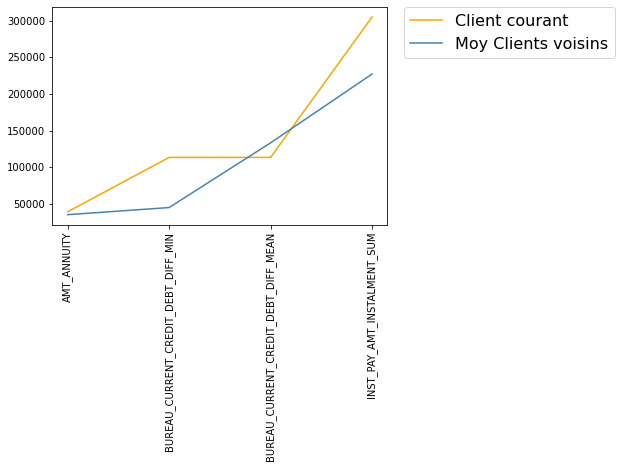

In [154]:
# Lineplot de comparaison des features importances client courant/voisins
plt.figure(figsize=(6, 4))
plt.plot(x_gp1, y_feat_client_gp1, color='Orange',
         label='Client courant')
plt.plot(x_gp1, y_moy_feat_voisins_gp3, color='SteelBlue',
         label='Moy Clients voisins')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
         fontsize=16)
plt.show()

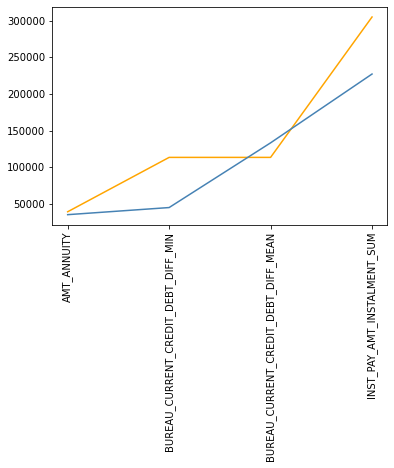

In [155]:
# Lineplot de comparaison des features importances client courant/voisins
plt.figure(figsize=(6, 4))
plt.plot(x_gp1, y_feat_client_gp1, color='Orange')
plt.plot(x_gp1, y_moy_feat_voisins_gp3, color='SteelBlue')
plt.xticks(rotation=90)
plt.show()

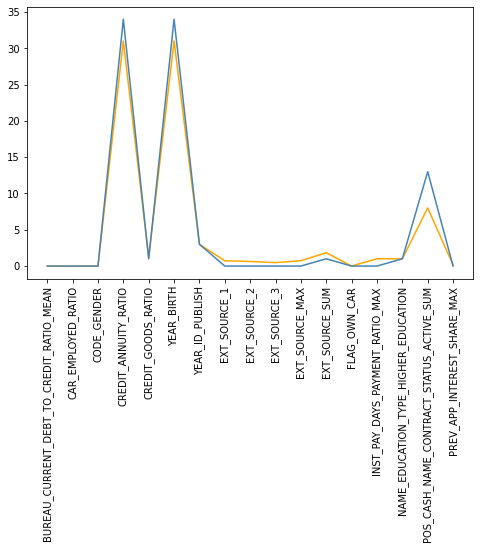

In [156]:
# Lineplot de comparaison des features importances client courant/voisins
plt.figure(figsize=(8, 5))
plt.plot(x_gp2, y_feat_client_gp2, color='Orange')
plt.plot(x_gp2, y_moy_feat_voisins_gp4, color='SteelBlue')
plt.xticks(rotation=90)
plt.show()

**go.Indicator bullets**

In [157]:
# ==============================================================
# Variable AMT_ANNUITY
# Annuité du prêt
# ==============================================================
amt_min = int(df_client.AMT_ANNUITY_MIN.values)
amt_q25 = int(df_client.AMT_ANNUITY_Q25.values)
amt_mean = int(df_client.AMT_ANNUITY_MEAN.values)
amt_q75 = int(df_client.AMT_ANNUITY_Q75.values)
amt_max = int(df_client.AMT_ANNUITY_MAX.values)
amt_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'AMT_ANNUITY'].values)

fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number+gauge+delta",
    value = amt_client,
    delta = {'reference': amt_mean,
             'increasing': {'color': 'Crimson'},
             'decreasing': {'color': 'Green'}},
    domain = {'x': [0.15, 1], 'y': [0.7, 0.9]},
    title = {'text': 'Annuité', 'font': {'size': 12},
             'align' : 'left'},
    gauge = {
        'shape': 'bullet',
        'axis': {'range': [amt_min, amt_max]},
        'threshold': {
            'line': {'color': 'black', 'width': 3},
            'thickness': 0.75,
            'value': amt_client},
        'steps': [
            {'range': [0, amt_min], 'color': 'white'},
            {'range': [amt_min, amt_q25], 'color': 'MediumOrchid'},
            {'range': [amt_q25, amt_mean], 'color': 'Thistle',
             'line': {'color': 'DarkSlateGray', 'width': 2}},
            {'range': [amt_mean, amt_q75],'color': 'Thistle',
             'line': {'color': 'DarkSlateGray', 'width': 2}},
            {'range': [amt_q75, amt_max], 'color': 'MediumOrchid'}],
        'bar': {'color': 'black'}}))

fig.update_layout(height=200,
                  margin={'t':0, 'b':0, 'l':0})

fig.show()

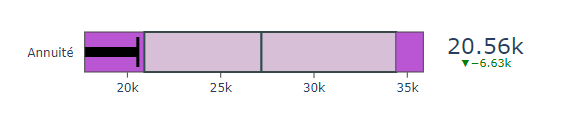

In [158]:
# ==============================================================
# Variable BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN
# Valeur minimum de la différence entre la limite de crédit actuelle
# de la carte de crédit et la dette actuelle sur le crédit
# ==============================================================
bccddm_min = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MIN.values)
bccddm_q25 = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_Q25.values)
bccddm_mean = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN.values)
bccddm_q75 = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_Q75.values)
bccddm_max = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MAX.values)
bccddm_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN'].values)

fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number+gauge+delta",
    value = bccddm_client,
    delta = {'reference': bccddm_mean,
             'increasing': {'color': 'Crimson'},
             'decreasing': {'color': 'Green'}},
    domain = {'x': [0.35, 1], 'y': [0.7, 0.8]},
    title = {'text': 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
             'font': {'size': 9}, 'align' : 'left'},
    gauge = {
        'shape': 'bullet',
        'axis': {'range': [bccddm_min, bccddm_max]},
        'threshold': {
            'line': {'color': 'black', 'width': 3},
            'thickness': 0.75,
            'value': bccddm_client},
        'steps': [
            {'range': [0, bccddm_min], 'color': 'white'},
            {'range': [bccddm_min, bccddm_q25], 'color': 'MediumOrchid'},
            {'range': [bccddm_q25, bccddm_mean], 'color': 'Thistle',
             'line': {'color': 'DarkSlateGray', 'width': 2}},
            {'range': [bccddm_mean, bccddm_q75],'color': 'Thistle',
             'line': {'color': 'DarkSlateGray', 'width': 2}},
            {'range': [bccddm_q75, bccddm_max], 'color': 'MediumOrchid'}],
        'bar': {'color': 'black'}}))

fig.update_layout(height=300, width=700,
                  margin={'t':0, 'b':0, 'l':0})

fig.show()

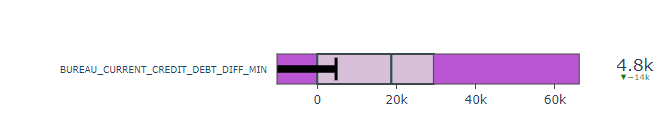

In [159]:
# ==============================================================
# Variable BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN
# Valeur moyenne de la différence entre la limite de crédit actuelle
# de la carte de crédit et la dette actuelle sur le crédit
# ==============================================================
bccddmean_min = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MIN.values)
bccddmean_q25 = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_Q25.values)
bccddmean_mean = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN.values)
bccddmean_q75 = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_Q75.values)
bccddmean_max = int(df_client.BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MAX.values)
bccddmean_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN'].values)

fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number+gauge+delta",
    value = bccddmean_client,
    delta = {'reference': bccddmean_mean,
             'increasing': {'color': 'Crimson'},
             'decreasing': {'color': 'Green'}},
    domain = {'x': [0.4, 1], 'y': [0.7, 0.8]},
    title = {'text': 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
             'font': {'size': 9}, 'align' : 'left'},
    gauge = {
        'shape': 'bullet',
        'axis': {'range': [bccddmean_min, bccddmean_max]},
        'threshold': {
            'line': {'color': 'black', 'width': 3},
            'thickness': 0.75,
            'value': bccddmean_client},
        'steps': [
            {'range': [0, bccddmean_min], 'color': 'white'},
            {'range': [bccddmean_min, bccddmean_q25], 'color': 'MediumOrchid'},
            {'range': [bccddmean_q25, bccddmean_mean], 'color': 'Thistle',
             'line': {'color': 'DarkSlateGray', 'width': 2}},
            {'range': [bccddmean_mean, bccddmean_q75],'color': 'Thistle',
             'line': {'color': 'DarkSlateGray', 'width': 2}},
            {'range': [bccddmean_q75, bccddmean_max], 'color': 'MediumOrchid'}],
        'bar': {'color': 'black'}}))

fig.update_layout(height=300, width=700,
                  margin={'t':0, 'b':0, 'l':0})

fig.show()

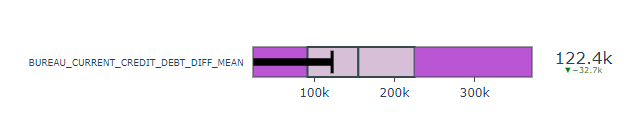

In [160]:
# ==============================================================
# Variable BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN
# Moyenne de du ratio des prêts précédents sur d'autres institution de :
# la dette actuelle sur le crédit et la limite de crédit actuelle de la
# carte de crédit
# ==============================================================
bcdtcrm_min = int(df_client.BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MIN.values*100)
bcdtcrm_q25 = int(df_client.BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_Q25.values*100)
bcdtcrm_mean = int(df_client.BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN.values*100)
bcdtcrm_q75 = int(df_client.BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_Q75.values*100)
bcdtcrm_max = int(df_client.BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MAX.values*100)
bcdtcrm_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN'].values*100)
bcdtcrm_max_axis = max(bcdtcrm_max, bcdtcrm_client)

cond = bcdtcrm_client == bcdtcrm_min and bcdtcrm_min == bcdtcrm_q25 \
    and bcdtcrm_q25 == bcdtcrm_mean and bcdtcrm_mean == bcdtcrm_q75 \
    and bcdtcrm_q75 == bcdtcrm_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = bcdtcrm_client,
        delta = {'reference': bcdtcrm_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.7, 0.8]},
        title = {'text': 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [bcdtcrm_min, bcdtcrm_max_axis]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': bcdtcrm_client},
            'steps': [
                {'range': [0, bcdtcrm_min], 'color': 'white'},
                {'range': [bcdtcrm_min, bcdtcrm_q25], 'color': 'MediumOrchid'},
                {'range': [bcdtcrm_q25, bcdtcrm_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [bcdtcrm_mean, bcdtcrm_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [bcdtcrm_q75, bcdtcrm_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:
    print('Toutes les valeurs sont nulles.')

Toutes les valeurs sont nulles.


In [161]:
# ==============================================================
# Variable CAR_EMPLOYED_RATIO
# Ratio : Âge de la voiture du demandeur / Ancienneté dans l'emploi à la
# date de la demande
# ==============================================================
cer_max = int(df_client.CAR_EMPLOYED_RATIO_MIN.values*1000)
cer_q75 = int(df_client.CAR_EMPLOYED_RATIO_Q25.values*1000)
cer_mean = int(df_client.CAR_EMPLOYED_RATIO_MEAN.values*1000)
cer_q25 = int(df_client.CAR_EMPLOYED_RATIO_Q75.values*1000)
cer_min = int(df_client.CAR_EMPLOYED_RATIO_MAX.values*1000)
cer_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'CAR_EMPLOYED_RATIO'].values*1000)
cer_max_axis = max(cer_max, cer_client)
cer_min_axis = max(cer_min, cer_client)

cond = cer_client == cer_min and cer_min == cer_q25 and \
    cer_q25 == cer_mean and cer_mean == cer_q75 and \
    cer_q75 == cer_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = cer_client,
        delta = {'reference': cer_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.7, 0.8]},
        title = {'text': 'CAR_EMPLOYED_RATIO',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [cer_min_axis, cer_max_axis]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': cer_client},
            'steps': [
                {'range': [0, cer_min], 'color': 'white'},
                {'range': [cer_min, cer_q25], 'color': 'MediumOrchid'},
                {'range': [cer_q25, cer_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [cer_mean, cer_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [cer_q75, cer_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

In [162]:
# ==============================================================
# Variable CODE_GENDER
# Ratio : Âge de la voiture du demandeur / Ancienneté dans l'emploi à la
# date de la demande
# ==============================================================
# Aucun intérêt : 0 ou 1.

In [163]:
# ==============================================================
# Variable CREDIT_ANNUITY_RATIO
# Ratio : montant du crédit du prêt / Annuité de prêt 
# ==============================================================
car_min = int(df_client.CREDIT_ANNUITY_RATIO_MIN.values)
car_q25 = int(df_client.CREDIT_ANNUITY_RATIO_Q25.values)
car_mean = int(df_client.CREDIT_ANNUITY_RATIO_MEAN.values)
car_q75 = int(df_client.CREDIT_ANNUITY_RATIO_Q75.values)
car_max = int(df_client.CREDIT_ANNUITY_RATIO_MAX.values)
car_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'CREDIT_ANNUITY_RATIO'].values)

cond = car_client == car_min and car_min == car_q25 and \
    car_q25 == car_mean and car_mean == car_q75 \
    and car_q75 == car_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = car_client,
        delta = {'reference': car_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.25, 1], 'y': [0.7, 0.8]},
        title = {'text': 'CREDIT_ANNUITY_RATIO',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [car_min, car_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': car_client},
            'steps': [
                {'range': [0, car_min], 'color': 'white'},
                {'range': [car_min, car_q25], 'color': 'MediumOrchid'},
                {'range': [car_q25, car_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [car_mean, car_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [car_q75, car_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

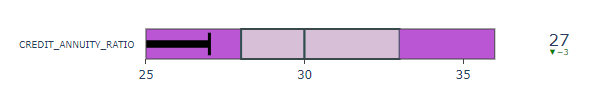

In [164]:
# ==============================================================
# Variable CREDIT_GOODS_RATIO
# Ratio : Montant du crédit du prêt / prix des biens pour lesquels le prêt
# est accordé / Crédit est supérieur au prix des biens ?  
# ==============================================================
cgr_min = int(df_client.CREDIT_GOODS_RATIO_MIN.values)
cgr_q25 = int(df_client.CREDIT_GOODS_RATIO_Q25.values)
cgr_mean = int(df_client.CREDIT_GOODS_RATIO_MEAN.values)
cgr_q75 = int(df_client.CREDIT_GOODS_RATIO_Q75.values)
cgr_max = int(df_client.CREDIT_GOODS_RATIO_MAX.values)
cgr_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'CREDIT_GOODS_RATIO'].values)

cond = cgr_client == cgr_min and cgr_min == cgr_q25 \
    and cgr_q25 == cgr_mean and cgr_mean == cgr_q75 \
    and cgr_q75 == cgr_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = cgr_client,
        delta = {'reference': cgr_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.25, 1], 'y': [0.7, 0.8]},
        title = {'text': 'CREDIT_GOODS_RATIO',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [cgr_min, cgr_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': cgr_client},
            'steps': [
                {'range': [0, cgr_min], 'color': 'white'},
                {'range': [cgr_min, cgr_q25], 'color': 'MediumOrchid'},
                {'range': [cgr_q25, cgr_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [cgr_mean, cgr_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [cgr_q75, cgr_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

Toutes les valeurs sont nulles.


In [165]:
# ==============================================================
# Variable YEAR_BIRTH
# Âge (ans) 
# ==============================================================
age_max = int(-df_client.DAYS_BIRTH_MIN.values/365)
age_q75 = int(-df_client.DAYS_BIRTH_Q25.values/365)
age_mean = int(-df_client.DAYS_BIRTH_MEAN.values/365)
age_q25 = int(-df_client.DAYS_BIRTH_Q75.values/365)
age_min = int(-df_client.DAYS_BIRTH_MAX.values/365)
age_client = int(-df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'DAYS_BIRTH'].values/365)

cond = age_client == age_min and age_min == age_q25 and \
    age_q25 == age_mean and age_mean == age_q75 and age_q75 == age_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = age_client,
        delta = {'reference': age_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.25, 1], 'y': [0.7, 0.8]},
        title = {'text': 'Âge',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [age_min, age_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': age_client},
            'steps': [
                {'range': [0, age_min], 'color': 'white'},
                {'range': [age_min, age_q25], 'color': 'MediumOrchid'},
                {'range': [age_q25, age_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [age_mean, age_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [age_q75, age_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

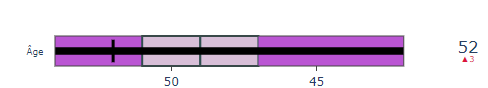

In [166]:
# ==============================================================
# Variable DAYS_ID_PUBLISH
# Combien de jours avant la demande le client a-t-il changé la pièce
# d'identité avec laquelle il a demandé le prêt ? (ans) 
# ==============================================================
dip_max = int(-df_client.DAYS_ID_PUBLISH_MIN.values/365)
dip_q75 = int(-df_client.DAYS_ID_PUBLISH_Q25.values/365)
dip_mean = int(-df_client.DAYS_ID_PUBLISH_MEAN.values/365)
dip_q25 = int(-df_client.DAYS_ID_PUBLISH_Q75.values/365)
dip_min = int(-df_client.DAYS_ID_PUBLISH_MAX.values/365)
dip_client = int(-df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'DAYS_ID_PUBLISH'].values/365)

cond = dip_client == dip_min and dip_min == dip_q25 and \
    dip_q25 == dip_mean and dip_mean == dip_q75 and dip_q75 == dip_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = dip_client,
        delta = {'reference': dip_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.25, 1], 'y': [0.7, 0.8]},
        title = {'text': 'DAYS_ID_PUBLISH',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [dip_min, dip_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': dip_client},
            'steps': [
                {'range': [0, dip_min], 'color': 'white'},
                {'range': [dip_min, dip_q25], 'color': 'MediumOrchid'},
                {'range': [dip_q25, dip_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [dip_mean, dip_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [dip_q75, dip_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

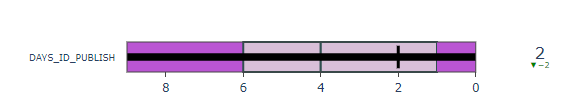

In [167]:
es1_min, es1_q25

NameError: name 'es1_min' is not defined

In [168]:
# ==============================================================
# Variable EXT_SOURCE_1
# Source externe normalisée 
# ==============================================================
es1_min = int(df_client.EXT_SOURCE_1_MIN.values * 100)
es1_q25 = int(df_client.EXT_SOURCE_1_Q25.values * 100)
es1_mean = int(df_client.EXT_SOURCE_1_MEAN.values * 100)
es1_q75 = int(df_client.EXT_SOURCE_1_Q75.values * 100)
es1_max = int(df_client.EXT_SOURCE_1_MAX.values * 100)
es1_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'EXT_SOURCE_1'].values * 100)
es1_axis_min = min(es1_min, es1_client)
es1_axis_max = max(es1_max, es1_client) 

cond = es1_client == es1_min and es1_min == es1_q25 and \
    es1_q25 == es1_mean and es1_mean == es1_q75 and \
    es1_q75 == es1_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = es1_client,
        delta = {'reference': es1_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.7, 0.8]},
        title = {'text': 'EXT_SOURCE_1',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [es1_axis_min, es1_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': es1_client},
            'steps': [
                {'range': [0, es1_min], 'color': 'white'},
                {'range': [es1_min, es1_q25], 'color': 'MediumOrchid'},
                {'range': [es1_q25, es1_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [es1_mean, es1_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [es1_q75, es1_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

In [169]:
# ==============================================================
# Variable EXT_SOURCE_2
# Source externe normalisée 
# ==============================================================
es2_min = int(df_client.EXT_SOURCE_2_MIN.values * 100)
es2_q25 = int(df_client.EXT_SOURCE_2_Q25.values * 100)
es2_mean = int(df_client.EXT_SOURCE_2_MEAN.values * 100)
es2_q75 = int(df_client.EXT_SOURCE_2_Q75.values * 100)
es2_max = int(df_client.EXT_SOURCE_2_MAX.values * 100)
es2_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'EXT_SOURCE_2'].values * 100)
es2_axis_min = min(es2_min, es2_client)
es2_axis_max = max(es2_max, es2_client) 
    
cond = es2_client == es2_min and es2_min == es2_q25 and \
    es2_q25 == es2_mean and es2_mean == es2_q75 and \
    es2_q75 == es2_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = es2_client,
        delta = {'reference': es2_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'EXT_SOURCE_2',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [es2_axis_min, es2_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': es2_client},
            'steps': [
                {'range': [0, es2_min], 'color': 'white'},
                {'range': [es2_min, es2_q25], 'color': 'MediumOrchid'},
                {'range': [es2_q25, es2_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [es2_mean, es2_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [es2_q75, es2_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

In [170]:
# ==============================================================
# Variable EXT_SOURCE_3
# Source externe normalisée 
# ==============================================================
es3_min = int(df_client.EXT_SOURCE_3_MIN.values * 100)
es3_q25 = int(df_client.EXT_SOURCE_3_Q25.values * 100)
es3_mean = int(df_client.EXT_SOURCE_3_MEAN.values * 100)
es3_q75 = int(df_client.EXT_SOURCE_3_Q75.values * 100)
es3_max = int(df_client.EXT_SOURCE_3_MAX.values * 100)
es3_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'EXT_SOURCE_3'].values * 100)
es3_axis_min = min(es3_min, es3_client)
es3_axis_max = max(es3_max, es3_client) 

cond = es3_client == es3_min and es3_min == es3_q25 and \
    es3_q25 == es3_mean and es3_mean == es3_q75 and \
    es3_q75 == es3_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = es3_client,
        delta = {'reference': es3_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'EXT_SOURCE_3',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [es3_axis_min, es3_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': es3_client},
            'steps': [
                {'range': [0, es3_min], 'color': 'white'},
                {'range': [es3_min, es3_q25], 'color': 'MediumOrchid'},
                {'range': [es3_q25, es3_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [es3_mean, es3_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [es3_q75, es3_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

In [171]:
# ==============================================================
# Variable EXT_SOURCE_MAX
# Source externe normalisée 
# ==============================================================
esm_min = int(df_client.EXT_SOURCE_MAX_MIN.values * 100)
esm_q25 = int(df_client.EXT_SOURCE_MAX_Q25.values * 100)
esm_mean = int(df_client.EXT_SOURCE_MAX_MEAN.values * 100)
esm_q75 = int(df_client.EXT_SOURCE_MAX_Q75.values * 100)
esm_max = int(df_client.EXT_SOURCE_MAX_MAX.values * 100)
esm_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'EXT_SOURCE_MAX'].values * 100)
esm_axis_min = min(esm_min, esm_client)
esm_axis_max = max(esm_max, esm_client) 

cond = esm_client == esm_min and esm_min == esm_q25 and \
    esm_q25 == esm_mean and esm_mean == esm_q75 and \
    esm_q75 == esm_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = esm_client,
        delta = {'reference': esm_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'EXT_SOURCE_MAX',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [esm_axis_min, esm_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': esm_client},
            'steps': [
                {'range': [0, esm_min], 'color': 'white'},
                {'range': [esm_min, esm_q25], 'color': 'MediumOrchid'},
                {'range': [esm_q25, esm_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [esm_mean, esm_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [esm_q75, esm_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

In [172]:
# ==============================================================
# Variable EXT_SOURCE_SUM
# Source externe normalisée 
# ==============================================================
ess_min = int(df_client.EXT_SOURCE_SUM_MIN.values * 100)
ess_q25 = int(df_client.EXT_SOURCE_SUM_Q25.values * 100)
ess_mean = int(df_client.EXT_SOURCE_SUM_MEAN.values * 100)
ess_q75 = int(df_client.EXT_SOURCE_SUM_Q75.values * 100)
ess_max = int(df_client.EXT_SOURCE_SUM_MAX.values * 100)
ess_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'EXT_SOURCE_SUM'].values * 100)
ess_axis_min = min(ess_min, ess_client)
ess_axis_max = max(ess_max, ess_client) 

cond = ess_client == ess_min and ess_min == ess_q25 and \
    ess_q25 == ess_mean and ess_mean == ess_q75 and \
    ess_q75 == ess_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = ess_client,
        delta = {'reference': ess_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'EXT_SOURCE_SUM',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [ess_axis_min, ess_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': ess_client},
            'steps': [
                {'range': [0, ess_min], 'color': 'white'},
                {'range': [ess_min, ess_q25], 'color': 'MediumOrchid'},
                {'range': [ess_q25, ess_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [ess_mean, ess_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [ess_q75, ess_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

In [173]:
# ==============================================================
# Variable FLAG_OWN_CAR
# Indicateur si le client possède une voiture
# ==============================================================
# Aucun intérêt : 0 ou 1.

In [176]:
# ==============================================================
# Variable INST_PAY_AMT_INSTALMENT_SUM
# Somme du montant de l'acompte prescrit des crédits précédents sur cet
# acompte
# ==============================================================
ipais_min = int(df_client.INST_PAY_AMT_INSTALMENT_SUM_MIN.values)
ipais_q25 = int(df_client.INST_PAY_AMT_INSTALMENT_SUM_Q25.values)
ipais_mean = int(df_client.INST_PAY_AMT_INSTALMENT_SUM_MEAN.values)
ipais_q75 = int(df_client.INST_PAY_AMT_INSTALMENT_SUM_Q75.values)
ipais_max = int(df_client.INST_PAY_AMT_INSTALMENT_SUM_MAX.values)
ipais_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'INST_PAY_AMT_INSTALMENT_SUM'].values)
ipais_axis_min = min(ipais_min, ipais_client)
ipais_axis_max = max(ipais_max, ipais_client)

cond = ipais_client == ipais_min and ipais_min == ipais_q25 and \
    ipais_q25 == ipais_mean and ipais_mean == ipais_q75 and \
    ipais_q75 == ipais_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = ipais_client,
        delta = {'reference': ipais_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'INST_PAY_AMT_INSTALMENT_SUM',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [ipais_axis_min, ipais_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': ipais_client},
            'steps': [
                {'range': [0, ipais_min], 'color': 'white'},
                {'range': [ipais_min, ipais_q25], 'color': 'MediumOrchid'},
                {'range': [ipais_q25, ipais_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [ipais_mean, ipais_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [ipais_q75, ipais_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

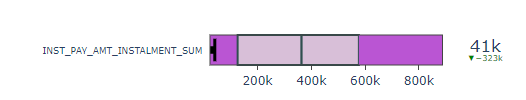

In [177]:
# ==============================================================
# Variable INST_PAY_DAYS_PAYMENT_RATIO_MAX
# Valeur maximal dans l'historique des précédents crédits remboursés
# dans Home Crédit du ratio : La date à laquelle le versement du crédit
# précédent était censé être payé (par rapport à la date de demande du
# prêt actuel) \ Quand les échéances du crédit précédent ont-elles été
# effectivement payées (par rapport à la date de demande du prêt 
# ==============================================================
ipdprm_min = int(df_client.INST_PAY_DAYS_PAYMENT_RATIO_MAX_MIN.values)
ipdprm_q25 = int(df_client.INST_PAY_DAYS_PAYMENT_RATIO_MAX_Q25.values)
ipdprm_mean = int(df_client.INST_PAY_DAYS_PAYMENT_RATIO_MAX_MEAN.values)
ipdprm_q75 = int(df_client.INST_PAY_DAYS_PAYMENT_RATIO_MAX_Q75.values)
ipdprm_max = int(df_client.INST_PAY_DAYS_PAYMENT_RATIO_MAX_MAX.values)
ipdprm_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'INST_PAY_DAYS_PAYMENT_RATIO_MAX'].values)
ipdprm_axis_min = min(ipdprm_min, ipdprm_client)
ipdprm_axis_max = max(ipdprm_max, ipdprm_client)

cond = ipdprm_client == ipdprm_min and ipdprm_min == ipdprm_q25 and \
    ipdprm_q25 == ipdprm_mean and ipdprm_mean == ipdprm_q75 and \
    ipdprm_q75 == ipdprm_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = ipdprm_client,
        delta = {'reference': ipdprm_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [ipdprm_axis_min, ipdprm_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': ipdprm_client},
            'steps': [
                {'range': [0, ipdprm_min], 'color': 'white'},
                {'range': [ipdprm_min, ipdprm_q25], 'color': 'MediumOrchid'},
                {'range': [ipdprm_q25, ipdprm_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [ipdprm_mean, ipdprm_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [ipdprm_q75, ipdprm_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

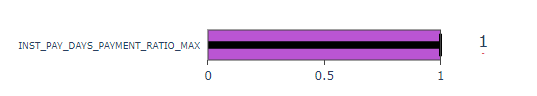

In [178]:
# ==============================================================
# Variable NAME_EDUCATION_TYPE_HIGHER_EDUCATION
# Niveau d'éducation le plus élévé 
# ==============================================================
# Aucun intérêt : 0 ou 1.

In [179]:
# ==============================================================
# Variable NAME_FAMILY_STATUS_MARRIED
# Situation de famille 
# ==============================================================
# Aucun intérêt : 0 ou 1.

In [180]:
# ==============================================================
# Variable POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM
# Somme des contrats actifs au cours du mois 
# ==============================================================
pcncsas_min = int(df_client.POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MIN.values)
pcncsas_q25 = int(df_client.POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_Q25.values)
pcncsas_mean = int(df_client.POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MEAN.values)
pcncsas_q75 = int(df_client.POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_Q75.values)
pcncsas_max = int(df_client.POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MAX.values)
pcncsas_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM'].values)
pcncsas_axis_min = min(pcncsas_min, pcncsas_client)
pcncsas_axis_max = max(pcncsas_max, pcncsas_client)

cond = pcncsas_client == pcncsas_min and pcncsas_min == pcncsas_q25 and \
    pcncsas_q25 == pcncsas_mean and pcncsas_mean == pcncsas_q75 and \
    pcncsas_q75 == pcncsas_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = pcncsas_client,
        delta = {'reference': pcncsas_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [pcncsas_axis_min, pcncsas_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': pcncsas_client},
            'steps': [
                {'range': [0, pcncsas_min], 'color': 'white'},
                {'range': [pcncsas_min, pcncsas_q25], 'color': 'MediumOrchid'},
                {'range': [pcncsas_q25, pcncsas_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [pcncsas_mean, pcncsas_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [pcncsas_q75, pcncsas_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

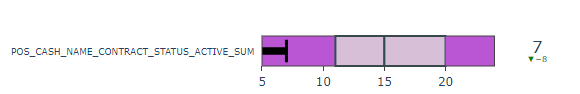

In [181]:
# ==============================================================
# Variable PREV_APP_INTEREST_SHARE_MAX
# La valeur maximale de tous les précédents crédit dans d'autres
# institution : de la durée du crédit multiplié par l'annuité du prêt
# moins le montant final du crédit 
# ==============================================================
paism_min = int(df_client.PREV_APP_INTEREST_SHARE_MAX_MIN.values)
paism_q25 = int(df_client.PREV_APP_INTEREST_SHARE_MAX_Q25.values)
paism_mean = int(df_client.PREV_APP_INTEREST_SHARE_MAX_MEAN.values)
paism_q75 = int(df_client.PREV_APP_INTEREST_SHARE_MAX_Q75.values)
paism_max = int(df_client.PREV_APP_INTEREST_SHARE_MAX_MAX.values)
paism_client = int(df_dashboard[df_dashboard['SK_ID_CURR'] == 250020][
    'PREV_APP_INTEREST_SHARE_MAX'].values)
paism_axis_min = min(paism_min, paism_client)
paism_axis_max = max(paism_max, paism_client)

cond = paism_client == paism_min and paism_min == paism_q25 and \
    paism_q25 == paism_mean and paism_mean == paism_q75 and \
    paism_q75 == paism_max

if not cond:
    fig = go.Figure()

    fig.add_trace(go.Indicator(
        mode = "number+gauge+delta",
        value = paism_client,
        delta = {'reference': paism_mean,
                 'increasing': {'color': 'Crimson'},
                 'decreasing': {'color': 'Green'}},
        domain = {'x': [0.5, 1], 'y': [0.8, 1]},
        title = {'text': 'PREV_APP_INTEREST_SHARE_MAX',
                 'font': {'size': 9}, 'align' : 'left'},
        gauge = {
            'shape': 'bullet',
            'axis': {'range': [paism_axis_min, paism_axis_max]},
            'threshold': {
                'line': {'color': 'black', 'width': 3},
                'thickness': 0.75,
                'value': paism_client},
            'steps': [
                {'range': [0, paism_min], 'color': 'white'},
                {'range': [paism_min, paism_q25], 'color': 'MediumOrchid'},
                {'range': [paism_q25, paism_mean], 'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [paism_mean, paism_q75],'color': 'Thistle',
                 'line': {'color': 'DarkSlateGray', 'width': 2}},
                {'range': [paism_q75, paism_max], 'color': 'MediumOrchid'}],
            'bar': {'color': 'black'}}))

    fig.update_layout(height=300, width=700,
                      margin={'t':0, 'b':0, 'l':0})

    fig.show()
else:    
    print('Toutes les valeurs sont nulles.')

Toutes les valeurs sont nulles.


#### 5.2.2. Dataframe de tous les clients du train set</span>

In [182]:
train_all = train_set.copy(deep=True)

In [183]:
# Ajout YEAR_BIRTH : DAYS_BIRTH en années positives
train_all['YEAR_BIRTH'] = \
    np.trunc(np.abs(train_all['DAYS_BIRTH'] / 365)).astype('int8')

In [184]:
# Ajout YEAR_EMPLOYED : DAYS_EMPLOYED en années positives
train_all['YEAR_EMPLOYED'] = \
    np.trunc(np.abs(train_all['DAYS_EMPLOYED'] / 365)).astype('int8')

In [185]:
# Ajout SEXE : de CODE_GENDER : 0 = Féminin et 1 = Masculin
train_all['SEXE'] = ['Féminin' if row == 0 else 'Masculin'
                     for row in train_all['CODE_GENDER']] 

In [186]:
train_all.columns.to_list()

['SK_ID_CURR',
 'TARGET',
 'CREDIT_ANNUITY_RATIO',
 'PREV_APP_NAME_CONTRACT_STATUS_MEAN',
 'FLAG_DOCUMENT_3',
 'OCCUPATION_TYPE_CORE_STAFF',
 'INST_PAY_DAYS_PAYMENT_DIFF_MIN',
 'DAYS_LAST_PHONE_CHANGE',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN',
 'PREV_APP_AMT_ANNUITY_MIN',
 'CCB_BALANCE_LIMIT_RATIO_MEAN',
 'INST_PAY_AMT_INSTALMENT_MIN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN',
 'ENQ_CREDIT_RATIO',
 'PREV_APP_DAYS_FIRST_DUE_SUM',
 'BUREAU_AMT_CREDIT_SUM_DEBT_SUM',
 'NAME_INCOME_TYPE_WORKING',
 'PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN',
 'INST_PAY_NUM_INSTALMENT_VERSION_SUM',
 'PREV_APP_SELLERPLACE_AREA_MEAN',
 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX',
 'EXT_SOURCE_SUM',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'BUREAU_CREDIT_TYPE_MORTGAGE_MEAN',
 'INST_PAY_AMT_PAYMENT_DIFF_MEAN',
 'REGION_RATING_CLIENT',
 'FLAG_OWN_CAR',
 'FLAGS_DOCUMENTS_SUM',
 'PREV_APP_CNT_PAYMENT_MEAN',
 'PREV_APP_ANNUITY_GOODS_MEAN',
 'P

In [187]:
# Récupération des valeurs min, max, mean pour toutes les variables
# impactantes numériques et mode pour les qualitatives
df_all_train_agg = \
    train_all.groupby(['TARGET']).agg({
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': ['min', 'max', 'mean'],
    'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': ['min', 'max', 'mean'],
    'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': ['min', 'max', 'mean'],
    'CAR_EMPLOYED_RATIO': ['min', 'max', 'mean'],
    'CODE_GENDER': ['min', 'max', 'mean'],
    'CREDIT_ANNUITY_RATIO': ['min', 'max', 'mean'],
    'CREDIT_GOODS_RATIO': ['min', 'max', 'mean'],
    'YEAR_BIRTH': ['min', 'max', 'mean'],
    'YEAR_EMPLOYED': ['min', 'max', 'mean'],
    'DAYS_ID_PUBLISH': ['min', 'max', 'mean'],
    'EXT_SOURCE_1': ['min', 'max', 'mean'],
    'EXT_SOURCE_2': ['min', 'max', 'mean'],
    'EXT_SOURCE_3': ['min', 'max', 'mean'],
    'EXT_SOURCE_MAX': ['min', 'max', 'mean'],
    'EXT_SOURCE_SUM': ['min', 'max', 'mean'],
    'FLAG_OWN_CAR': ['min', 'max', 'mean'],
    'INST_PAY_AMT_INSTALMENT_SUM': ['min', 'max', 'mean'],
    'INST_PAY_DAYS_PAYMENT_RATIO_MAX': ['min', 'max', 'mean'],
    'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': ['min', 'max', 'mean'],
    'PREV_APP_INTEREST_SHARE_MAX': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'SEXE':  lambda x: pd.Series.mode(x)[0]
    })

In [188]:
# Ajout des colonnes sous forme nom_min ou max..
df_all_train_agg.columns = ['_'.join(tup).strip().upper()
                               for tup in df_all_train_agg.columns.values]

In [189]:
# Replace les index multiples comme simples colonnes
df_all_train_agg.reset_index(inplace=True) 

In [190]:
# Sauvegarde des scores de df_all_train_agg
fic_sav_df_all_train_agg = 'sauvegarde/dashboard/df_all_train_agg.pickle'
with open(fic_sav_df_all_train_agg, 'wb') as f:
    pickle.dump(df_all_train_agg, f, pickle.HIGHEST_PROTOCOL)
print(df_all_train_agg.shape)
df_all_train_agg.head(4)

(2, 68)


TARGET  AMT_ANNUITY_MIN  AMT_ANNUITY_MAX  AMT_ANNUITY_MEAN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MIN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MAX  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MIN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MAX  \
0       0           1615.5         258025.5        27163.6289                              -3.8875e+07                               1.4229e+08                                54044.3516                               -1.8121e+07                                1.9807e+08   
1       1           2722.5         149211.0        26481.7441                              -2.3758e+07                               5.9591e+06                                30454.0488                               -2.0200e+06                                7.0498e+06   

   BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MIN  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MAX  BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN  CAR_EMPLOYED_RATIO_MIN  CAR_EMPLOYED_RATIO_MAX  CAR_EMPLOYED_RATIO_MEAN  CODE_GENDER_MIN  CODE_GENDER_MAX  \
0                                193783.9219                                   -1.0375e+11                                    2.2333e+11                                      5343491.5                 -9.0001                900000.0                   3.1723                0                1   
1                                137781.9219                                   -3.7636e+09                                    2.8549e+10                                      8454347.0                -11.5001                900000.0                  36.2386                0                1   

   CODE_GENDER_MEAN  CREDIT_ANNUITY_RATIO_MIN  CREDIT_ANNUITY_RATIO_MAX  CREDIT_ANNUITY_RATIO_MEAN  CREDIT_GOODS_RATIO_MIN  CREDIT_GOODS_RATIO_MAX  CREDIT_GOODS_RATIO_MEAN  YEAR_BIRTH_MIN  YEAR_BIRTH_MAX  YEAR_BIRTH_MEAN  YEAR_EMPLOYED_MIN  YEAR_EMPLOYED_MAX  YEAR_EMPLOYED_MEAN  \
0            0.3340                    6.3242                   59.5625                    21.6875                    0.15                   6.000                   1.1201              20              69          43.7132                  0                 49              5.7798   
1            0.4292                    8.0391                   45.2812                    20.7656                    0.30                   2.666                   1.1514              21              68          40.2800                  0                 44              4.4215   

   DAYS_ID_PUBLISH_MIN  DAYS_ID_PUBLISH_MAX  DAYS_ID_PUBLISH_MEAN  EXT_SOURCE_1_MIN  EXT_SOURCE_1_MAX  EXT_SOURCE_1_MEAN  EXT_SOURCE_2_MIN  EXT_SOURCE_2_MAX  EXT_SOURCE_2_MEAN  EXT_SOURCE_3_MIN  EXT_SOURCE_3_MAX  EXT_SOURCE_3_MEAN  EXT_SOURCE_MAX_MIN  EXT_SOURCE_MAX_MAX  EXT_SOURCE_MAX_MEAN  \
0                -7197                    0            -3017.2193            0.0146            0.9629             0.5083        5.9605e-08             0.855             0.5234            0.0005             0.894             0.5239              0.0601              0.9629               0.6475   
1                -6207                    0            -2732.0996            0.0147            0.9292             0.4578        5.0068e-06             0.812             0.4114            0.0005             0.896             0.4238              0.0330              0.9292               0.5771   

   EXT_SOURCE_SUM_MIN  EXT_SOURCE_SUM_MAX  EXT_SOURCE_SUM_MEAN  FLAG_OWN_CAR_MIN  FLAG_OWN_CAR_MAX  FLAG_OWN_CAR_MEAN  INST_PAY_AMT_INSTALMENT_SUM_MIN  INST_PAY_AMT_INSTALMENT_SUM_MAX  INST_PAY_AMT_INSTALMENT_SUM_MEAN  INST_PAY_DAYS_PAYMENT_RATIO_MAX_MIN  INST_PAY_DAYS_PAYMENT_RATIO_MAX_MAX  \
0              0.1279              2.5605               1.5557                 0                 1             0.6568                            0.000                       2.3275e+07                       659181.5625                               0.1428                  

In [191]:
# Chargement du dataframe df_all_train_agg
fic_sav_df_all_train_agg ='sauvegarde/dashboard/df_all_train_agg.pickle'
with open(fic_sav_df_all_train_agg, 'rb') as df_all_train_agg:
    df_all_train_agg = pickle.load(df_all_train_agg)
df_all_train_agg.shape

(2, 68)

In [192]:
filename =  'sauvegarde/pickle/df_all_train_agg.pickle'
outfile = open(filename,'wb')
pickle.dump(df_all_train_agg, outfile)
outfile.close()

In [193]:
dump(df_all_train_agg,
     'sauvegarde/joblib/df_all_train_agg.joblib', compress=1)

['sauvegarde/joblib/df_all_train_agg.joblib']

In [194]:
# Récupération des valeurs min, max, mean pour toutes les variables
# impactantes numériques et mode pour les qualitatives
df_all_train_bis_agg = \
    application_train.groupby(['TARGET']).agg({
    'CNT_CHILDREN': ['min', 'max', 'mean'],
    'AMT_INCOME_TOTAL': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'NAME_FAMILY_STATUS':  lambda x: pd.Series.mode(x)[0],
    'NAME_EDUCATION_TYPE':  lambda x: pd.Series.mode(x)[0],
    'NAME_INCOME_TYPE':  lambda x: pd.Series.mode(x)[0],
    'NAME_CONTRACT_TYPE':  lambda x: pd.Series.mode(x)[0],
    'NAME_HOUSING_TYPE':  lambda x: pd.Series.mode(x)[0]
    })

In [195]:
# Ajout des colonnes sous forme nom_min ou max..
df_all_train_bis_agg.columns = ['_'.join(tup).strip().upper()
                                for tup in df_all_train_bis_agg.columns.values]

In [196]:
# Replace les index multiples comme simples colonnes
df_all_train_bis_agg.reset_index(inplace=True) 

In [197]:
# Sauvegarde des scores df_voisins_train
fic_sav_df_all_train_bis_agg = 'sauvegarde/dashboard/df_all_train_bis_agg.pickle'
with open(fic_sav_df_all_train_bis_agg, 'wb') as f:
    pickle.dump(df_all_train_bis_agg, f, pickle.HIGHEST_PROTOCOL)
print(df_all_train_bis_agg.shape)
df_all_train_bis_agg.head(4)

(2, 15)


TARGET  CNT_CHILDREN_MIN  CNT_CHILDREN_MAX  CNT_CHILDREN_MEAN  AMT_INCOME_TOTAL_MIN  AMT_INCOME_TOTAL_MAX  AMT_INCOME_TOTAL_MEAN  AMT_GOODS_PRICE_MIN  AMT_GOODS_PRICE_MAX  AMT_GOODS_PRICE_MEAN NAME_FAMILY_STATUS_<LAMBDA>   NAME_EDUCATION_TYPE_<LAMBDA> NAME_INCOME_TYPE_<LAMBDA>  \
0       0                 0                19             0.4129               25650.0            1.8000e+07            169077.4722              40500.0            4050000.0           542738.5068                     Married  Secondary / secondary special                   Working   
1       1                 0                11             0.4638               25650.0            1.1700e+08            165611.7609              45000.0            3600000.0           488972.4126                     Married  Secondary / secondary special                   Working   

  NAME_CONTRACT_TYPE_<LAMBDA> NAME_HOUSING_TYPE_<LAMBDA>  
0                  Cash loans          House / apartment  
1                  Cash loans          House / apartment

In [198]:
# Chargement du dataframe df_all_train_agg
fic_sav_df_all_train_bis_agg ='sauvegarde/dashboard/df_all_train_bis_agg.pickle'
with open(fic_sav_df_all_train_bis_agg, 'rb') as df_all_train_bis_agg:
    df_all_train_bis_agg = pickle.load(df_all_train_bis_agg)
df_all_train_bis_agg.shape

(2, 15)

**Lineplot**

Affiche les valeurs les plus déterminantes sur la prédiction pour :
- le client courant,
- les 10 clients voisins du train set,
- la moyenne pour tous les non-défaillants,
- et la moyenne pour tous les défaillants,

In [199]:
# Exemple id_client = 250020
df_client = \
    df_voisin_train_agg[df_voisin_train_agg['ID_CLIENT'] == 250020].astype(int)

In [200]:
group_val1 = ['AMT_ANNUITY',
              'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
              'INST_PAY_AMT_INSTALMENT_SUM']

In [201]:
group_val2 = ['CAR_EMPLOYED_RATIO', 'CODE_GENDER',
              'CREDIT_ANNUITY_RATIO', 'CREDIT_GOODS_RATIO',
              'YEAR_BIRTH', 'YEAR_ID_PUBLISH',
              'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
              'EXT_SOURCE_MAX', 'EXT_SOURCE_SUM',
              'FLAG_OWN_CAR',
              'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
              'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
              'PREV_APP_INTEREST_SHARE_MAX']

In [202]:
# Valeurs moyennes des features importances pour le client courant
df_client_courant = \
    df_dashboard[df_dashboard['SK_ID_CURR'] == 250020]
df_feat_client  = df_client_courant[['SK_ID_CURR', 'AMT_ANNUITY',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
           'CAR_EMPLOYED_RATIO', 'CODE_GENDER',
           'CREDIT_ANNUITY_RATIO', 'CREDIT_GOODS_RATIO',
           'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
           'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
           'EXT_SOURCE_MAX', 'EXT_SOURCE_SUM',
           'FLAG_OWN_CAR', 'INST_PAY_AMT_INSTALMENT_SUM',
           'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
           'PREV_APP_INTEREST_SHARE_MAX']]
df_feat_client['YEAR_BIRTH'] = \
    np.trunc(np.abs(df_feat_client['DAYS_BIRTH'] / 365)).astype('int8')
df_feat_client['YEAR_ID_PUBLISH'] = \
    np.trunc(np.abs(df_feat_client['DAYS_ID_PUBLISH'] / 365)).astype('int8')
df_feat_client.drop(columns=['DAYS_BIRTH', 'DAYS_ID_PUBLISH'],
                    inplace=True)
df_feat_client_gp1 = df_feat_client[group_val1]
df_feat_client_gp2 = df_feat_client[group_val2]
# X
x_gp1 = df_feat_client_gp1.columns.to_list()
x_gp2 = df_feat_client_gp2.columns.to_list()
# y
y_feat_client_gp1 = df_feat_client_gp1.values[0].tolist()
y_feat_client_gp2 = df_feat_client_gp2.values[0].tolist()

In [203]:
group_val3 = ['AMT_ANNUITY_MEAN',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN',
              'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN',
              'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN',
              'INST_PAY_AMT_INSTALMENT_SUM_MEAN']

In [204]:
group_val4 = ['CAR_EMPLOYED_RATIO_MEAN', 'CODE_GENDER_MEAN',
              'CREDIT_ANNUITY_RATIO_MEAN', 'CREDIT_GOODS_RATIO_MEAN',
              'YEAR_BIRTH_MEAN', 'YEAR_ID_PUBLISH_MEAN',
              'EXT_SOURCE_1_MEAN', 'EXT_SOURCE_2_MEAN', 'EXT_SOURCE_3_MEAN',
              'EXT_SOURCE_MAX_MEAN', 'EXT_SOURCE_SUM_MEAN',
              'FLAG_OWN_CAR_MEAN',
              'INST_PAY_DAYS_PAYMENT_RATIO_MAX_MEAN',
              'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MEAN',
              'PREV_APP_INTEREST_SHARE_MAX_MEAN']

In [205]:
# Valeurs moyennes des features importances pour les 10 voisins
df_moy_feat_voisins = df_client[['ID_CLIENT', 'AMT_ANNUITY_MEAN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN',
           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN',
           'CAR_EMPLOYED_RATIO_MEAN', 'CODE_GENDER_MEAN',
           'CREDIT_ANNUITY_RATIO_MEAN', 'CREDIT_GOODS_RATIO_MEAN',
           'DAYS_BIRTH_MEAN', 'DAYS_ID_PUBLISH_MEAN',
           'EXT_SOURCE_1_MEAN', 'EXT_SOURCE_2_MEAN', 'EXT_SOURCE_3_MEAN',
           'EXT_SOURCE_MAX_MEAN', 'EXT_SOURCE_SUM_MEAN',
           'FLAG_OWN_CAR_MEAN', 'INST_PAY_AMT_INSTALMENT_SUM_MEAN',
           'INST_PAY_DAYS_PAYMENT_RATIO_MAX_MEAN',
           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MEAN',
           'PREV_APP_INTEREST_SHARE_MAX_MEAN']]
df_moy_feat_voisins['YEAR_BIRTH_MEAN'] = \
    np.trunc(np.abs(df_moy_feat_voisins['DAYS_BIRTH_MEAN'] / 365)).astype('int8')
df_moy_feat_voisins['YEAR_ID_PUBLISH_MEAN'] = \
    np.trunc(np.abs(df_moy_feat_voisins['DAYS_ID_PUBLISH_MEAN'] / 365)).astype('int8')
df_moy_feat_voisins.drop(columns=['DAYS_BIRTH_MEAN', 'DAYS_ID_PUBLISH_MEAN'],
                    inplace=True)
df_moy_feat_voisins_gp3 = df_moy_feat_voisins[group_val3]
df_moy_feat_voisins_gp4 = df_moy_feat_voisins[group_val4]
# y
y_moy_feat_voisins_gp3 = df_moy_feat_voisins_gp3.values[0].tolist()
y_moy_feat_voisins_gp4 = df_moy_feat_voisins_gp4.values[0].tolist()

In [206]:
# Valeurs moyennes de tous les clients non-défaillants/défaillants du train sets
df_all_train = df_all_train_agg[['TARGET', 'AMT_ANNUITY_MEAN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN_MEAN',
           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN_MEAN',
           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_MEAN',
           'CAR_EMPLOYED_RATIO_MEAN', 'CODE_GENDER_MEAN',
           'CREDIT_ANNUITY_RATIO_MEAN', 'CREDIT_GOODS_RATIO_MEAN',
           'YEAR_BIRTH_MEAN', 'DAYS_ID_PUBLISH_MEAN',
           'EXT_SOURCE_1_MEAN', 'EXT_SOURCE_2_MEAN', 'EXT_SOURCE_3_MEAN',
           'EXT_SOURCE_MAX_MEAN', 'EXT_SOURCE_SUM_MEAN',
           'FLAG_OWN_CAR_MEAN', 'INST_PAY_AMT_INSTALMENT_SUM_MEAN',
           'INST_PAY_DAYS_PAYMENT_RATIO_MAX_MEAN',
           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM_MEAN',
           'PREV_APP_INTEREST_SHARE_MAX_MEAN']]
df_all_train['YEAR_ID_PUBLISH_MEAN'] = \
    np.trunc(np.abs(df_all_train['DAYS_ID_PUBLISH_MEAN'] / 365)).astype('int8')
df_all_train.drop(columns=['DAYS_ID_PUBLISH_MEAN'],
                    inplace=True)
# Non-défaillants
df_all_train_nondef_gp3 = df_all_train[df_all_train['TARGET'] == 0][group_val3]
df_all_train_nondef_gp4 = df_all_train[df_all_train['TARGET'] == 0][group_val4]
# Défaillants
df_all_train_def_gp3 = df_all_train[df_all_train['TARGET'] == 1][group_val3]
df_all_train_def_gp4 = df_all_train[df_all_train['TARGET'] == 1][group_val4]
# y
# Non-défaillants
y_all_train_nondef_gp3 = df_all_train_nondef_gp3.values[0].tolist()
y_all_train_nondef_gp4 = df_all_train_nondef_gp4.values[0].tolist()
# Défaillants
y_all_train_def_gp3 = df_all_train_def_gp3.values[0].tolist()
y_all_train_def_gp4 = df_all_train_def_gp4.values[0].tolist()

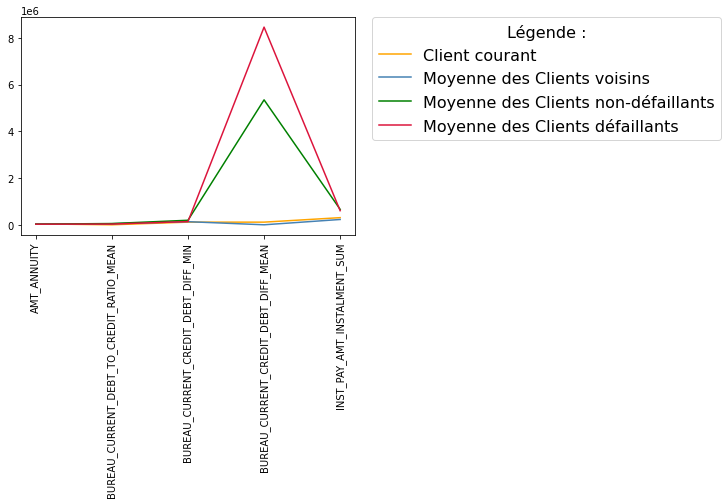

In [207]:
# Lineplot de comparaison des features importances client courant/voisins
plt.figure(figsize=(6, 4))
plt.plot(x_gp1, y_feat_client_gp1, color='Orange',
         label='Client courant')
plt.plot(x_gp1, y_moy_feat_voisins_gp3, color='SteelBlue',
         label='Moyenne des Clients voisins')
plt.plot(x_gp1, y_all_train_nondef_gp3, color='Green',
         label='Moyenne des Clients non-défaillants')
plt.plot(x_gp1, y_all_train_def_gp3, color='Crimson',
         label='Moyenne des Clients défaillants')
plt.xticks(rotation=90)
plt.legend(title='Légende :', title_fontsize=16, 
           bbox_to_anchor=(1.05, 1),
           loc=2, borderaxespad=0., fontsize=16)
plt.show()

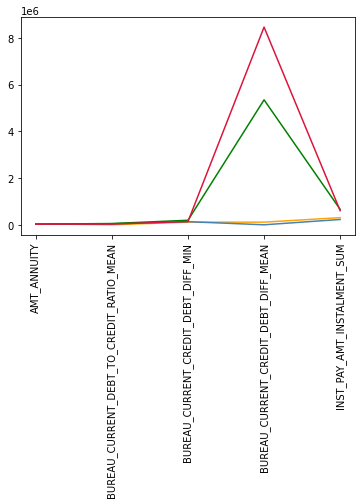

In [208]:
# Lineplot de comparaison des features importances client courant/voisins
plt.figure(figsize=(6, 4))
plt.plot(x_gp1, y_feat_client_gp1, color='Orange')
plt.plot(x_gp1, y_moy_feat_voisins_gp3, color='SteelBlue')
plt.plot(x_gp1, y_all_train_nondef_gp3, color='Green')
plt.plot(x_gp1, y_all_train_def_gp3, color='Crimson')
plt.xticks(rotation=90)
plt.show()

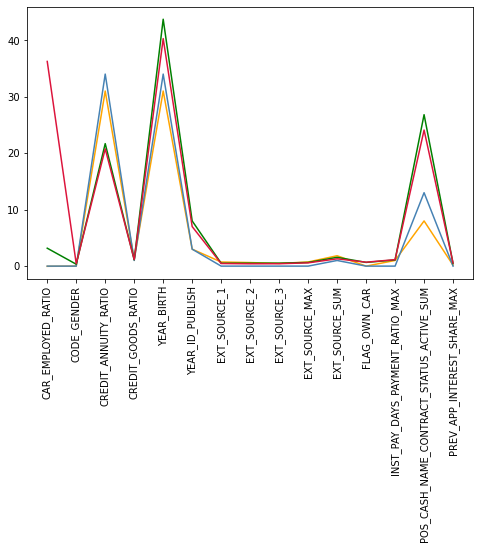

In [209]:
# Lineplot de comparaison des features importances client courant/voisins
plt.figure(figsize=(8, 5))
plt.plot(x_gp2, y_feat_client_gp2, color='Orange')
plt.plot(x_gp2, y_moy_feat_voisins_gp4, color='SteelBlue')
plt.plot(x_gp2, y_all_train_nondef_gp4, color='Green')
plt.plot(x_gp2, y_all_train_def_gp4, color='Crimson')
plt.xticks(rotation=90)
plt.show()

#### 5.2.3. Dataframe de tous les clients du test set</span>

In [210]:
# Les variables les plus déterminantes
feat_imp

['AMT_ANNUITY',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
 'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
 'CAR_EMPLOYED_RATIO',
 'CODE_GENDER',
 'CREDIT_ANNUITY_RATIO',
 'CREDIT_GOODS_RATIO',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_MAX',
 'EXT_SOURCE_SUM',
 'FLAG_OWN_CAR',
 'INST_PAY_AMT_INSTALMENT_SUM',
 'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
 'NAME_FAMILY_STATUS_MARRIED',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
 'PREV_APP_INTEREST_SHARE_MAX']

**YEAR_BIRTH - Âge du client**</span>

**Essai de graphique pour situer le client entre les défaillants/non défaillants**

***Distplot***

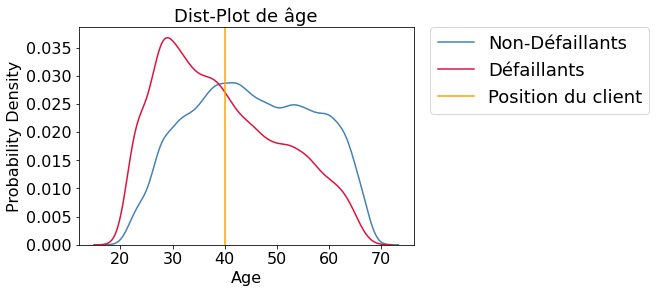

In [211]:
# Non-défaillants
sns.distplot(df_dashboard['YEAR_BIRTH'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 0],
             label='Non-Défaillants', hist=False, color='SteelBlue')
# Défaillants
sns.distplot(df_dashboard['YEAR_BIRTH'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 1],
             label='Défaillants', hist=False, color='Crimson')
plt.xlabel('Age', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Dist-Plot de âge', fontsize=18)
# Position du client
plt.axvline(x=40,color='orange', label='Position du client')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=18)

plt.show()

***Boxplot***

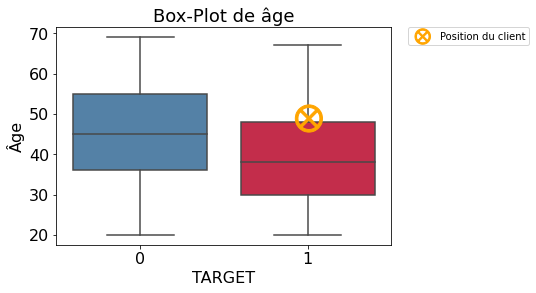

In [212]:
sns.boxplot(x='PRED_CLASSE_CLIENT',
            y='YEAR_BIRTH',
            data=df_dashboard,
            palette=['SteelBlue', 'Crimson'])
plt.title("Box-Plot de âge", fontsize=18)
plt.xlabel('TARGET', fontsize=16)
plt.ylabel('Âge', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

df_client = df_dashboard.iloc[1]
plt.plot(df_client['PRED_CLASSE_CLIENT'],
         df_client['YEAR_BIRTH'],
         color="orange",
         marker="$\\bigotimes$", markersize=28)
import matplotlib.lines as mlines
client = mlines.Line2D([], [], color='orange', marker='$\\bigotimes$',
                       linestyle='None',
                       markersize=16, label='Position du client')
plt.legend(handles=[client],
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

***ViolinPlot***

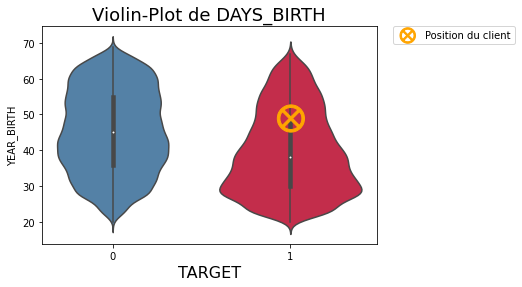

In [213]:
sns.violinplot(x='PRED_CLASSE_CLIENT', y='YEAR_BIRTH',
               data=df_dashboard,
               palette=['SteelBlue', 'Crimson'])
plt.title("Violin-Plot de DAYS_BIRTH", fontsize=18)
df_client = df_dashboard.iloc[1]
plt.plot(df_client['PRED_CLASSE_CLIENT'],
         df_client['YEAR_BIRTH'],
         color="orange",
         marker="$\\bigotimes$", markersize=28)
plt.xlabel('TARGET', fontsize=16)
client = mlines.Line2D([], [], color='orange', marker='$\\bigotimes$',
                       linestyle='None',
                       markersize=16, label='Position du client')
plt.legend(handles=[client], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

**AMT_ANNUITY -Annuité du prêt**</span>

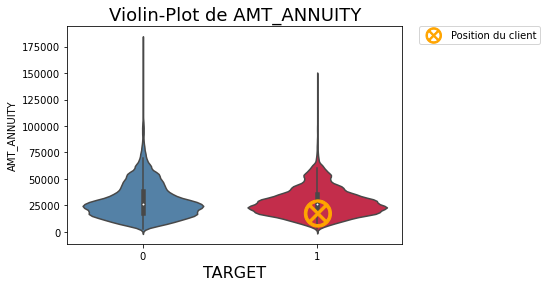

In [214]:
sns.violinplot(x='PRED_CLASSE_CLIENT', y='AMT_ANNUITY',
               data=df_dashboard,
               palette=['SteelBlue', 'Crimson'])
plt.title("Violin-Plot de AMT_ANNUITY", fontsize=18)
df_client = df_dashboard.iloc[1]
plt.plot(df_client['PRED_CLASSE_CLIENT'],
         df_client['AMT_ANNUITY'],
         color="orange",
         marker="$\\bigotimes$", markersize=28)
plt.xlabel('TARGET', fontsize=16)
client = mlines.Line2D([], [], color='orange', marker='$\\bigotimes$',
                       linestyle='None',
                       markersize=16, label='Position du client')
plt.legend(handles=[client], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

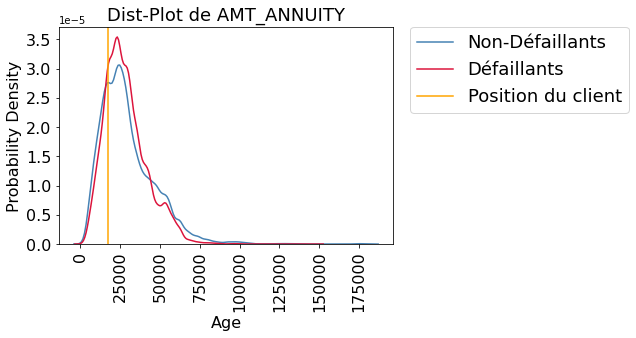

In [215]:
# Non-défaillants
sns.distplot(df_dashboard['AMT_ANNUITY'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 0],
             label='Non-Défaillants', hist=False, color='SteelBlue')
# Défaillants
sns.distplot(df_dashboard['AMT_ANNUITY'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 1],
             label='Défaillants', hist=False, color='Crimson')
plt.xlabel('Age', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.title('Dist-Plot de AMT_ANNUITY', fontsize=18)
# Position du client
plt.axvline(x=df_client['AMT_ANNUITY'], color='orange', label='Position du client')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=18)

plt.show()

**BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN**</span>

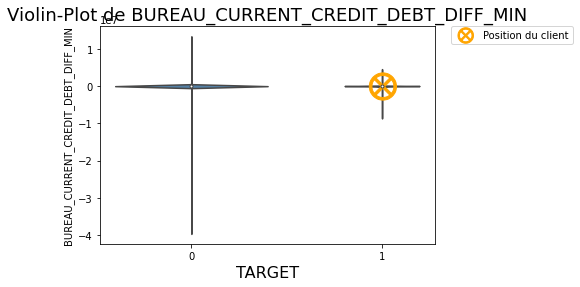

In [216]:
sns.violinplot(x='PRED_CLASSE_CLIENT', y='BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
               data=df_dashboard,
               palette=['SteelBlue', 'Crimson'])
plt.title("Violin-Plot de BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN", fontsize=18)
df_client = df_dashboard.iloc[1]
plt.plot(df_client['PRED_CLASSE_CLIENT'],
         df_client['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN'],
         color="orange",
         marker="$\\bigotimes$", markersize=28)
plt.xlabel('TARGET', fontsize=16)
client = mlines.Line2D([], [], color='orange', marker='$\\bigotimes$',
                       linestyle='None',
                       markersize=16, label='Position du client')
plt.legend(handles=[client], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

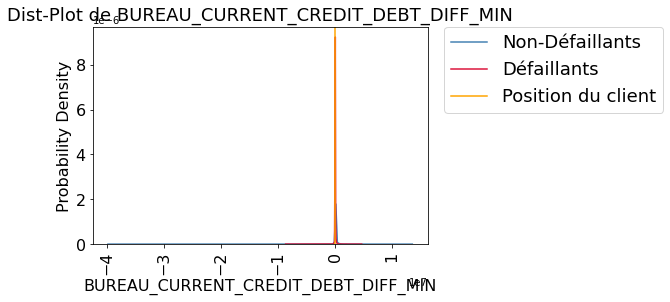

In [217]:
# Non-défaillants
sns.distplot(df_dashboard['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 0],
             label='Non-Défaillants', hist=False, color='SteelBlue')
# Défaillants
sns.distplot(df_dashboard['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 1],
             label='Défaillants', hist=False, color='Crimson')
plt.xlabel('BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.title('Dist-Plot de BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN', fontsize=18)
# Position du client
plt.axvline(x=df_client['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN'], color='orange', label='Position du client')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=18)

plt.show()

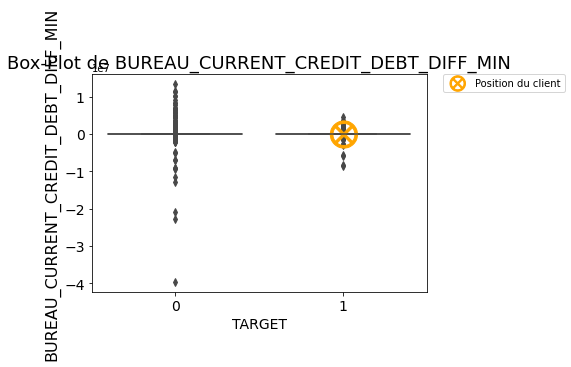

In [218]:
sns.boxplot(x='PRED_CLASSE_CLIENT',
            y='BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
            data=df_dashboard,
            palette=['SteelBlue', 'Crimson'])
plt.title("Box-Plot de BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN", fontsize=18)
plt.xlabel('TARGET', fontsize=14)
plt.ylabel('BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

df_client = df_dashboard.iloc[1]
plt.plot(df_client['PRED_CLASSE_CLIENT'],
         df_client['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN'],
         color="orange",
         marker="$\\bigotimes$", markersize=28)
import matplotlib.lines as mlines
client = mlines.Line2D([], [], color='orange', marker='$\\bigotimes$',
                       linestyle='None',
                       markersize=16, label='Position du client')
plt.legend(handles=[client],
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### 5.3. Score du client</span>

**Prédiction pour un client**

In [225]:
features_selctions=['SK_ID_CURR','CREDIT_ANNUITY_RATIO',
 'PREV_APP_AMT_ANNUITY_MEAN',
 'PREV_APP_DAYS_FIRST_DUE_SUM',
 'PREV_APP_AMT_ANNUITY_MIN',
 'PREV_APP_INTEREST_SHARE_MEAN',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN',
 'BUREAU_AMT_CREDIT_SUM_SUM',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_DOCUMENT_3',
 'EXT_SOURCE_SUM',
 'INST_PAY_DAYS_PAYMENT_DIFF_MIN',
 'PREV_APP_NAME_CONTRACT_STATUS_MEAN',
 'BUREAU_DAYS_CREDIT_MEAN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN',
 'INST_PAY_AMT_PAYMENT_RATIO_MEAN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN',
 'FLAGS_DOCUMENTS_SUM',
 'INST_PAY_AMT_INSTALMENT_MIN',
 'ENQ_CREDIT_RATIO',
 'NAME_INCOME_TYPE_WORKING',
 'BUREAU_CREDIT_TYPE_MORTGAGE_MEAN',
 'INST_PAY_DAYS_INSTALMENT_MAX',
 'PREV_APP_AMT_DOWN_PAYMENT_MEAN',
 'POS_CASH_SK_DPD_DEF_MEAN',
 'NAME_FAMILY_STATUS_MARRIED',
 'FLAG_OWN_CAR',
 'PREV_APP_CNT_PAYMENT_MEAN',
 'OWN_CAR_AGE',
 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
 'INST_PAY_AMT_PAYMENT_DIFF_MEAN',
 'REGION_RATING_CLIENT',
 'NAME_INCOME_TYPE_STATE_SERVANT',
 'YEARS_BEGINEXPLUATATION_AVG',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'CCB_BALANCE_LIMIT_RATIO_MEAN',
 'PREV_APP_SELLERPLACE_AREA_MEAN',
 'PREV_APP_ANNUITY_GOODS_MEAN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
 'OCCUPATION_TYPE_CORE_STAFF',
 'EXT_SOURCE_VAR',
 'INST_PAY_NUM_INSTALMENT_VERSION_SUM',
 'INST_PAY_DAYS_PAYMENT_RATIO_MEAN',
 'AMT_CREDIT',
 'BUREAU_AMT_CREDIT_SUM_DEBT_SUM',
 'ANNUITY_INCOME_RATIO',
 'CAR_EMPLOYED_RATIO',
 'BUREAU_AMT_CREDIT_SUM_MEAN',
 'INST_PAY_AMT_INSTALMENT_SUM',
 'EXT_SOURCE_3',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
 'DAYS_ID_PUBLISH',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
 'EXT_SOURCE_2',
 'CREDIT_GOODS_RATIO',
 'EXT_SOURCE_1',
 'PREV_APP_INTEREST_SHARE_MAX',
 'AMT_ANNUITY',
 'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
 'DAYS_BIRTH',
 'PREV_APP_DAYS_LAST_DUE_MAX',
 'DAYS_EMPLOYED',
 'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
 'CODE_GENDER',
 'PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX',
 'INST_PAY_DAYS_PAYMENT_RATIO_MIN',
 'CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'REGION_POPULATION_RELATIVE',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
 'BUREAU_DAYS_CREDIT_MAX',
 'DAYS_LAST_PHONE_CHANGE',
 'PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN',
 'EXT_SOURCE_MAX',
 'INST_PAY_AMT_INSTALMENT_MAX',
 'DAYS_REGISTRATION',
 'POS_CASH_CNT_INSTALMENT_MEAN',
 'INST_PAY_DAYS_INSTALMENT_MIN',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'FLAG_WORK_PHONE',
 'PREV_APP_INTEREST_SHARE_MIN',
 'PREV_APP_AMT_DECLINED_SUM',
 'CCB_CNT_DRAWINGS_CURRENT_SUM',
 'PREV_APP_CODE_REJECT_REASON_XAP_MEAN',
 'BUREAU_CREDIT_TYPE_MICROLOAN_MEAN',
 'PREV_APP_NAME_TYPE_SUITE_UNACCOMPANIED_MEAN',
 'FLOORSMAX_AVG',
 'BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT',
 'INST_PAY_AMT_INSTALMENT_MEAN',
 'APARTMENTS_AVG',
 'PREV_APP_HOUR_APPR_PROCESS_START_MEAN',
 'INCOME_GOODS_DIFF',
 'PREV_APP_INTEREST_RATE_MAX',
 'CREDIT_INCOME_RATIO',
 'PREV_APP_DAYS_DECISION_MAX',
 'PREV_APP_DAYS_DECISION_MEAN',
 'PREV_APP_AMT_INTEREST_MEAN',
 'PREV_APP_LOAN_RATE_MEAN',
 'PREV_APP_AMT_ANNUITY_SUM',
 'INST_PAY_NUM_INSTALMENT_NUMBER_MAX',
 'INCOME_EXT_RATIO',
 'INST_PAY_DAYS_PAYMENT_DIFF_MEAN',
 'BUREAU_DAYS_CREDIT_LAST',
 'INST_PAY_NUM_INSTALMENT_VERSION_MEAN',
 'PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN',
 'INST_PAY_DAYS_PAYMENT_DIFF_MAX']

In [226]:
# Copie du jeu de test
X_test_scoring = test_set.copy(deep=True)
X_test_scoring = X_test_scoring.merge(V_value, how='left', left_index=True, right_index=True)
X_test_scoring.reset_index()
# features_selctions2: ajout de SK_ID_CURR
X_test_scoring=X_test_scoring[features_selctions]
X_test_scoring

SK_ID_CURR  CREDIT_ANNUITY_RATIO  PREV_APP_AMT_ANNUITY_MEAN  PREV_APP_DAYS_FIRST_DUE_SUM  PREV_APP_AMT_ANNUITY_MIN  PREV_APP_INTEREST_SHARE_MEAN  POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN  BUREAU_AMT_CREDIT_SUM_SUM  REG_CITY_NOT_LIVE_CITY  FLAG_DOCUMENT_3  EXT_SOURCE_SUM  \
0          100001               27.6719                  3951.0000                      -1709.0                 3951.0000                        0.3289                                     0.7778                 1.4534e+06                       0                1          1.7012   
1          100005               12.8281                  4813.2002                       -706.0                 4813.2002                        0.4385                                     0.8184                 6.5713e+05                       0                1          1.2891   
2          100013                9.5078                 11478.1953                      -3016.0                 4742.4150                        0.3884                                     0.8887                 2.0723e+06                       0                0          1.8184   
3          100028               32.1250                  8091.5850                      -3812.0                 6028.0200                       -0.2394                                     0.9355                 1.5209e+06                       0                1          1.6484   
4          100038               19.5000                 17782.1562                       -787.0                11100.5996                        0.5850                                     0.9229                 1.0906e+06                       0                1          1.1465   
...           ...                   ...                        ...                          ...                       ...                           ...                                        ...                        ...                     ...              ...             ...   
48739      456221               23.6094                 14222.4297                       -653.0                14222.4297                        0.3401                                     0.7500                 1.1188e+06                       0                0          1.7988   
48740      456222               19.5000                  6968.8911                      -6080.0                 3653.9551                        0.3596                                     0.9458                 1.0906e+06                       0                1          1.7109   
48741      456223                9.4844                 14201.0781                       -847.0                12640.9502                        0.1830                                     0.9355                 2.1563e+06                       0                1          1.6504   
48742      456224               17.9062                 11486.2158                      -2818.0                 5519.9248                        0.3540                                     0.9355                 3.8487e+06                       0                1          1.4141   
48743      456250               12.6562                 17711.5684                      -2348.0                 7847.6851                        0.1068                                     0.9331                 3.0865e+06                       0                1          1.2354   

       INST_PAY_DAYS_PAYMENT_DIFF_MIN  PREV_APP_NAME_CONTRACT_STATUS_MEAN  BUREAU_DAYS_CREDIT_MEAN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN  INST_PAY_AMT_PAYMENT_RATIO_MEAN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN  FLAGS_DOCUMENTS_SUM  INST_PAY_AMT_INSTALMENT_MIN  ENQ_CREDIT_RATIO  \
0                               -10.0                              0.0000                 -735.000                               0.9578                           1.0000                                0.9578                    1                    3951.0000        0.0000e+00   
1                                -1.0                             

In [227]:
# Sélection des variables du clients
client_id = 250020
X_test_client = X_test_scoring[X_test_scoring['SK_ID_CURR'] == client_id]
X_test_client

SK_ID_CURR  CREDIT_ANNUITY_RATIO  PREV_APP_AMT_ANNUITY_MEAN  PREV_APP_DAYS_FIRST_DUE_SUM  PREV_APP_AMT_ANNUITY_MIN  PREV_APP_INTEREST_SHARE_MEAN  POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN  BUREAU_AMT_CREDIT_SUM_SUM  REG_CITY_NOT_LIVE_CITY  FLAG_DOCUMENT_3  EXT_SOURCE_SUM  \
20675      250020                  31.0                 14060.5879                       -909.0                11246.1748                       -0.4187                                     0.7271                   113400.0                       0                1          1.8389   

       INST_PAY_DAYS_PAYMENT_DIFF_MIN  PREV_APP_NAME_CONTRACT_STATUS_MEAN  BUREAU_DAYS_CREDIT_MEAN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN  INST_PAY_AMT_PAYMENT_RATIO_MEAN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN  FLAGS_DOCUMENTS_SUM  INST_PAY_AMT_INSTALMENT_MIN  ENQ_CREDIT_RATIO  \
20675                             0.0                              0.6665                   -290.0                                  1.0                              1.0                                   1.0                    1                          6.3        4.1127e-06   

       NAME_INCOME_TYPE_WORKING  BUREAU_CREDIT_TYPE_MORTGAGE_MEAN  INST_PAY_DAYS_INSTALMENT_MAX  PREV_APP_AMT_DOWN_PAYMENT_MEAN  POS_CASH_SK_DPD_DEF_MEAN  NAME_FAMILY_STATUS_MARRIED  FLAG_OWN_CAR  PREV_APP_CNT_PAYMENT_MEAN  OWN_CAR_AGE  NAME_EDUCATION_TYPE_HIGHER_EDUCATION  \
20675                       0.0                               0.0                         -17.0                             0.0                       0.0                         1.0             0                        6.0         25.0                                   1.0   

       INST_PAY_AMT_PAYMENT_DIFF_MEAN  REGION_RATING_CLIENT  NAME_INCOME_TYPE_STATE_SERVANT  YEARS_BEGINEXPLUATATION_AVG  DEF_30_CNT_SOCIAL_CIRCLE  CCB_BALANCE_LIMIT_RATIO_MEAN  PREV_APP_SELLERPLACE_AREA_MEAN  PREV_APP_ANNUITY_GOODS_MEAN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX  \
20675                             0.0                     2                             1.0                         0.98                       0.0                        0.9281                         27.6667                   1.6852e+10                                  1.0   

       BUREAU_AMT_CREDIT_SUM_DEBT_MEAN  OCCUPATION_TYPE_CORE_STAFF  EXT_SOURCE_VAR  INST_PAY_NUM_INSTALMENT_VERSION_SUM  INST_PAY_DAYS_PAYMENT_RATIO_MEAN  AMT_CREDIT  BUREAU_AMT_CREDIT_SUM_DEBT_SUM  ANNUITY_INCOME_RATIO  CAR_EMPLOYED_RATIO  BUREAU_AMT_CREDIT_SUM_MEAN  INST_PAY_AMT_INSTALMENT_SUM  \
20675                              0.0                         1.0          0.0108                                  9.0                            0.9321   1212975.0                             0.0                0.1932             -0.0358                    113400.0                  305171.9688   

       EXT_SOURCE_3  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN  DAYS_ID_PUBLISH  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN  EXT_SOURCE_2  CREDIT_GOODS_RATIO  EXT_SOURCE_1  PREV_APP_INTEREST_SHARE_MAX  AMT_ANNUITY  INST_PAY_DAYS_PAYMENT_RATIO_MAX  DAYS_BIRTH  PREV_APP_DAYS_LAST_DUE_MAX  DAYS_EMPLOYED  \
20675        0.4775                              113400.0            -1257                             113400.0        0.6304              1.1982        0.7305                       0.1628      39127.5                              1.0      -11578                      -409.0         -698.0   

       BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN  CODE_GENDER  PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN  BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX  INST_PAY_DAYS_PAYMENT_RATIO_MIN  CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN  REGION_POPULATION_RELATIVE  POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM  \
20675                                       0.0            0                                         390.6987                                0.0                           0.6294                                0.3                       0.005                                       8.0   

       BUREA

In [228]:
# Score des prédictions de probabiltés
y_proba = best_model.predict_proba(X_test_client.drop('SK_ID_CURR', axis=1))[:, 1]

In [229]:
# Score du client en pourcentage arrondi et nombre entier
y_proba_client = int(np.rint(y_proba * 100))
y_proba_client

22

**Jauge pour le score du client**

[Source_plotly_jauge](https://plotly.com/python/gauge-charts/)

In [230]:
fig = go.Figure(go.Indicator(
    mode = 'gauge+number+delta',
    # Score du client en % df_dashboard['SCORE_CLIENT_%']
    value = y_proba_client,  
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text': 'Crédit score du client', 'font': {'size': 24}},
    # Score des 10 voisins test set
    # df_dashboard['SCORE_10_VOISINS_MEAN_TEST']
    delta = {'reference': 76,
             'increasing': {'color': 'Crimson'},
             'decreasing': {'color': 'Green'}},
    gauge = {'axis': {'range': [None, 100],
                      'tickwidth': 3,
                      'tickcolor': 'darkblue'},
             'bar': {'color': 'white', 'thickness' : 0.25},
             'bgcolor': 'white',
             'borderwidth': 2,
             'bordercolor': 'gray',
             'steps': [{'range': [0, 25], 'color': 'Green'},
                       {'range': [25, 49.49], 'color': 'LimeGreen'},
                       {'range': [49.5, 50.5], 'color': 'red'},
                       {'range': [50.51, 75], 'color': 'Orange'},
                       {'range': [75, 100], 'color': 'Crimson'}],
             'threshold': {'line': {'color': 'white', 'width': 10},
                           'thickness': 0.8,
                           # Score du client en %
                           # df_dashboard['SCORE_CLIENT_%']
                           'value': y_proba_client}}))

fig.update_layout(paper_bgcolor='white',
                  height=400, width=600,
                  font={'color': 'darkblue', 'family': 'Arial'})

fig.show()

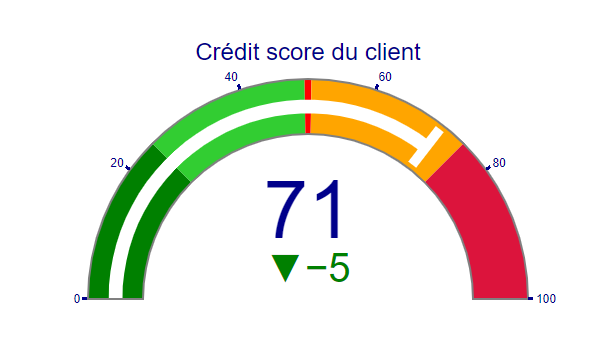

### 5.4. SHAP Values</span>

In [359]:
# Test set sans l'identifiant
X_test=X_test_scoring.copy()
X_test = X_test.set_index('SK_ID_CURR')

In [360]:
X_test

CREDIT_ANNUITY_RATIO  PREV_APP_AMT_ANNUITY_MEAN  PREV_APP_DAYS_FIRST_DUE_SUM  PREV_APP_AMT_ANNUITY_MIN  PREV_APP_INTEREST_SHARE_MEAN  POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN  BUREAU_AMT_CREDIT_SUM_SUM  REG_CITY_NOT_LIVE_CITY  FLAG_DOCUMENT_3  EXT_SOURCE_SUM  \
SK_ID_CURR                                                                                                                                                                                                                                                                        
100001                   27.6719                  3951.0000                      -1709.0                 3951.0000                        0.3289                                     0.7778                 1.4534e+06                       0                1          1.7012   
100005                   12.8281                  4813.2002                       -706.0                 4813.2002                        0.4385                                     0.8184                 6.5713e+05                       0                1          1.2891   
100013                    9.5078                 11478.1953                      -3016.0                 4742.4150                        0.3884                                     0.8887                 2.0723e+06                       0                0          1.8184   
100028                   32.1250                  8091.5850                      -3812.0                 6028.0200                       -0.2394                                     0.9355                 1.5209e+06                       0                1          1.6484   
100038                   19.5000                 17782.1562                       -787.0                11100.5996                        0.5850                                     0.9229                 1.0906e+06                       0                1          1.1465   
...                          ...                        ...                          ...                       ...                           ...                                        ...                        ...                     ...              ...             ...   
456221                   23.6094                 14222.4297                       -653.0                14222.4297                        0.3401                                     0.7500                 1.1188e+06                       0                0          1.7988   
456222                   19.5000                  6968.8911                      -6080.0                 3653.9551                        0.3596                                     0.9458                 1.0906e+06                       0                1          1.7109   
456223                    9.4844                 14201.0781                       -847.0                12640.9502                        0.1830                                     0.9355                 2.1563e+06                       0                1          1.6504   
456224                   17.9062                 11486.2158                      -2818.0                 5519.9248                        0.3540                                     0.9355                 3.8487e+06                       0                1          1.4141   
456250                   12.6562                 17711.5684                      -2348.0                 7847.6851                        0.1068                                     0.9331                 3.0865e+06                       0                1          1.2354   

            INST_PAY_DAYS_PAYMENT_DIFF_MIN  PREV_APP_NAME_CONTRACT_STATUS_MEAN  BUREAU_DAYS_CREDIT_MEAN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN  INST_PAY_AMT_PAYMENT_RATIO_MEAN  PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN  FLAGS_DOCUMENTS_SUM  INST_PAY_AMT_INSTALMENT_MIN  ENQ_CREDIT_RATIO  \
SK_ID_CURR                                                                                                                                               

In [361]:
# Entraînement de shap sur le train set
shap_explainer = shap.Explainer(best_model, X_test)
shap_values = shap_explainer(X_test, check_additivity=False)

100%|===================| 48592/48744 [02:18<00:00]        

In [362]:
# Sauvegarde du shap explainer
filename = 'sauvegarde/shap/shap_explainer.pickle'
outfile = open(filename,'wb')
pickle.dump(shap_explainer, outfile)
outfile.close()

In [363]:
# Sauvegarde des shap values 
filename = 'sauvegarde/shap/shap_values.pickle'
outfile = open(filename,'wb')
pickle.dump(shap_values, outfile)
outfile.close()

In [364]:
shap_values

.values =
array([[-2.79040790e-02,  1.38675406e-02, -1.34894998e-03, ...,
         3.73266273e-03,  3.61758412e-05, -6.05875328e-04],
       [ 8.19811687e-02,  2.10799590e-02,  5.29451075e-03, ...,
         4.09037843e-03,  6.94524585e-04, -5.11287637e-04],
       [-2.01894110e-01,  1.18314002e-02, -2.05519882e-02, ...,
         7.90840224e-04, -4.94286930e-04, -6.25049956e-04],
       ...,
       [-2.68713528e-01, -3.60191526e-03,  1.06035392e-02, ...,
         9.38176652e-04,  6.62967889e-05,  4.54251406e-03],
       [ 4.29425925e-02,  8.32858834e-03, -6.89151366e-03, ...,
         4.08522645e-04, -3.07471943e-04, -6.53426251e-04],
       [ 2.36626781e-01, -3.66795384e-02,  1.27045205e-02, ...,
         1.02414580e-03, -2.22926969e-04, -1.03177683e-03]])

.base_values =
array([-0.48093928, -0.48093928, -0.48093928, ..., -0.48093928,
       -0.48093928, -0.48093928])

.data =
array([[ 2.76718750e+01,  3.95100000e+03, -1.70900000e+03, ...,
         1.14257812e+00,  1.07980383e+03,  3.6

In [365]:
# SHAP values
shap_values.values.shape

(48744, 106)

In [366]:
# Données X_test
shap_values.data

array([[ 2.76718750e+01,  3.95100000e+03, -1.70900000e+03, ...,
         1.14257812e+00,  1.07980383e+03,  3.60000000e+01],
       [ 1.28281250e+01,  4.81320020e+03, -7.06000000e+02, ...,
         1.11132812e+00,  6.02939026e+02,  3.70000000e+01],
       [ 9.50781250e+00,  1.14781953e+04, -3.01600000e+03, ...,
         2.77343750e-01, -1.12057164e+05,  3.80000000e+01],
       ...,
       [ 9.48437500e+00,  1.42010781e+04, -8.47000000e+02, ...,
         1.12500000e+00,  1.00133374e+03,  7.60000000e+01],
       [ 1.79062500e+01,  1.14862158e+04, -2.81800000e+03, ...,
         1.00000000e+00, -5.62487939e+03,  1.60000000e+01],
       [ 1.26562500e+01,  1.77115684e+04, -2.34800000e+03, ...,
         5.40039062e-01, -1.06180891e+05,  3.00000000e+01]], dtype=float32)

In [367]:
# Seuil de décision
shap_values.base_values

array([-0.48093928, -0.48093928, -0.48093928, ..., -0.48093928,
       -0.48093928, -0.48093928])

**Graphiques Globaux**

***BarPlot***

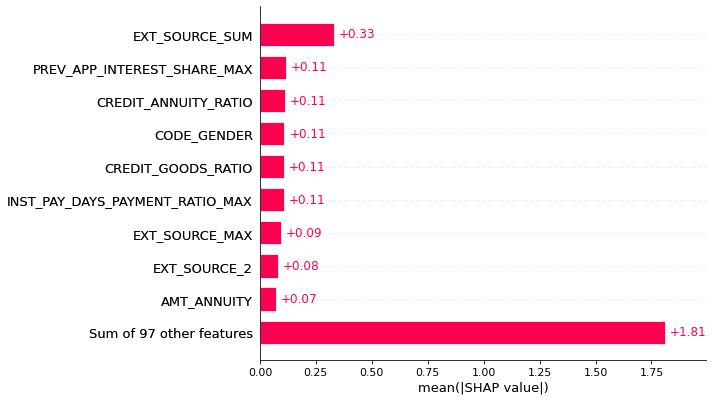

In [368]:
shap.plots.bar(shap_values)

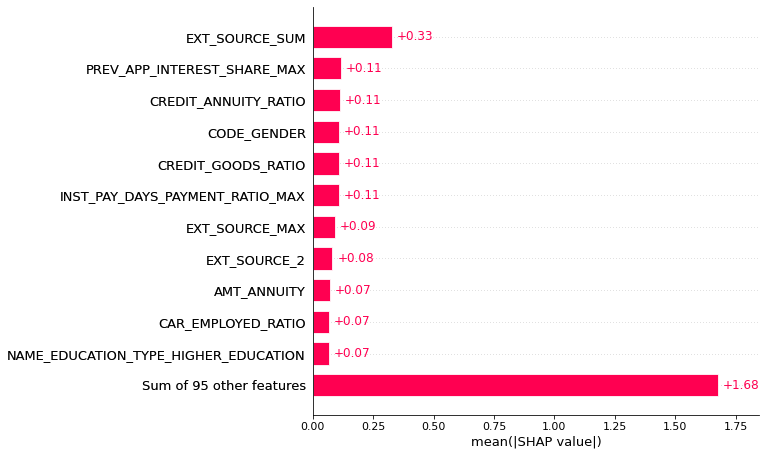

In [369]:
shap.plots.bar(shap_values, max_display=12)

***Beeswarm***

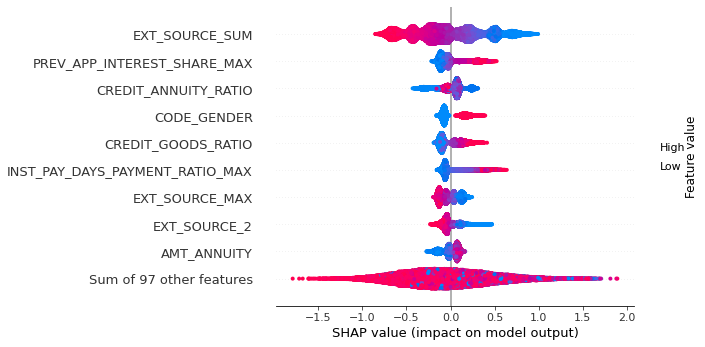

In [370]:
shap.plots.beeswarm(shap_values)

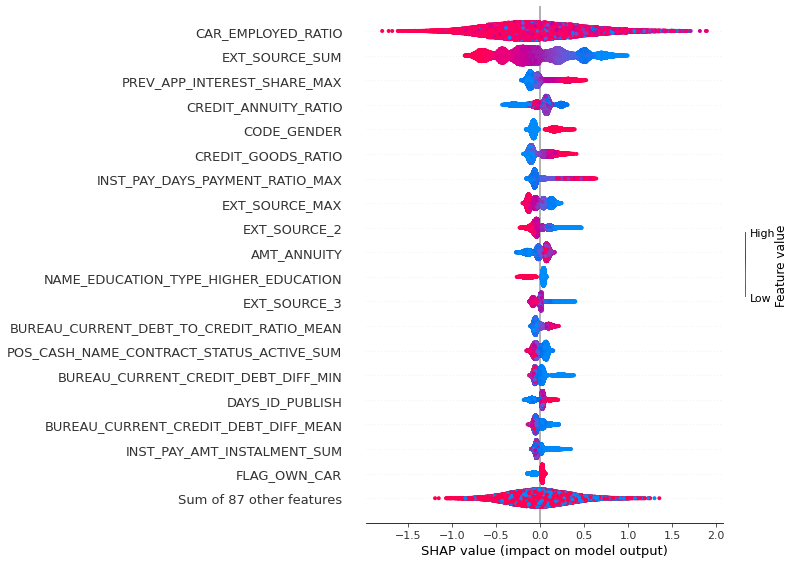

In [371]:
shap.plots.beeswarm(shap_values, max_display=20)

**Graphiques Locaux**

***BarPlot***

In [372]:
client_index = test_set[test_set['SK_ID_CURR'] == 100005].index.item()

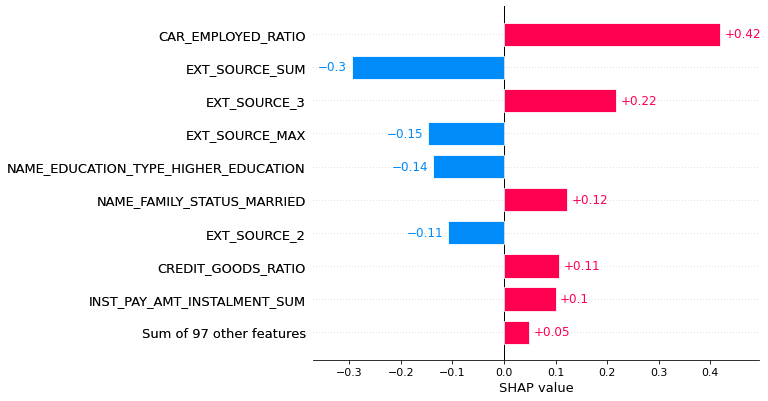

In [373]:
shap.plots.bar(shap_values[0])

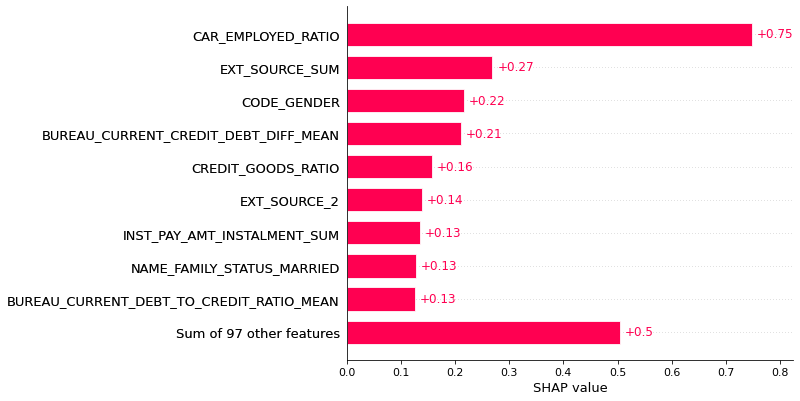

In [374]:
shap.plots.bar(shap_values[1])

In [375]:
shap_values[0,"AMT_ANNUITY"]

.values =
-0.047720381303224715

.base_values =
-0.4809392838667607

.data =
20560.5

***Waterfall Plot***

In [376]:
client_index = test_set[test_set['SK_ID_CURR'] == 100001].index.item()

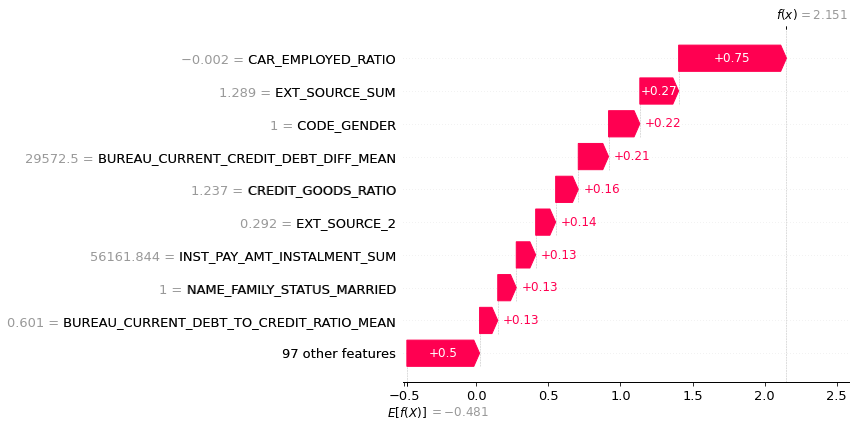

In [377]:
# Classe négative
shap.plots.waterfall(shap_values[1])

***ForcePlot***

In [382]:
explainer_0 = shap.TreeExplainer(best_model)

In [383]:
X_test_0 = X_test.iloc[0]
X_test_0_array = X_test_0.values.reshape(1, -1)

In [384]:
shap_values_0 = explainer_0.shap_values(X_test_0_array)

In [385]:
# Plot SHAP force_plot [1] pour classe positive
shap.initjs()
shap.force_plot(explainer_0.expected_value[1], shap_values_0[1],
                X_test_0)

In [386]:
# Plot SHAP force_plot [0] pour classe négative
shap.force_plot(explainer.expected_value[0], shap_values_0[0],
                X_test_0)

***Decision Plot***

**Client 100001**

In [ ]:
explainer_0 = shap.TreeExplainer(best_model)

In [ ]:
X_test_0 = X_test.iloc[0]
X_test_0_array = X_test_0.values.reshape(1, -1)

In [ ]:
shap_values_0 = explainer_0.shap_values(X_test_0_array)

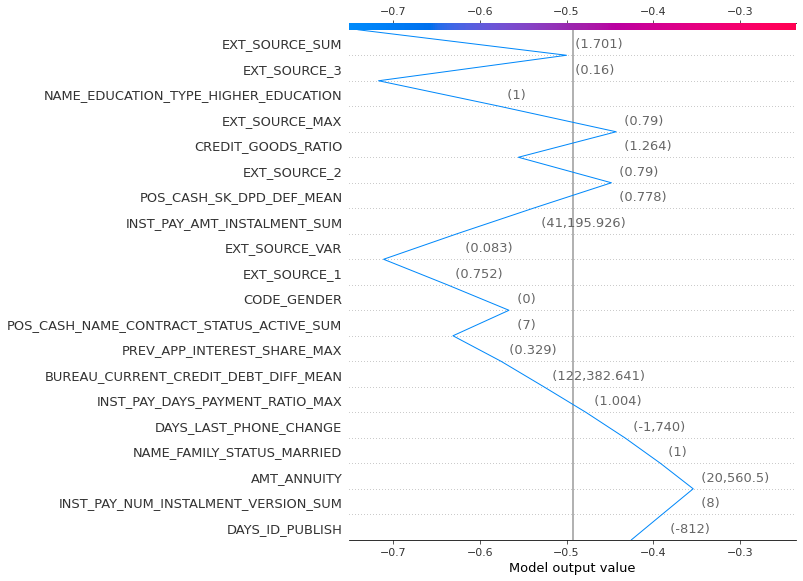

In [387]:
# Decision plot classe négative
shap.decision_plot(explainer_0.expected_value[1], shap_values_0[1],
                   X_test_0)

***

**Client 100005**

In [388]:
explainer = shap.TreeExplainer(best_model)

In [389]:
X_test_1 = X_test.iloc[1]
X_test_1_array = X_test_1.values.reshape(1, -1)

In [390]:
shap_values_1 = explainer.shap_values(X_test_1_array)

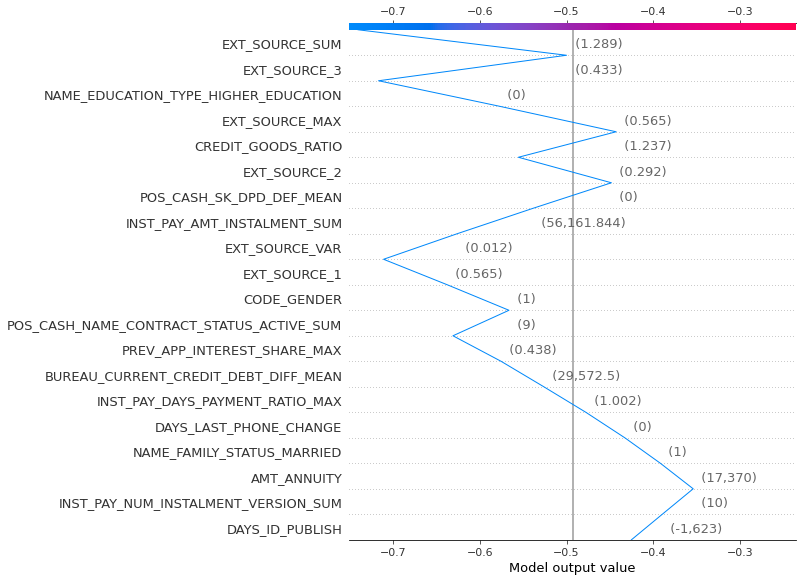

In [391]:
# Decision plot classe négative
shap.decision_plot(explainer.expected_value[1], shap_values_0[1],
                   X_test_1)

**Client 100038**

In [392]:
explainer = shap.TreeExplainer(best_model)

In [393]:
client_index = test_set[test_set['SK_ID_CURR'] == 100038].index.item()
X_test_1 = X_test.iloc[client_index]
X_test_1_array = X_test_1.values.reshape(1, -1)

In [394]:
shap_values_1 = explainer.shap_values(X_test_1_array)

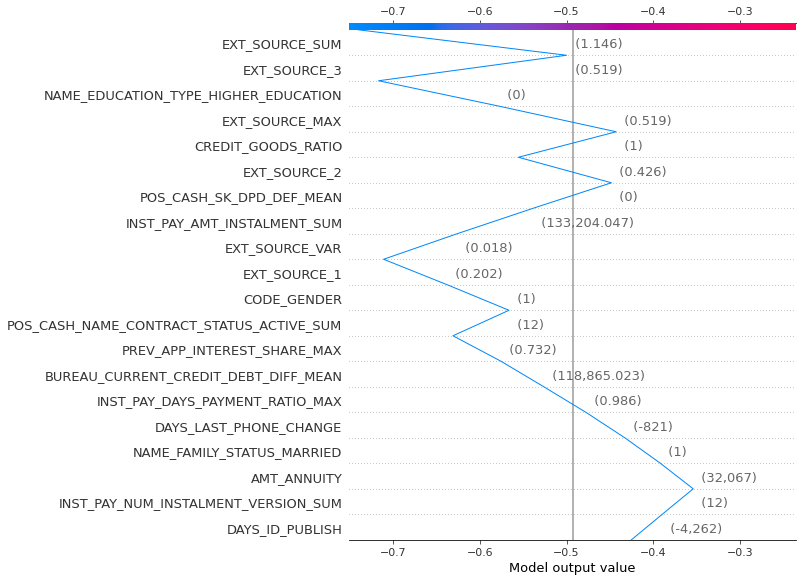

In [395]:
# Decision plot classe négative
shap.decision_plot(explainer.expected_value[1], shap_values_0[1],
                   X_test_1)

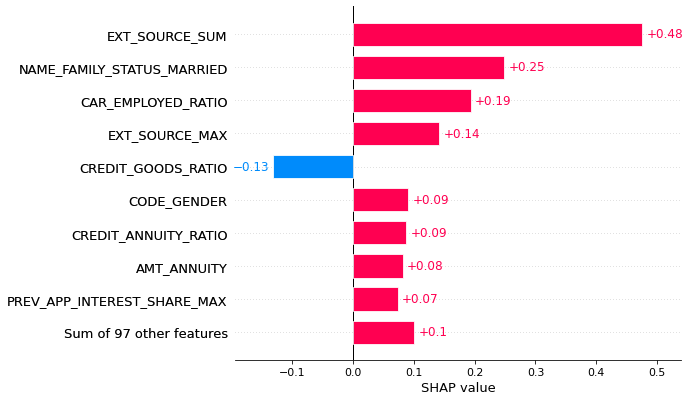

In [396]:
shap.plots.bar(shap_values[client_index])

In [397]:
client_index = test_set[test_set['SK_ID_CURR'] == 199344].index.item()
X_test_1 = X_test.iloc[client_index]
X_test_1_array = X_test_1.values.reshape(1, -1)

In [398]:
shap_values_1 = explainer.shap_values(X_test_1_array)

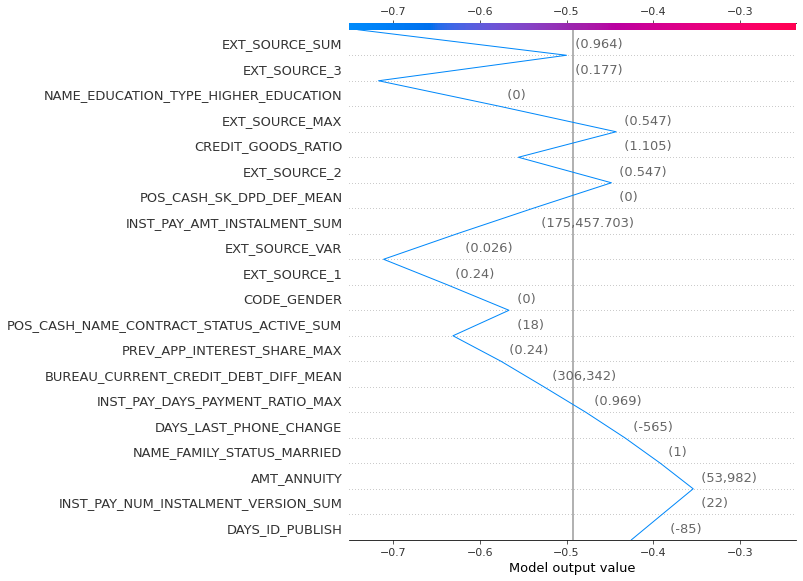

In [399]:
# Decision plot classe négative
shap.decision_plot(explainer.expected_value[1], shap_values_0[1],
                   X_test_1)

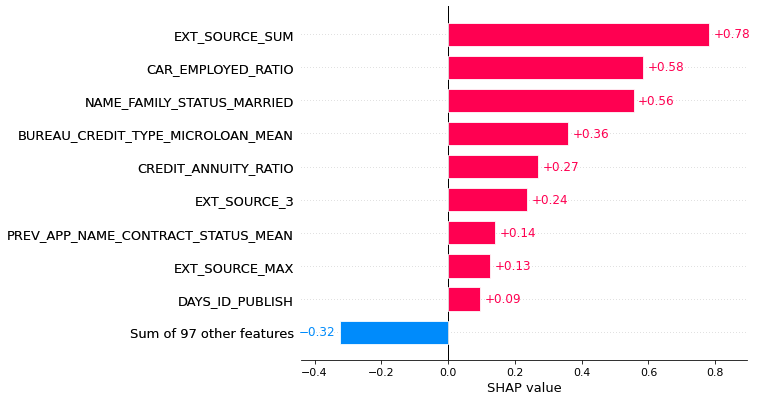

In [400]:
shap.plots.bar(shap_values[client_index])

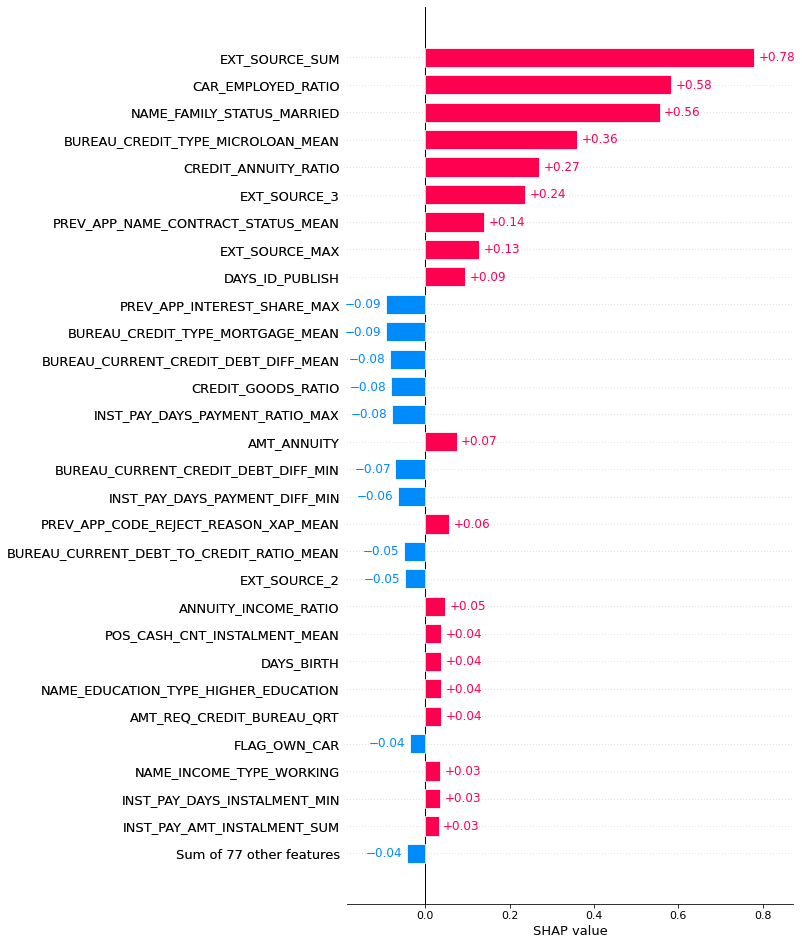

In [401]:
shap.plots.bar(shap_values[client_index], max_display=30)